In [ ]:
import os, time, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from dataclasses import dataclass
from typing import List, Dict, Tuple

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas_datareader.data as pdr

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
ETF_UNIVERSE = [
    'SPY','QQQ','IWM',        # US equities
    'EFA','EEM',              # Intl equities
    'XLK','XLF','XLV','XLY','XLP','XLI','XLU','XLB','XLE',  # sectors
    'TLT','IEF','LQD','HYG',  # rates/credit
    'GLD','SLV','DBC','USO','UNG',  # commodities
    'VNQ'                     # REITs
]

CRYPTO_UNIVERSE = ['BTC-USD','ETH-USD']
FUTURES_UNIVERSE = []
MACRO_TICKERS = ['UUP']

BENCHMARK_CANDIDATES = ['SPY','IVV','VOO']

END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')
START_DATE = (pd.to_datetime(END_DATE) - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

LOOKBACK = 32
HORIZON_DAYS = 5
REBALANCE_FREQ = 'W-FRI'

MODEL_TYPE = 'mlp'
LOSS_TYPE = 'mse'
ENSEMBLE = 3

ALLOW_SHORT = True
MAX_WEIGHT_PER_ASSET = 0.15
TARGET_ANN_VOL = 0.12
MAX_GROSS_LEVERAGE = 1.5
ETF_FEE_BPS = 1.0/10000.0
CRYPTO_FEE_BPS = 5.0/10000.0
FUTURES_FEE_BPS = 0.5/10000.0
TURNOVER_MIX = 0.7
WEIGHT_L2 = 0.0

USE_QP = True
RISK_AVERSION = 2.0
TURNOVER_PENALTY = 5.0
GROSS_TARGET = 1.0

REGIME_USE = True
SMA_LONG = 200
VOL_PCTL_WINDOW = 60
VOL_LOW = 0.30
VOL_HIGH = 0.70
TRAIN_PER_REGIME = True

EQUITY_LIKE = ['SPY','IVV','VOO','QQQ','IWM','EFA','EEM','XLK','XLF','XLV','XLY','XLP','XLI','XLU','XLB','XLE','VNQ']
DEFENSIVE_LIKE = ['TLT','IEF','LQD','GLD','SLV']
CRYPTO_LIKE = ['BTC-USD','ETH-USD']
COMMODITY_RISKY = ['USO','UNG','DBC']
RISK_OFF_EQUITY_CAP = 0.075
RISK_OFF_DEF_CAP    = 0.20
RISK_OFF_RISKY_SCALAR = 0.6

TRADING_DAYS = 252
PLOT_DPI = 120

DATA_DIR = '/content/data_cache'
CACHE_DIR = f'{DATA_DIR}/fmp_cache'
pathlib.Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

In [ ]:
def ann_vol(returns: pd.Series) -> float:
    return returns.std(ddof=0) * np.sqrt(TRADING_DAYS)


def sharpe(returns: pd.Series, rf: float = 0.0) -> float:
    ex = returns - rf/ TRADING_DAYS
    vol = returns.std(ddof=0)
    return 0.0 if vol == 0 else np.sqrt(TRADING_DAYS) * ex.mean() / vol


def max_drawdown(cum: pd.Series) -> float:
    roll_max = cum.cummax()
    dd = cum/roll_max - 1.0
    return dd.min()


def to_returns(prices: pd.Series) -> pd.Series:
    return prices.pct_change().fillna(0.0)

In [ ]:
FMP_API_KEY = os.getenv('FMP_API_KEY', 'PwR6CfUHES67gTFdIDm8ImJujJP8aWQO')
FMP_BASE = "https://financialmodelingprep.com/api/v3"

FMP_SYMBOL_MAP = {
    'BTC-USD': 'BTCUSD',
    'ETH-USD': 'ETHUSD',
}

def _fmp_symbol(sym: str) -> str:
    return FMP_SYMBOL_MAP.get(sym, sym)


def fmp_fetch_symbol(symbol: str, start: str = START_DATE, end: str = END_DATE,
                     session: requests.Session = None, max_retries: int = 3) -> pd.DataFrame:

    s = _fmp_symbol(symbol)
    sess = session or requests.Session()
    url = f"{FMP_BASE}/historical-price-full/{s}"
    params = {"from": start, "to": end, "apikey": FMP_API_KEY}
    last_status = None
    for attempt in range(max_retries):
        try:
            r = sess.get(url, params=params, timeout=30)
            last_status = r.status_code
            if r.status_code == 200:
                data = r.json()
                hist = data.get("historical")
                if not hist:
                    return pd.DataFrame()
                df = pd.DataFrame(hist)
                if 'date' not in df.columns:
                    return pd.DataFrame()
                df['date'] = pd.to_datetime(df['date'])
                df = df.set_index('date').sort_index()
                col = 'adjClose' if 'adjClose' in df.columns else 'close'
                out = df[[col]].rename(columns={col: symbol})
                return out
        except Exception as e:
            pass
        time.sleep(0.35 * (attempt + 1))  # gentle backoff
    print(f"FMP failed for {symbol}; status={last_status}")
    return pd.DataFrame()


def get_prices_fmp(tickers: List[str], start: str = START_DATE, end: str = END_DATE) -> pd.DataFrame:
    sess = requests.Session()
    frames = []
    for i, t in enumerate(tickers, 1):
        df = fmp_fetch_symbol(t, start, end, session=sess)
        if df is None or df.empty:
            print(f"FMP: no data for {t}")
        else:
            frames.append(df)
        time.sleep(0.25)
    if not frames:
        raise RuntimeError("No data pulled from FMP")
    price_df = pd.concat(frames, axis=1).sort_index()
    price_df = price_df.loc[:, ~price_df.columns.duplicated()]
    return price_df

ALL_TRADEABLE = list(dict.fromkeys(ETF_UNIVERSE + CRYPTO_UNIVERSE + FUTURES_UNIVERSE))
ALL_FEATURES_TICKERS = list(dict.fromkeys(ALL_TRADEABLE + MACRO_TICKERS + BENCHMARK_CANDIDATES))

print(f"Pulling {len(ALL_FEATURES_TICKERS)} tickers from {START_DATE} to {END_DATE} via FMP…")
price_wide = get_prices_fmp(ALL_FEATURES_TICKERS, start=START_DATE, end=END_DATE)
print("price_wide:", price_wide.index.min(), "→", price_wide.index.max(), "rows:", len(price_wide), "cols:", price_wide.shape[1])

cols = set(price_wide.columns)
MACRO_TICKERS_ACTIVE = [t for t in MACRO_TICKERS if t in cols]
TRADEABLE_ACTIVE = [t for t in ALL_TRADEABLE if t in cols]
BENCHMARK = next((b for b in BENCHMARK_CANDIDATES if b in cols), 'SPY')
print("Benchmark:", BENCHMARK)
print("Active tradables:", TRADEABLE_ACTIVE)
print("Active macro:", MACRO_TICKERS_ACTIVE)

_req_min = LOOKBACK + HORIZON_DAYS + 80
_def_ok = []
for t in list(TRADEABLE_ACTIVE):
    n = price_wide[t].dropna().shape[0]
    if n >= _req_min:
        _def_ok.append(t)
    else:
        print(f"Skipping {t}: only {n} rows (< {_req_min})")
TRADEABLE_ACTIVE = _def_ok
print("Tradables with sufficient history:", TRADEABLE_ACTIVE)

Pulling 29 tickers from 2020-08-15 to 2025-08-15 via FMP…
price_wide: 2020-08-15 00:00:00 → 2025-08-15 00:00:00 rows: 1827 cols: 29
Benchmark: SPY
Active tradables: ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLI', 'XLU', 'XLB', 'XLE', 'TLT', 'IEF', 'LQD', 'HYG', 'GLD', 'SLV', 'DBC', 'USO', 'UNG', 'VNQ', 'BTC-USD', 'ETH-USD']
Active macro: ['UUP']
Tradables with sufficient history: ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'XLK', 'XLF', 'XLV', 'XLY', 'XLP', 'XLI', 'XLU', 'XLB', 'XLE', 'TLT', 'IEF', 'LQD', 'HYG', 'GLD', 'SLV', 'DBC', 'USO', 'UNG', 'VNQ', 'BTC-USD', 'ETH-USD']


In [ ]:
FRED_SERIES = {
    'GS10': '10Y Treasury yield',
    'TB3MS': '3M T-bill',
    'BAMLH0A0HYM2': 'HY OAS',
    'DTWEXBGS': 'USD Broad Index',
    'CPIAUCSL': 'CPI (All Urban, SA)'
}

def load_fred(series_codes: List[str], start=START_DATE, end=None) -> pd.DataFrame:
    out = {}
    for code in series_codes:
        try:
            s = pdr.DataReader(code, 'fred', start, end).iloc[:,0]
            out[code] = s
        except Exception as e:
            print(f"FRED {code} failed: {e}")
    if not out:
        return pd.DataFrame()
    df = pd.DataFrame(out).resample('B').ffill()
    return df

fred_df = load_fred(list(FRED_SERIES.keys()), START_DATE, END_DATE)
print("FRED macro loaded:", list(fred_df.columns))

FRED macro loaded: ['GS10', 'TB3MS', 'BAMLH0A0HYM2', 'DTWEXBGS', 'CPIAUCSL']


In [ ]:
def rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.clip(lower=0)).ewm(alpha=1/window, adjust=False).mean()
    loss = (-delta.clip(upper=0)).ewm(alpha=1/window, adjust=False).mean()
    rs = gain / (loss + 1e-12)
    return 100 - (100 / (1 + rs))


def macd(series: pd.Series, fast: int=12, slow: int=26, signal: int=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist


def make_tech_features(prices: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame({'close': prices})
    df['ret_1'] = df['close'].pct_change()
    df['ret_5'] = df['close'].pct_change(5)
    df['ret_10'] = df['close'].pct_change(10)
    df['ret_20'] = df['close'].pct_change(20)
    df['ret_60'] = df['close'].pct_change(60)
    df['ret_120'] = df['close'].pct_change(120)
    for w in [5,10,20,50,100,200]:
        sma = df['close'].rolling(w).mean()
        ema = df['close'].ewm(span=w, adjust=False).mean()
        df[f'sma_{w}'] = sma
        df[f'ema_{w}'] = ema
        df[f'dev_sma_{w}'] = (df['close'] - sma) / (sma + 1e-9)
        df[f'bb_z_{w}'] = (df['close']-sma)/(df['close'].rolling(w).std(ddof=0)+1e-9)
    df['rsi_14'] = rsi(df['close'],14)
    macd_line, signal_line, hist = macd(df['close'])
    df['macd'] = macd_line
    df['macd_signal'] = signal_line
    df['macd_hist'] = hist
    df['vol_20'] = df['ret_1'].rolling(20).std(ddof=0)
    df['vol_60'] = df['ret_1'].rolling(60).std(ddof=0)
    df['skew_60'] = df['ret_1'].rolling(60).skew()
    df['kurt_60'] = df['ret_1'].rolling(60).kurt()
    df = df.dropna()
    return df

tech_by_ticker: Dict[str,pd.DataFrame] = {}
for t in price_wide.columns:
    try:
        tech_by_ticker[t] = make_tech_features(price_wide[t].dropna())
    except Exception as e:
        print(f"Features failed for {t}: {e}")

macro_frames = []
for t in MACRO_TICKERS:
    if t in tech_by_ticker:
        macro_frames.append(tech_by_ticker[t].add_prefix(f"{t}:"))

if macro_frames:
    macro_df = pd.concat(macro_frames, axis=1, join='outer').sort_index()
else:
    base_key = next((b for b in BENCHMARK_CANDIDATES if b in tech_by_ticker), next(iter(tech_by_ticker)))
    macro_df = tech_by_ticker[base_key].add_prefix(f"{base_key}:")

base_idx = price_wide[BENCHMARK].dropna().index
macro_df = macro_df.reindex(base_idx).ffill().bfill(limit=5)

In [ ]:
if REGIME_USE:
    bench = price_wide[BENCHMARK].dropna()
    sma_long = bench.rolling(SMA_LONG).mean()
    trend_bull = (bench > sma_long).astype(int)

    if '^VIX' in price_wide.columns:
        vix = price_wide['^VIX'].dropna()
        vix_pctl = vix.rolling(VOL_PCTL_WINDOW).rank(pct=True)
    else:
        vol_proxy = bench.pct_change().rolling(20).std(ddof=0) * np.sqrt(TRADING_DAYS)
        vix_pctl = vol_proxy.rolling(VOL_PCTL_WINDOW).rank(pct=True)
    vh = (vix_pctl > VOL_HIGH).astype(int)
    vl = (vix_pctl < VOL_LOW).astype(int)

    if {'GS10','TB3MS'}.issubset(fred_df.columns):
        term_spread = (fred_df['GS10'] - fred_df['TB3MS']).reindex(bench.index).ffill()
        yc_inverted = (term_spread < 0).astype(int)
    else:
        term_spread = pd.Series(index=bench.index, dtype=float)
        yc_inverted = pd.Series(0, index=bench.index)

    if 'BAMLH0A0HYM2' in fred_df.columns:
        oas = fred_df['BAMLH0A0HYM2'].reindex(bench.index).ffill()
        z = (oas - oas.rolling(252).mean()) / (oas.rolling(252).std(ddof=0) + 1e-9)
        credit_rel_z = z
        credit_stress = (z > 0.5).astype(int)
    elif {'HYG','LQD'}.issubset(price_wide.columns):
        cr_idx = price_wide['HYG'].dropna().index.intersection(price_wide['LQD'].dropna().index)
        rel = np.log(price_wide['HYG'].reindex(cr_idx)) - np.log(price_wide['LQD'].reindex(cr_idx))
        roll = rel.rolling(120)
        credit_rel_z = (rel - roll.mean()) / (roll.std(ddof=0) + 1e-9)
        credit_stress = (credit_rel_z < -0.5).astype(int)
    else:
        credit_rel_z = pd.Series(index=bench.index, dtype=float)
        credit_stress = pd.Series(0, index=bench.index)

    idx = bench.index
    trend_bear = 1 - trend_bull
    regime_code = (
        ( trend_bear.reindex(idx).fillna(0).astype(int) & (vl.reindex(idx)==1) ) * 0 +
        ( trend_bear.reindex(idx).fillna(0).astype(int) & ((vl.reindex(idx)==0) & (vh.reindex(idx)==0)) ) * 1 +
        ( trend_bear.reindex(idx).fillna(0).astype(int) & (vh.reindex(idx)==1) ) * 2 +
        ( trend_bull.reindex(idx).fillna(0).astype(int) & (vl.reindex(idx)==1) ) * 3 +
        ( trend_bull.reindex(idx).fillna(0).astype(int) & ((vl.reindex(idx)==0) & (vh.reindex(idx)==0)) ) * 4 +
        ( trend_bull.reindex(idx).fillna(0).astype(int) & (vh.reindex(idx)==1) ) * 5
    )
    regime_df = pd.DataFrame({'regime_code': regime_code}, index=idx)
    regime_dummies = pd.get_dummies(regime_df['regime_code'], prefix='regime')

    extra = pd.DataFrame(index=idx)
    extra['term_spread_raw'] = term_spread.reindex(idx)
    extra['yc_inverted'] = yc_inverted.reindex(idx).fillna(0).astype(int)
    extra['credit_rel_z'] = credit_rel_z.reindex(idx)
    extra['credit_stress'] = credit_stress.reindex(idx).fillna(0).astype(int)

    regime_panel = regime_dummies.reindex(macro_df.index).ffill().fillna(0).astype(int)
    extra_panel = extra.reindex(macro_df.index).ffill()
    macro_df = macro_df.join(regime_panel, how='left').join(extra_panel, how='left').ffill().dropna(how='all')
else:
    regime_df = pd.DataFrame(index=macro_df.index, data={'regime_code': 4})

fred_panel = pd.DataFrame(index=fred_df.index)
if {'GS10','TB3MS'}.issubset(fred_df.columns):
    fred_panel['FRED:term_spread'] = (fred_df['GS10'] - fred_df['TB3MS'])
if 'BAMLH0A0HYM2' in fred_df.columns:
    oas = fred_df['BAMLH0A0HYM2']
    fred_panel['FRED:HY_OAS'] = oas
    fred_panel['FRED:HY_OAS_Z'] = (oas - oas.rolling(252).mean()) / (oas.rolling(252).std(ddof=0) + 1e-9)
if 'DTWEXBGS' in fred_df.columns:
    fred_panel['FRED:USD_RET'] = fred_df['DTWEXBGS'].pct_change()
if 'CPIAUCSL' in fred_df.columns:
    cpi = fred_df['CPIAUCSL']
    fred_panel['FRED:CPI_YoY'] = (cpi/cpi.shift(12) - 1.0)
fred_panel = fred_panel.reindex(macro_df.index).ffill()
macro_df = macro_df.join(fred_panel, how='left').ffill()
macro_df = macro_df.dropna(axis=1, how='all').ffill()


/tmp/ipython-input-677194078.py:70: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fred_panel['FRED:USD_RET'] = fred_df['DTWEXBGS'].pct_change()


In [ ]:
def build_supervised_dataset(tradables: List[str], lookback: int = LOOKBACK):
    X_by, y_by, dates_by = {}, {}, {}
    for t in tradables:
        if t not in tech_by_ticker:
            continue
        asset_df = tech_by_ticker[t]
        aligned = asset_df.join(macro_df, how='left').ffill().bfill(limit=5)
        aligned = aligned.dropna(axis=1, how='all') # Corrected indentation
        feat_cols = [c for c in aligned.columns if c != 'close']
        fwd = asset_df['close'].shift(-HORIZON_DAYS) / asset_df['close'] - 1.0
        target = fwd.reindex(aligned.index).dropna()
        feats = aligned.loc[target.index, feat_cols].copy()
        feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
        X_list, y_list, d_list = [], [], []
        arr, y_arr = feats.values, target.values
        idx = feats.index
        for i in range(lookback, len(feats)):
            X_list.append(arr[i-lookback:i, :])
            y_list.append(y_arr[i])
            d_list.append(idx[i])
        if X_list:
            X_by[t] = np.stack(X_list)
            y_by[t] = np.array(y_list)
            dates_by[t] = pd.to_datetime(d_list)
        else:
            print(f"Insufficient data for {t} (usable rows: {len(feats) if 'feats' in locals() else 0})")
    if not X_by:
        raise ValueError("No assets built for supervised dataset")
    common_dates = sorted(set().union(*[set(dates_by[k]) for k in dates_by.keys()]))
    feature_names = feats.columns.tolist()
    return X_by, y_by, dates_by, pd.DatetimeIndex(common_dates), feature_names

X_by, y_by, dates_by, common_dates, feature_names = build_supervised_dataset([t for t in TRADEABLE_ACTIVE if t in tech_by_ticker], LOOKBACK)
print(f"Built sequences for {len(X_by)} assets; feature_dim={len(feature_names)}; dates={len(common_dates)}")

/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feat

Built sequences for 26 assets; feature_dim=90; dates=1591


/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill').fillna(method='bfill').fillna(0.0) # Corrected indentation
/tmp/ipython-input-4202585648.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feat

In [ ]:
def _neg_corr_loss():
    def neg_corr_loss(y_true, y_pred):
        y_true_c = y_true - tf.reduce_mean(y_true)
        y_pred_c = y_pred - tf.reduce_mean(y_pred)
        cov = tf.reduce_mean(y_true_c * y_pred_c)
        std_t = tf.math.reduce_std(y_true_c) + 1e-8
        std_p = tf.math.reduce_std(y_pred_c) + 1e-8
        corr = cov / (std_t * std_p)
        return 1.0 - corr
    return neg_corr_loss


def build_mlp(input_shape: Tuple[int,int]) -> keras.Model:
    inp = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(axis=[1,2])(inp)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inp, out)
    loss_fn = _neg_corr_loss() if LOSS_TYPE=='neg_corr' else 'mse'
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn)
    return model


def build_lstm(input_shape: Tuple[int,int]) -> keras.Model:
    inp = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(axis=[1,2])(inp)
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inp, out)
    loss_fn = _neg_corr_loss() if LOSS_TYPE=='neg_corr' else 'mse'
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn)
    return model


def build_transformer(input_shape: Tuple[int,int]) -> keras.Model:
    T, F = input_shape
    inp = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(axis=[1,2])(inp)
    pos = tf.range(start=0, limit=T, delta=1)
    pos_emb = layers.Embedding(input_dim=T, output_dim=32)(pos)
    pos_emb = tf.expand_dims(pos_emb, axis=0)
    pos_emb = tf.tile(pos_emb, [tf.shape(x)[0], 1, 1])
    x_proj = layers.Dense(128)(x)
    x = layers.Concatenate(axis=-1)([x_proj, pos_emb])
    def encoder_block(x_in, heads=4, d_ff=256, drop=0.1):
        attn = layers.MultiHeadAttention(num_heads=heads, key_dim=64)(x_in, x_in)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x_in + layers.Dropout(drop)(attn))
        ff = layers.Dense(d_ff, activation='relu')(x1)
        ff = layers.Dense(x1.shape[-1])(ff)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + layers.Dropout(drop)(ff))
        return x2
    x = encoder_block(x, heads=4)
    x = encoder_block(x, heads=4)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6))(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    loss_fn = _neg_corr_loss() if LOSS_TYPE=='neg_corr' else 'mse'
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss_fn)
    return model


def make_model(input_shape: Tuple[int,int]):
    if MODEL_TYPE == 'lstm':
        return build_lstm(input_shape)
    elif MODEL_TYPE == 'transformer':
        return build_transformer(input_shape)
    else:
        return build_mlp(input_shape)


In [ ]:
assert 'regime_df' in globals(), "regime_df missing"
assert 'regime_code' in regime_df.columns, "regime_df must have 'regime_code'"

regime_df = regime_df.copy()
regime_df.index = pd.to_datetime(regime_df.index)
regime_df['regime_code'] = pd.to_numeric(regime_df['regime_code'], errors='coerce')

assert 'common_dates' in globals(), "common_dates missing (built from your dataset)"
regime_df = regime_df.reindex(regime_df.index.union(common_dates)).sort_index()
regime_df['regime_code'] = (
    regime_df['regime_code']
      .ffill().bfill()
      .fillna(4)
      .round().astype(int)
)
print("Regime df patched. Any NaNs left?",
      regime_df['regime_code'].isna().sum())


Regime df patched. Any NaNs left? 0


In [ ]:
import numpy as np, pandas as pd, random
from typing import Dict, List, Tuple
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow import keras

tf.config.optimizer.set_jit(False)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

LOOKBACK         = globals().get("LOOKBACK", 32)
HORIZON_DAYS     = globals().get("HORIZON_DAYS", 21)
ENSEMBLE         = globals().get("ENSEMBLE", 3)
EPOCHS           = globals().get("EPOCHS", 60)
BATCH_SIZE       = globals().get("BATCH_SIZE", 256)
N_SPLITS         = globals().get("N_SPLITS", 4)
N_REGIMES        = globals().get("N_REGIMES", 6)
TRAIN_PER_REGIME = globals().get("TRAIN_PER_REGIME", True)
SEED_BASE        = globals().get("SEED_BASE", 2025)

def build_supervised_dataset(
    tradables: List[str],
    lookback: int = LOOKBACK,
    horizon: int = HORIZON_DAYS,
) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray], Dict[str, pd.DatetimeIndex], pd.DatetimeIndex, List[str]]:
    assert "tech_by_ticker" in globals(), "Missing tech_by_ticker"
    assert "macro_df" in globals(), "Missing macro_df"

    feat_set = None
    valid_tickers = []
    for t in tradables:
        if t not in tech_by_ticker:
            continue
        df0 = tech_by_ticker[t].join(macro_df, how="left").ffill().bfill(limit=5)
        if 'close' not in df0.columns or df0['close'].count() < (lookback + horizon + 10):
            continue
        cols = set(c for c in df0.columns if c != 'close')
        feat_set = cols if feat_set is None else (feat_set & cols)
        valid_tickers.append(t)

    if not valid_tickers or not feat_set:
        raise RuntimeError("No valid tickers or no common features. Check data coverage")

    feature_names = sorted(list(feat_set))

    X_by, y_by, dates_by = {}, {}, {}
    for t in valid_tickers:
        df = tech_by_ticker[t].join(macro_df, how="left").ffill().bfill(limit=5)
        feat = df[feature_names].copy()
        fwd  = df["close"].shift(-horizon) / df["close"] - 1.0
        idx  = feat.index.intersection(fwd.dropna().index)
        if len(idx) < (lookback + 1):
            continue
        feat = feat.loc[idx].fillna(0.0)
        yv   = fwd.loc[idx].values
        arr  = feat.values

        X_list, y_list, d_list = [], [], []
        for i in range(lookback, len(idx)):
            X_list.append(arr[i-lookback:i, :])
            y_list.append(yv[i])
            d_list.append(idx[i])
        if X_list:
            X_by[t]     = np.stack(X_list)
            y_by[t]     = np.array(y_list)
            dates_by[t] = pd.to_datetime(d_list)

    if not X_by:
        raise RuntimeError("No sequences built—try reducing LOOKBACK or HORIZON_DAYS")

    all_dates = sorted(set().union(*[set(dates_by[k]) for k in dates_by.keys()]))
    return X_by, y_by, dates_by, pd.DatetimeIndex(all_dates), feature_names

TICKS = globals().get("TRADEABLE_ACTIVE", list(tech_by_ticker.keys()))
X_by, y_by, dates_by, common_dates, feature_names = build_supervised_dataset(TICKS)
INFER_FEATURES = feature_names[:]
print(f"Built dataset for {len(X_by)} assets | features={len(feature_names)} | dates={len(common_dates)}")
for k in list(X_by.keys())[:3]:
    print(f"  {k}: X{X_by[k].shape}, y{y_by[k].shape}")

def stack_assets_for_window(
    X_by: Dict[str, np.ndarray],
    y_by: Dict[str, np.ndarray],
    dates_by: Dict[str, pd.DatetimeIndex],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
) -> Tuple[np.ndarray, np.ndarray, pd.DatetimeIndex]:
    Xs, ys, ds = [], [], []
    for t in X_by:
        d = dates_by[t]
        m = (d >= start_date) & (d <= end_date)
        if m.any():
            Xs.append(X_by[t][m])
            ys.append(y_by[t][m])
            ds.extend(list(d[m]))
    if not Xs:
        return np.empty((0, LOOKBACK, len(INFER_FEATURES))), np.empty((0,)), pd.DatetimeIndex([])
    X = np.vstack(Xs); y = np.concatenate(ys); d = pd.to_datetime(ds)
    order = np.argsort(d.values)
    return X[order], y[order], d[order]

def walk_forward_train_per_regime(
    X_by: Dict[str, np.ndarray],
    y_by: Dict[str, np.ndarray],
    dates_by: Dict[str, pd.DatetimeIndex],
    all_dates: pd.DatetimeIndex,
    n_splits: int = N_SPLITS,
    n_regimes: int = N_REGIMES,
) -> Dict[int, List[keras.Model]]:
    assert "regime_df" in globals(), "Need regime_df with 'regime_code'"
    regcodes = regime_df.reindex(all_dates).ffill()["regime_code"].astype(int).values

    tss = list(TimeSeriesSplit(n_splits=n_splits).split(np.arange(len(all_dates))))
    input_shape = (LOOKBACK, len(INFER_FEATURES))
    regime_models: Dict[int, List[keras.Model]] = {r: [] for r in range(n_regimes)}

    print("Training separate ensembles per regime…")
    for fold, (tr_idx, va_idx) in enumerate(tss):
        tr_start, tr_end = all_dates[tr_idx[0]], all_dates[tr_idx[-1]]
        Xtr, ytr, dtr = stack_assets_for_window(X_by, y_by, dates_by, tr_start, tr_end)
        if Xtr.shape[0] == 0:
            print(f"Fold {fold}: no train samples")
            continue

        rc_tr = pd.Series(regcodes[tr_idx], index=all_dates[tr_idx])
        rc_d  = rc_tr.reindex(dtr).ffill().bfill().astype(int).values

        for r in range(n_regimes):
            m_r = (rc_d == r)
            n_r = int(m_r.sum())
            if n_r == 0:
                continue
            Xr, yr = Xtr[m_r], ytr[m_r]
            models_r = []
            for m_i in range(max(1, ENSEMBLE)):
                seed = SEED_BASE + fold*101 + r*7 + m_i
                tf.random.set_seed(seed); random.seed(seed); np.random.seed(seed)
                mdl = make_model(input_shape)
                cb = [
                    keras.callbacks.EarlyStopping(monitor="loss", patience=8, restore_best_weights=True),
                    keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=4, min_lr=1e-5),
                ]
                mdl.fit(Xr, yr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, callbacks=cb)
                models_r.append(mdl)
            regime_models[r] = models_r
            print(f"Fold {fold} Regime {r}: trained {len(models_r)} models on {n_r} samples")

    fallback = next((regime_models[r] for r in range(n_regimes) if len(regime_models[r])>0), [])
    for r in range(n_regimes):
        if len(regime_models[r]) == 0:
            regime_models[r] = fallback
            print(f"Regime {r}: using fallback models")
    return regime_models

def train_single_global_model(
    X_by: Dict[str, np.ndarray],
    y_by: Dict[str, np.ndarray],
    dates_by: Dict[str, pd.DatetimeIndex],
    all_dates: pd.DatetimeIndex,
) -> keras.Model:
    tss = list(TimeSeriesSplit(n_splits=N_SPLITS).split(np.arange(len(all_dates))))
    tr_idx, _ = tss[-1]
    tr_start, tr_end = all_dates[tr_idx[0]], all_dates[tr_idx[-1]]
    Xtr, ytr, _ = stack_assets_for_window(X_by, y_by, dates_by, tr_start, tr_end)
    if Xtr.shape[0] == 0:
        raise RuntimeError("No train samples for global model")
    tf.random.set_seed(SEED_BASE); random.seed(SEED_BASE); np.random.seed(SEED_BASE)
    mdl = make_model((LOOKBACK, len(INFER_FEATURES)))
    cb = [
        keras.callbacks.EarlyStopping(monitor="loss", patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=4, min_lr=1e-5),
    ]
    mdl.fit(Xtr, ytr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cb)
    return mdl

if TRAIN_PER_REGIME:
    regime_models = walk_forward_train_per_regime(X_by, y_by, dates_by, common_dates, n_splits=N_SPLITS)
    final_model = {r: regime_models[r] for r in regime_models}
else:
    final_model = train_single_global_model(X_by, y_by, dates_by, common_dates)

print("\nTraining complete")


Built dataset for 26 assets | features=90 | dates=1591
  SPY: X(1020, 32, 90), y(1020,)
  QQQ: X(1020, 32, 90), y(1020,)
  IWM: X(1020, 32, 90), y(1020,)
Training separate ensembles per regime…
Fold 0 Regime 0: trained 3 models on 78 samples
Fold 0 Regime 1: trained 3 models on 150 samples
Fold 0 Regime 2: trained 3 models on 56 samples
Fold 0 Regime 3: trained 3 models on 916 samples
Fold 0 Regime 4: trained 3 models on 1514 samples
Fold 0 Regime 5: trained 3 models on 1476 samples
Fold 1 Regime 0: trained 3 models on 1608 samples
Fold 1 Regime 1: trained 3 models on 1580 samples
Fold 1 Regime 2: trained 3 models on 2420 samples
Fold 1 Regime 3: trained 3 models on 1050 samples
Fold 1 Regime 4: trained 3 models on 1704 samples
Fold 1 Regime 5: trained 3 models on 1744 samples
Fold 2 Regime 0: trained 3 models on 1882 samples
Fold 2 Regime 1: trained 3 models on 1606 samples
Fold 2 Regime 2: trained 3 models on 2554 samples
Fold 2 Regime 3: trained 3 models on 4126 samples
Fold 2 Regim

In [ ]:
try:
    WEIGHT_L2
except NameError:
    WEIGHT_L2 = 0.0

def weight_from_scores(scores: pd.Series,
                       hist_returns: pd.DataFrame,
                       allow_short: bool = ALLOW_SHORT,
                       max_abs: float = MAX_WEIGHT_PER_ASSET) -> pd.Series:

    if scores is None or len(scores) == 0:
        return pd.Series(dtype=float)

    vol = hist_returns.loc[:, scores.index].rolling(20).std(ddof=0).iloc[-1]
    vol = vol.replace(0, np.nan)
    adj = (scores / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    if WEIGHT_L2 > 0:
        adj = adj / (1.0 + WEIGHT_L2)

    raw = np.tanh(adj) if allow_short else np.clip(adj, 0, None)

    w = raw.clip(lower=(-max_abs if allow_short else 0.0), upper=max_abs)
    gross = w.abs().sum()
    if gross > 0:
        w = w / gross
    else:
        w[:] = 0.0
    return w.sort_index()


In [ ]:
import pandas as pd
import numpy as np

REGIME_USE = globals().get('REGIME_USE', True)

def compute_current_regime(date: pd.Timestamp) -> int:
    if not REGIME_USE:
        return 4
    reg = globals().get('regime_df', None)
    if reg is None or len(getattr(reg, 'index', [])) == 0 or 'regime_code' not in reg.columns:
        return 4
    reg = reg.sort_index()
    if date < reg.index[0]:
        return 4
    sub = reg.loc[:date]
    if sub.empty:
        return 4
    val = sub['regime_code'].ffill().iloc[-1]
    try:
        return int(val)
    except Exception:
        return 4

if 'regime_adjust_weights' not in globals():
    def regime_adjust_weights(date: pd.Timestamp, w: pd.Series) -> pd.Series:
        return w


In [ ]:
import numpy as np, pandas as pd

TRADING_DAYS       = globals().get('TRADING_DAYS', 252)
TARGET_ANN_VOL     = globals().get('TARGET_ANN_VOL', 0.10)
MAX_GROSS_LEVERAGE = globals().get('MAX_GROSS_LEVERAGE', 3.0)

def apply_vol_target(port_ret: pd.Series,
                     target_ann_vol: float = TARGET_ANN_VOL,
                     max_gross_leverage: float = MAX_GROSS_LEVERAGE,
                     lookback: int = 60) -> pd.Series:
    r = pd.Series(port_ret).dropna()
    if len(r) < lookback + 1 or target_ann_vol is None:
        return r
    rolling_vol = r.rolling(lookback, min_periods=lookback).std(ddof=0) * np.sqrt(TRADING_DAYS)
    scaling = (target_ann_vol / rolling_vol).clip(upper=max_gross_leverage)
    scaling = scaling.reindex(r.index).fillna(1.0)
    return r * scaling

def to_returns(x):
    if isinstance(x, pd.DataFrame):
        return x.iloc[:,0].pct_change(fill_method=None).fillna(0.0)
    return x.pct_change(fill_method=None).fillna(0.0)


Rebalance 0/129 @ 2020-09-18
Rebalance 10/129 @ 2021-02-05
Rebalance 20/129 @ 2021-06-25
Rebalance 30/129 @ 2021-11-12
Rebalance 40/129 @ 2022-04-01
Rebalance 50/129 @ 2022-08-19
Rebalance 60/129 @ 2023-01-06
Rebalance 70/129 @ 2023-05-26
Rebalance 80/129 @ 2023-10-13
Rebalance 90/129 @ 2024-03-01
Rebalance 100/129 @ 2024-07-19
Rebalance 110/129 @ 2024-12-06
Rebalance 120/129 @ 2025-04-25
Fast backtest finished in 618.4s

Strategy (FAST)
  Period   : 2021-04-17 → 2025-08-14
  CAGR     : -3.17%
  Ann.Vol  :  10.61%
  Sharpe   : -0.25
  MaxDD    : -27.68%
  Turnover(mean/reb): 0.647

Benchmark (SPY)
  Period   : 2021-04-17 → 2025-08-14
  CAGR     :  5.50%
  Ann.Vol  :  13.03%
  Sharpe   :  0.48
  MaxDD    : -18.77%
  Turnover(mean/reb): 0.647


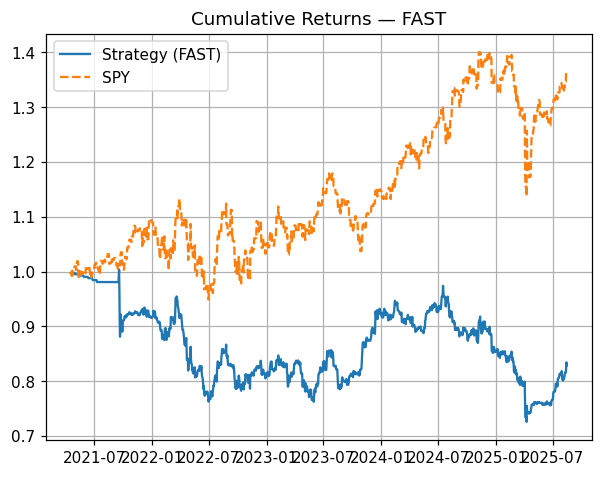

In [ ]:
import time
import numpy as np
import pandas as pd

USE_QP = False
REBALANCE_FREQ = '2W-FRI'
PROGRESS_EVERY = 10

try:
    INFER_FEATURES
except NameError:
    INFER_FEATURES = feature_names[:]
try:
    weight_from_scores
except NameError:
    WEIGHT_L2 = globals().get('WEIGHT_L2', 0.0)
    def weight_from_scores(scores: pd.Series,
                           hist_returns: pd.DataFrame,
                           allow_short: bool = ALLOW_SHORT,
                           max_abs: float = MAX_WEIGHT_PER_ASSET) -> pd.Series:
        if scores is None or len(scores) == 0:
            return pd.Series(dtype=float)
        vol = hist_returns.loc[:, scores.index].rolling(20).std(ddof=0).iloc[-1]
        vol = vol.replace(0, np.nan)
        adj = (scores / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        if WEIGHT_L2 > 0:
            adj = adj / (1.0 + WEIGHT_L2)
        raw = np.tanh(adj) if ALLOW_SHORT else np.clip(adj, 0, None)
        w = raw.clip(lower=(-max_abs if ALLOW_SHORT else 0.0), upper=max_abs)
        g = w.abs().sum()
        if g > 0: w = w / g
        return w.sort_index()

def compute_signal_scores_fast(date: pd.Timestamp, model_or_models) -> pd.Series:
    preds = {}
    for t in TRADEABLE_ACTIVE:
        if t not in tech_by_ticker:
            continue
        asset_df = tech_by_ticker[t].join(macro_df, how='left').ffill().bfill(limit=5)
        if len(asset_df) <= LOOKBACK:
            continue
        end_loc = asset_df.index.get_loc(date) if date in asset_df.index else asset_df.index.searchsorted(date) - 1
        if end_loc < LOOKBACK:
            continue
        window = asset_df.iloc[end_loc-LOOKBACK:end_loc].copy()
        missing = [c for c in INFER_FEATURES if c not in window.columns]
        for m in missing: window[m] = 0.0
        X = window[INFER_FEATURES].values[np.newaxis, :, :]

        if isinstance(model_or_models, list):
            yhat = float(np.mean([m.predict(X, verbose=0).ravel()[0] for m in model_or_models]))
        elif TRAIN_PER_REGIME and isinstance(model_or_models, dict):
            code = compute_current_regime(asset_df.index[end_loc])
            mdl_list = model_or_models.get(code) or next(iter(model_or_models.values()))
            ens = mdl_list if isinstance(mdl_list, list) else [mdl_list]
            yhat = float(np.mean([m.predict(X, verbose=0).ravel()[0] for m in ens]))
        else:
            yhat = float(model_or_models.predict(X, verbose=0).ravel()[0])
        preds[t] = yhat
    return pd.Series(preds).sort_index()

def backtest_fast(model_or_models):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    if start_pos >= len(idx):
        raise RuntimeError("Not enough history to start backtest; reduce LOOKBACK or extend data")
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=REBALANCE_FREQ)
    rets = prices.pct_change(fill_method=None).fillna(0.0)

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}
    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    t0 = time.time()
    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue
        if (i % PROGRESS_EVERY) == 0:
            print(f"Rebalance {i}/{len(rebal_dates)} @ {d.date()}")

        scores = compute_signal_scores_fast(d, model_or_models)
        available = scores.index.intersection(rets.columns)
        if available.empty:
            continue

        w_target = weight_from_scores(scores.loc[available], rets[available].loc[:d])

        w_target = regime_adjust_weights(d, w_target)
        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        txn_cost = float((w_target - current_w.reindex(available).fillna(0.0))
                         .abs().reindex(available)
                         .mul(pd.Series(fee)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns)
        current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        if d != rebal_dates[-1]:
            next_target = rebal_dates[i + 1]
            gi = rets.index.searchsorted(next_target, side='left')
            gi = max(gi, idx_pos + 1)
            next_cut_pos = min(gi, len(rets.index) - 1)
        else:
            next_cut_pos = len(rets.index) - 1

        if next_cut_pos <= idx_pos + 1:
            continue
        rng = rets.index[(idx_pos + 1): next_cut_pos]
        if len(rng) == 0:
            continue
        slice_rets = rets.loc[rng, available]
        slice_port = (slice_rets * current_w.loc[available]).sum(axis=1)
        slice_port.iloc[0] -= txn_cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed; check data window/LOOKBACK/features")
    port_rets = pd.concat(port_rets).sort_index()
    port_rets_vt = apply_vol_target(port_rets)
    bench_series = to_returns(price_wide[BENCHMARK].loc[port_rets_vt.index]).rename('BENCH')
    weights_df = pd.DataFrame(weights_hist)

    print(f"Fast backtest finished in {time.time()-t0:.1f}s")
    return port_rets_vt.rename('STRAT'), weights_df, bench_series

port_rets_fast, weights_df_fast, bench_fast = backtest_fast(final_model)
strategy_returns = port_rets_fast.copy()

def _report_quick(perf: pd.Series, name: str):
    def _ann_vol(x): return x.std(ddof=0)*np.sqrt(TRADING_DAYS)
    def _sharpe(x):  return 0.0 if x.std(ddof=0)==0 else np.sqrt(TRADING_DAYS)*x.mean()/x.std(ddof=0)
    cagr = (1+perf).prod()**(TRADING_DAYS/len(perf)) - 1
    dd = (1+perf).cumprod(); mdd = (dd/dd.cummax()-1).min()
    print(f"\n{name}")
    print(f"  Period   : {perf.index.min().date()} → {perf.index.max().date()}")
    print(f"  CAGR     : {cagr: .2%}")
    print(f"  Ann.Vol  : {_ann_vol(perf): .2%}")
    print(f"  Sharpe   : {_sharpe(perf): .2f}")
    print(f"  MaxDD    : {mdd: .2%}")
    if not weights_df_fast.empty:
        print(f"  Turnover(mean/reb): {weights_df_fast.diff().abs().sum(axis=1).mean():.3f}")

if 'report' in globals():
    report(port_rets_fast, 'Strategy (FAST)')
    report(bench_fast.reindex_like(port_rets_fast).fillna(0.0), f'Benchmark ({BENCHMARK})')
else:
    _report_quick(port_rets_fast, 'Strategy (FAST)')
    _report_quick(bench_fast.reindex_like(port_rets_fast).fillna(0.0), f'Benchmark ({BENCHMARK})')

cum_s = (1+port_rets_fast).cumprod(); cum_b = (1+bench_fast).cumprod()
plt.figure(dpi=110)
plt.plot(cum_s.index, cum_s.values, label='Strategy (FAST)')
plt.plot(cum_b.index, cum_b.values, label=BENCHMARK, linestyle='--')
plt.title('Cumulative Returns — FAST'); plt.grid(True); plt.legend(); plt.show()


In [ ]:
from scipy.stats import spearmanr

MIN_ASSETS = 5
H = HORIZON_DAYS

prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
cols   = sorted(prices.columns.intersection(TRADEABLE_ACTIVE))
prices = prices[cols]

fwd_rets = (prices.shift(-H) / prices - 1.0)
valid_idx = fwd_rets.dropna(how='all').index

idx = prices.index
start_date  = idx[LOOKBACK+1]
rebal_all   = pd.date_range(start_date, idx[-1], freq='2W-FRI')
rebal_dates = [d for d in rebal_all if d in valid_idx]

def _collect_scores(dates, scorer='v2'):
    sm, skipped = {}, 0
    get_scores = compute_signal_scores_v2 if (scorer == 'v2' and 'compute_signal_scores_v2' in globals()) else compute_signal_scores_fast
    for d in dates:
        try:
            s = get_scores(d, final_model).reindex(cols).dropna()
            if len(s) >= MIN_ASSETS:
                sm[d] = s
            else:
                skipped += 1
        except Exception:
            skipped += 1
    print(f"Collected scores for {len(sm)}/{len(dates)} rebalances; skipped {skipped}.")
    return sm

scores_v2 = _collect_scores(rebal_dates, 'v2')

def rank_ic_series(scores_by_date, fwd_df):
    vals = []
    for d, s in scores_by_date.items():
        if d not in fwd_df.index:
            continue
        common = s.index.intersection(cols)
        y = fwd_df.loc[d, common].dropna()
        if len(y) < MIN_ASSETS:
            continue
        x = s.loc[y.index]
        if x.std() == 0 or y.std() == 0:
            continue
        rho = spearmanr(x.values, y.values, nan_policy='omit').correlation
        if np.isfinite(rho):
            vals.append(rho)
    return pd.Series(vals, dtype=float)

IC = rank_ic_series(scores_v2, fwd_rets)
if len(IC) == 0:
    print("No valid IC observations with v2 scorer; trying fast scorer…")
    scores_fast = _collect_scores(rebal_dates, 'fast')
    IC = rank_ic_series(scores_fast, fwd_rets)

if len(IC) > 0:
    print(f"Rank-IC mean: {IC.mean():.3f}, IR: {IC.mean()/IC.std():.2f} (n={len(IC)})")
else:
    print("Still 0 IC observations")


Collected scores for 101/128 rebalances; skipped 27.
Rank-IC mean: 0.035, IR: 0.13 (n=96)


In [ ]:
import numpy as np, pandas as pd
from sklearn.covariance import LedoitWolf

try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception:
    _HAS_CVXPY = False

TRADING_DAYS        = globals().get('TRADING_DAYS', 252)
TARGET_ANN_VOL      = globals().get('TARGET_ANN_VOL', 0.10)
MAX_GROSS_LEVERAGE  = globals().get('MAX_GROSS_LEVERAGE', 1.0)
TURNOVER_MIX        = globals().get('TURNOVER_MIX', 1.0)
RISK_AVERSION       = globals().get('RISK_AVERSION', 2.0)
TURNOVER_PENALTY    = globals().get('TURNOVER_PENALTY', 0.0)
MAX_WEIGHT_PER_ASSET= globals().get('MAX_WEIGHT_PER_ASSET', 0.15)
GROSS_TARGET        = globals().get('GROSS_TARGET', 1.0)
ETF_FEE_BPS         = globals().get('ETF_FEE_BPS', 0.0001)
FUTURES_FEE_BPS     = globals().get('FUTURES_FEE_BPS', 0.00005)
CRYPTO_FEE_BPS      = globals().get('CRYPTO_FEE_BPS', 0.0005)
BENCHMARK           = globals().get('BENCHMARK', 'SPY')

def to_returns(x):
    return x.pct_change(fill_method=None).fillna(0.0)

if 'apply_vol_target' not in globals():
    def apply_vol_target(port_ret: pd.Series,
                         target_ann_vol: float = TARGET_ANN_VOL,
                         max_gross_leverage: float = MAX_GROSS_LEVERAGE) -> pd.Series:
        rv = port_ret.rolling(60).std(ddof=0) * np.sqrt(TRADING_DAYS)
        scale = (target_ann_vol / rv.replace(0, np.nan)).clip(upper=max_gross_leverage).fillna(1.0)
        return port_ret * scale

def _shrunk_cov(hr: pd.DataFrame, min_rows: int = 30, jitter: float = 1e-6) -> np.ndarray:
    R = hr.tail(60).fillna(0.0).values
    if R.shape[0] >= min_rows and R.shape[1] >= 1:
        try:
            C = LedoitWolf().fit(R).covariance_
        except Exception:
            C = np.cov(R, rowvar=False)
    else:
        std = hr.tail(60).std(ddof=0).fillna(0.0).values
        C = np.diag((std + 1e-8)**2)
    return C + jitter * np.eye(C.shape[0])

def optimize_weights_qp(scores: pd.Series, hist_returns: pd.DataFrame, w_prev: pd.Series) -> pd.Series:
    if scores is None or len(scores) == 0 or not _HAS_CVXPY:
        return weight_from_scores(scores, hist_returns)

    assets = scores.index.tolist()
    hr = hist_returns.loc[:, assets].copy()
    w_prev = w_prev.reindex(assets).fillna(0.0)
    n = len(assets)
    mu = scores.values.astype(float)
    C  = _shrunk_cov(hr)

    w_plus  = cp.Variable(n, nonneg=True)
    w_minus = cp.Variable(n, nonneg=True)
    w       = w_plus - w_minus

    obj = cp.Minimize(
        RISK_AVERSION * cp.quad_form(w, C)
        - mu @ w
        + TURNOVER_PENALTY * cp.sum_squares(w - w_prev.values)
    )

    if globals().get('ALLOW_SHORT', False):
        cons = [
            cp.sum(w_plus + w_minus) <= GROSS_TARGET + 1e-12,
            w_plus <= MAX_WEIGHT_PER_ASSET,
            w_minus <= MAX_WEIGHT_PER_ASSET,
        ]
    else:
        cons = [cp.sum(w) == GROSS_TARGET, w >= 0, w <= MAX_WEIGHT_PER_ASSET]

    prob = cp.Problem(obj, cons)

    solvers = []
    if 'SOLVER_PREF_ORDER' in globals():
        solvers += [s for s in SOLVER_PREF_ORDER]
    for s in [getattr(cp, 'OSQP', None), getattr(cp, 'CLARABEL', None), cp.SCS, cp.ECOS]:
        if s and s not in solvers:
            solvers.append(s)

    solved = False
    for s in solvers:
        try:
            kwargs = dict(warm_start=True, verbose=False)
            if s.__name__ == 'OSQP':     kwargs.update(polish=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=10000)
            if s.__name__ == 'SCS':      kwargs.update(max_iters=20000, eps=1e-5)
            if s.__name__ == 'CLARABEL': kwargs.update(max_iter=10000)
            prob.solve(solver=s, **kwargs)
            if prob.status in ('optimal', 'optimal_inaccurate'):
                w_val = (w_plus.value - w_minus.value).ravel()
                if np.all(np.isfinite(w_val)):
                    solved = True
                    break
        except Exception:
            continue

    if not solved:
        return weight_from_scores(scores, hr)

    w_ser = pd.Series(w_val, index=assets)
    gross = w_ser.abs().sum()
    if gross > 0:
        w_ser *= (GROSS_TARGET / gross)

    lo = (0.0 if not globals().get('ALLOW_SHORT', False) else -MAX_WEIGHT_PER_ASSET)
    w_ser = w_ser.clip(lower=lo, upper=MAX_WEIGHT_PER_ASSET)
    if w_ser.abs().sum() > 0:
        w_ser = w_ser / w_ser.abs().sum() * GROSS_TARGET
    return w_ser

def _get_scores(date, model_or_models):
    if 'compute_signal_scores_v2' in globals():
        s = compute_signal_scores_v2(date, model_or_models)
        if s is None or len(s) == 0:
            s = compute_signal_scores_fast(date, model_or_models)
    else:
        s = compute_signal_scores_fast(date, model_or_models)
    return s

def backtest(model_or_models):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=REBALANCE_FREQ)
    rets = prices.pct_change(fill_method=None).fillna(0.0)

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        s = _get_scores(d, model_or_models)
        available = s.index.intersection(rets.columns)
        if available.empty:
            continue

        if globals().get('USE_QP', False) and _HAS_CVXPY:
            w_target = optimize_weights_qp(s.loc[available], rets[available].loc[:d], current_w.reindex(available).fillna(0.0))
        else:
            w_target = weight_from_scores(s.loc[available], rets[available].loc[:d])

        if 'regime_adjust_weights' in globals():
            w_target = regime_adjust_weights(d, w_target)

        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        txn_cost = float((w_target - current_w.reindex(available).fillna(0.0))
                         .abs().reindex(available)
                         .mul(pd.Series(fee)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns); current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        next_cut = rebal_dates[i + 1] if d != rebal_dates[-1] else rets.index[-1]
        if next_cut not in rets.index:
            gi = rets.index.searchsorted(next_cut, side='left')
            gi = max(gi, idx_pos + 1)
            next_cut = rets.index[min(gi, len(rets.index) - 1)]

        rng = rets.index[(idx_pos + 1): rets.index.get_loc(next_cut)]
        if len(rng) == 0:
            continue
        slice_port = (rets.loc[rng, available] * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= txn_cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed")
    port_rets = pd.concat(port_rets).sort_index()
    port_rets_vt = apply_vol_target(port_rets)
    bench_series = to_returns(price_wide[BENCHMARK].loc[port_rets_vt.index]).rename('BENCH')
    weights_df = pd.DataFrame(weights_hist)
    return port_rets_vt.rename('STRAT'), weights_df, bench_series


In [ ]:
REBALANCE_FREQ = 'M'
USE_QP = True
ALLOW_SHORT = False
RISK_OFF_RISKY_SCALAR = 0.8
RISK_OFF_EQUITY_CAP = 0.10

port_rets_qp, weights_df_qp, bench_qp = backtest(final_model)
print("QP backtest done:", port_rets_qp.index.min().date(), "→", port_rets_qp.index.max().date())

def _rep(x, name):
    cagr = (1+x).prod()**(252/len(x)) - 1
    vol  = x.std(ddof=0)*np.sqrt(252)
    dd   = ((1+x).cumprod()/(1+x).cumprod().cummax()-1).min()
    shrp = 0 if x.std(ddof=0)==0 else np.sqrt(252)*x.mean()/x.std(ddof=0)
    print(f"{name}: CAGR {cagr:.2%}, Vol {vol:.2%}, Sharpe {shrp:.2f}, MaxDD {dd:.2%}")

_rep(port_rets_qp, "Strategy QP (M)")
_rep(bench_qp.reindex_like(port_rets_qp).fillna(0.0), f"Benchmark ({BENCHMARK})")


/tmp/ipython-input-3263990449.py:129: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(start_date, idx[-1], freq=REBALANCE_FREQ)


QP backtest done: 2021-05-01 → 2025-08-14
Strategy QP (M): CAGR 6.09%, Vol 10.12%, Sharpe 0.63, MaxDD -21.87%
Benchmark (SPY): CAGR 8.03%, Vol 13.55%, Sharpe 0.64, MaxDD -18.70%


In [ ]:
def to_returns(prices: pd.Series) -> pd.Series:
    return prices.pct_change(fill_method=None).fillna(0.0)

print("Patched pct_change with fill_method=None")


Patched pct_change with fill_method=None


In [ ]:
import numpy as np, pandas as pd

TRADING_DAYS = 252

def _perf(x: pd.Series) -> dict:
    x = pd.to_numeric(x, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    if len(x) == 0:
        return dict(CAGR=np.nan, Vol=np.nan, Sharpe=np.nan, MaxDD=np.nan, Obs=0)
    x = x.clip(-0.95, 0.95)
    cagr = np.expm1(np.log1p(x).sum() * (TRADING_DAYS / len(x)))
    vol  = x.std(ddof=0) * np.sqrt(TRADING_DAYS)
    shrp = 0.0 if x.std(ddof=0) == 0 else np.sqrt(TRADING_DAYS) * x.mean() / (x.std(ddof=0) + 1e-12)
    dd   = ((1+x).cumprod() / (1+x).cumprod().cummax() - 1).min()
    return dict(CAGR=cagr, Vol=vol, Sharpe=shrp, MaxDD=dd, Obs=len(x))

bench_ret = price_wide[BENCHMARK].reindex(strategy_returns.index).pct_change(fill_method=None).fillna(0.0)
if 'bench' in globals():
    bench_try = pd.to_numeric(bench.reindex_like(strategy_returns), errors='coerce').fillna(0.0)
    if bench_try.abs().median() < 0.5:
        bench_ret = bench_try

df = pd.DataFrame({
    "strat": pd.to_numeric(strategy_returns, errors="coerce"),
    "bench": pd.to_numeric(bench_ret, errors="coerce")
}).replace([np.inf, -np.inf], np.nan).dropna(how="any")

if "regime_df" not in globals() or regime_df is None or regime_df.empty:
    regime_df = pd.DataFrame({"regime_code": 4}, index=df.index)

reg = regime_df.reindex(df.index)["regime_code"].ffill().bfill()
if reg.isna().any():
    fallback = int(reg.dropna().mode().iloc[0]) if reg.dropna().size else 4
    reg = reg.fillna(fallback)
df["regime"] = reg.astype(int)

rows = []
for r in sorted(df["regime"].unique()):
    sub = df[df["regime"] == r][["strat", "bench"]].dropna(how="any")
    ps = _perf(sub["strat"])
    pb = _perf(sub["bench"])
    rows.append({
        "Regime": int(r), "ObsUsed": ps["Obs"],
        "Strat_CAGR": ps["CAGR"], "Strat_Sharpe": ps["Sharpe"], "Strat_Vol": ps["Vol"], "Strat_MaxDD": ps["MaxDD"],
        "Bench_CAGR": pb["CAGR"], "Bench_Sharpe": pb["Sharpe"], "Bench_Vol": pb["Vol"], "Bench_MaxDD": pb["MaxDD"],
        "Alpha(ann)": (ps["CAGR"] - pb["CAGR"]) if pd.notna(ps["CAGR"]) and pd.notna(pb["CAGR"]) else np.nan
    })

perf_by_regime = pd.DataFrame(rows).sort_values("Regime").reset_index(drop=True)

reg_names = {0:"Bear-LowVol", 1:"Bear-MedVol", 2:"Bear-HighVol",
             3:"Bull-LowVol", 4:"Bull-MedVol", 5:"Bull-HighVol"}
perf_by_regime.insert(1, "Name", perf_by_regime["Regime"].map(reg_names))

display(perf_by_regime)


,Regime,Name,ObsUsed,Strat_CAGR,Strat_Sharpe,Strat_Vol,Strat_MaxDD,Bench_CAGR,Bench_Sharpe,Bench_Vol,Bench_MaxDD,Alpha(ann)
0,0,Bear-LowVol,115,0.029745,0.332595,0.104603,-0.063813,0.105408,0.805387,0.135902,-0.070464,-0.075663
1,1,Bear-MedVol,104,-0.308228,-3.471663,0.104488,-0.141562,-0.214994,-1.562222,0.147828,-0.125124,-0.093234
2,2,Bear-HighVol,177,0.047033,0.380440,0.150684,-0.128669,-0.127754,-0.424562,0.249420,-0.241621,0.174787
3,3,Bull-LowVol,473,0.059300,0.703408,0.087326,-0.124908,0.114836,1.500901,0.074281,-0.065622,-0.055537
4,4,Bull-MedVol,290,-0.155454,-1.371778,0.117996,-0.218297,-0.028865,-0.269088,0.092811,-0.120527,-0.126589
5,5,Bull-HighVol,310,0.004059,0.090033,0.087823,-0.103896,0.267597,2.071198,0.117888,-0.061394,-0.263538


In [ ]:
TAU_BY_REGIME = {
    0: 7.0, 1: 6.0, 2: 6.0,
    3: 4.0, 4: 4.0, 5: 3.0
}

VOL_TARGET_BY_REGIME = {
    0: 0.10, 1: 0.11, 2: 0.11,
    3: 0.13, 4: 0.13, 5: 0.14
}

EQUITY_FLOOR_BY_REGIME = {
    0: 0.00, 1: 0.00, 2: 0.00,
    3: 0.35, 4: 0.40, 5: 0.45
}

EQUITY_CAP_BY_REGIME = {
    0: 0.50, 1: 0.55, 2: 0.60,
    3: 0.90, 4: 0.90, 5: 0.95
}

def _apply_equity_floor_cap(w: pd.Series, r_code: int) -> pd.Series:
    if w.abs().sum() == 0:
        return w
    risk_set = set(EQUITY_LIKE) | set(CRYPTO_LIKE) | set(COMMODITY_RISKY)
    idx_risk = [t for t in w.index if t in risk_set and t in w.index]
    idx_safe = [t for t in w.index if t not in risk_set and t in w.index]
    wr = w.reindex(idx_risk).fillna(0.0)
    ws = w.reindex(idx_safe).fillna(0.0)

    g = (wr.abs().sum() + ws.abs().sum())
    if g > 0:
        wr = wr / g; ws = ws / g

    floor = EQUITY_FLOOR_BY_REGIME.get(r_code, 0.0)
    cap   = EQUITY_CAP_BY_REGIME.get(r_code, 1.0)

    cur_risk = wr.abs().sum()
    if cur_risk < floor:
        need = floor / max(cur_risk, 1e-12)
        wr = wr * need
        ws = ws * max(0.0, 1.0 - wr.abs().sum()) / max(ws.abs().sum(), 1e-12) if ws.abs().sum() > 0 else ws
    if wr.abs().sum() > cap:
        wr = wr * (cap / wr.abs().sum())
        ws = ws * max(0.0, 1.0 - wr.abs().sum()) / max(ws.abs().sum(), 1e-12) if ws.abs().sum() > 0 else ws

    w_new = pd.concat([wr, ws]).reindex(w.index).fillna(0.0)
    if w_new.abs().sum() > 0:
        w_new = w_new / w_new.abs().sum()
    return w_new

def _tau_for_date(d: pd.Timestamp) -> float:
    rc = compute_current_regime(d)
    return TAU_BY_REGIME.get(rc, TURNOVER_PENALTY)

def _vol_target_for_dates(idxs: pd.DatetimeIndex) -> pd.Series:
    rc = regime_df.reindex(idxs)['regime_code'].ffill().bfill().astype(int)
    return rc.map(VOL_TARGET_BY_REGIME).fillna(TARGET_ANN_VOL)


In [ ]:
import numpy as np, pandas as pd, inspect

BENCHMARK = globals().get('BENCHMARK', 'SPY')
TRADING_DAYS = globals().get('TRADING_DAYS', 252)
TARGET_ANN_VOL = globals().get('TARGET_ANN_VOL', 0.10)
MAX_GROSS_LEVERAGE = globals().get('MAX_GROSS_LEVERAGE', 1.0)
TURNOVER_MIX = globals().get('TURNOVER_MIX', 1.0)
ETF_FEE_BPS = globals().get('ETF_FEE_BPS', 0.0001)
FUTURES_FEE_BPS = globals().get('FUTURES_FEE_BPS', 0.00005)
CRYPTO_FEE_BPS = globals().get('CRYPTO_FEE_BPS', 0.0005)

EQUITY_LIKE = list(globals().get('EQUITY_LIKE', []))
CRYPTO_LIKE = list(globals().get('CRYPTO_LIKE', []))
COMMODITY_RISKY = list(globals().get('COMMODITY_RISKY', []))

def _get_scores(date, model_or_models):
    if 'compute_signal_scores_v2' in globals():
        try:
            s = compute_signal_scores_v2(date, model_or_models)
            if isinstance(s, pd.Series) and len(s) > 0:
                return s
        except Exception:
            pass
    if 'compute_signal_scores_fast' in globals():
        return compute_signal_scores_fast(date, model_or_models)
    if 'compute_signal_scores' in globals():
        return compute_signal_scores(date, model_or_models)
    raise RuntimeError("No scoring function available (need compute_signal_scores_v2 or _fast)")

def _safe_compute_current_regime(d: pd.Timestamp) -> int:
    if 'compute_current_regime' in globals():
        try:
            return int(compute_current_regime(d))
        except Exception:
            pass
    regdf = globals().get('regime_df', None)
    if isinstance(regdf, pd.DataFrame) and 'regime_code' in regdf.columns:
        v = regdf.reindex([d]).ffill().bfill()['regime_code'].iloc[0]
        return int(v) if pd.notna(v) else 4
    return 4

if 'regime_adjust_weights' not in globals():
    def regime_adjust_weights(d, w):
        return w

if '_apply_equity_floor_cap' not in globals():
    def _apply_equity_floor_cap(w: pd.Series, r_code: int) -> pd.Series:
        if w.abs().sum() == 0: return w
        risk_set = set(EQUITY_LIKE) | set(CRYPTO_LIKE) | set(COMMODITY_RISKY)
        idx_risk = [t for t in w.index if t in risk_set]
        idx_safe = [t for t in w.index if t not in risk_set]
        wr = w.reindex(idx_risk).fillna(0.0)
        ws = w.reindex(idx_safe).fillna(0.0)
        g = (wr.abs().sum() + ws.abs().sum())
        if g > 0: wr = wr / g; ws = ws / g
        floor = EQUITY_FLOOR_BY_REGIME.get(r_code, 0.0)
        cap   = EQUITY_CAP_BY_REGIME.get(r_code, 1.0)
        cur_risk = wr.abs().sum()
        if cur_risk < floor and cur_risk > 0:
            need = floor / cur_risk
            wr *= need
            if ws.abs().sum() > 0:
                ws *= max(0.0, 1.0 - wr.abs().sum()) / max(ws.abs().sum(), 1e-12)
        if wr.abs().sum() > cap:
            wr *= (cap / wr.abs().sum())
            if ws.abs().sum() > 0:
                ws *= max(0.0, 1.0 - wr.abs().sum()) / max(ws.abs().sum(), 1e-12)
        w_new = pd.concat([wr, ws]).reindex(w.index).fillna(0.0)
        if w_new.abs().sum() > 0: w_new = w_new / w_new.abs().sum()
        return w_new

if '_tau_for_date' not in globals():
    def _tau_for_date(d: pd.Timestamp) -> float:
        rc = _safe_compute_current_regime(d)
        return TAU_BY_REGIME.get(rc, globals().get('TURNOVER_PENALTY', 0.0))

if '_vol_target_for_dates' not in globals():
    def _vol_target_for_dates(idxs: pd.DatetimeIndex) -> pd.Series:
        regdf = globals().get('regime_df', None)
        if isinstance(regdf, pd.DataFrame) and 'regime_code' in regdf.columns:
            rc = regdf.reindex(idxs)['regime_code'].ffill().bfill()
            rc = rc.astype(int, errors='ignore')
            vt = rc.map(VOL_TARGET_BY_REGIME).astype(float)
            return vt.fillna(TARGET_ANN_VOL)
        return pd.Series(TARGET_ANN_VOL, index=idxs, dtype=float)

def backtest_regime_aware(model_or_models, freq: str = 'M'):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)

    rets = prices.pct_change(fill_method=None).fillna(0.0)
    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    _opt_has_tau = ('optimize_weights_qp' in globals() and
                    'tau' in inspect.signature(optimize_weights_qp).parameters)

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        scores = _get_scores(d, model_or_models)
        available = scores.index.intersection(rets.columns)
        if len(available) == 0:
            continue

        tau_val = _tau_for_date(d)

        if globals().get('USE_QP', False) and globals().get('_HAS_CVXPY', False):
            if _opt_has_tau:
                w_target = optimize_weights_qp(scores.loc[available],
                                               rets[available].loc[:d],
                                               current_w.reindex(available).fillna(0.0),
                                               tau=tau_val)
            else:
                old_tau = globals().get('TURNOVER_PENALTY', 0.0)
                try:
                    globals()['TURNOVER_PENALTY'] = tau_val
                    w_target = optimize_weights_qp(scores.loc[available],
                                                   rets[available].loc[:d],
                                                   current_w.reindex(available).fillna(0.0))
                finally:
                    globals()['TURNOVER_PENALTY'] = old_tau
        else:
            w_target = weight_from_scores(scores.loc[available], rets[available].loc[:d])

        w_target = regime_adjust_weights(d, w_target)
        w_target = _apply_equity_floor_cap(w_target, _safe_compute_current_regime(d))

        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) *
                    current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        cost = float((w_target - current_w.reindex(available).fillna(0.0))
                     .abs().reindex(available)
                     .mul(pd.Series(fee)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns)
        current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        if i < len(rebal_dates)-1:
            next_d = rebal_dates[i+1]
            next_cut = rets.index[min(len(rets.index)-1, rets.index.searchsorted(next_d))]
        else:
            next_cut = rets.index[-1]
        daily_slice = rets.index[(idx_pos+1): rets.index.get_loc(next_cut)]
        if len(daily_slice) == 0:
            continue
        slice_port = (rets.loc[daily_slice, available] * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed; check data window")
    port_rets = pd.concat(port_rets).sort_index()

    vt_series = _vol_target_for_dates(port_rets.index)
    rolling_vol = port_rets.rolling(60).std(ddof=0) * np.sqrt(TRADING_DAYS)
    scale = (vt_series / rolling_vol.replace(0, np.nan)).clip(upper=MAX_GROSS_LEVERAGE).fillna(1.0)
    port_rets_vt = port_rets * scale

    bench_ret = price_wide[BENCHMARK].reindex(port_rets_vt.index).pct_change(fill_method=None).fillna(0.0)
    weights_df_ra = pd.DataFrame(weights_hist)
    return port_rets_vt.rename('STRAT_RA'), weights_df_ra, bench_ret.rename('BENCH')

port_rets_ra, weights_df_ra, bench_ra = backtest_regime_aware(final_model, freq='M')

def _report(perf, name):
    cagr = (1+perf).prod()**(TRADING_DAYS/len(perf)) - 1
    vol  = perf.std(ddof=0)*np.sqrt(TRADING_DAYS)
    shrp = 0 if perf.std(ddof=0)==0 else np.sqrt(TRADING_DAYS)*perf.mean()/perf.std(ddof=0)
    dd   = ((1+perf).cumprod()/ (1+perf).cumprod().cummax() - 1).min()
    print(f"{name}: CAGR {cagr:.2%}, Vol {vol:.2%}, Sharpe {shrp:.2f}, MaxDD {dd:.2%}")

_report(port_rets_ra, "Strategy (Regime-aware)")
_report(bench_ra.reindex_like(port_rets_ra).fillna(0.0), f"Benchmark ({BENCHMARK})")


/tmp/ipython-input-3680585998.py:92: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)


Strategy (Regime-aware): CAGR 5.40%, Vol 9.62%, Sharpe 0.60, MaxDD -20.80%
Benchmark (SPY): CAGR 8.03%, Vol 13.55%, Sharpe 0.64, MaxDD -18.70%


In [ ]:
import numpy as np, pandas as pd
from scipy.stats import linregress
from IPython.display import display

TRADING_DAYS = globals().get('TRADING_DAYS', 252)

def _to_returns_safe(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce")
    if x.abs().median() > 0.5:
        return x.pct_change(fill_method=None).fillna(0.0)
    return x.fillna(0.0)

_strat_candidates = [
    globals().get('port_rets_ra'),
    globals().get('strategy_returns'),
    globals().get('port_rets_qp'),
    globals().get('port_rets_fast')
]
strat = next((s.dropna() for s in _strat_candidates if isinstance(s, pd.Series) and not s.empty), None)
assert strat is not None, "No strategy return series found (need port_rets_ra or strategy_returns etc.)."

_bench_candidates = [
    globals().get('bench_ra'),
    globals().get('bench_qp'),
    globals().get('bench_fast')
]
bench_any = next((b for b in _bench_candidates if isinstance(b, pd.Series) and not b.empty), None)
if bench_any is None:
    bench_any = price_wide[BENCHMARK].reindex(strat.index)
bench = _to_returns_safe(bench_any).reindex(strat.index).fillna(0.0)

def ann_cagr(r: pd.Series) -> float:
    n = len(r)
    return (1 + r).prod()**(TRADING_DAYS / n) - 1 if n > 0 else np.nan

def ann_vol(r: pd.Series) -> float:
    return r.std(ddof=0) * np.sqrt(TRADING_DAYS)

def ann_sharpe(r: pd.Series) -> float:
    s = r.std(ddof=0)
    return 0.0 if s == 0 else np.sqrt(TRADING_DAYS) * r.mean() / s

def max_dd_from_ret(r: pd.Series) -> float:
    c = (1 + r).cumprod()
    return (c / c.cummax() - 1).min()

def capm_alpha_beta(r: pd.Series, m: pd.Series):
    m = m.reindex(r.index).fillna(0.0)
    slope, intercept, *_ = linregress(m.values, r.values)
    return intercept * TRADING_DAYS, slope

if 'regime_df' not in globals() or regime_df is None or regime_df.empty:
    regime_df = pd.DataFrame({'regime_code': 4}, index=strat.index)

reg = regime_df.reindex(strat.index)['regime_code'].ffill().bfill().astype(int)

strat = strat.reindex(reg.index).dropna()
bench = bench.reindex(reg.index).fillna(0.0)

names = {0:'Bear-LowVol', 1:'Bear-MedVol', 2:'Bear-HighVol',
         3:'Bull-LowVol', 4:'Bull-MedVol', 5:'Bull-HighVol'}
rows = []
for r_code in sorted(reg.unique()):
    mask = (reg == r_code)
    s, b = strat[mask], bench[mask]
    if len(s) < 40:
        continue
    a, beta = capm_alpha_beta(s, b)
    rows.append({
        'Regime': int(r_code), 'Name': names.get(r_code, str(r_code)), 'ObsUsed': int(len(s)),
        'Strat_CAGR': ann_cagr(s), 'Strat_Sharpe': ann_sharpe(s), 'Strat_Vol': ann_vol(s), 'Strat_MaxDD': max_dd_from_ret(s),
        'Bench_CAGR': ann_cagr(b), 'Bench_Sharpe': ann_sharpe(b), 'Bench_Vol': ann_vol(b), 'Bench_MaxDD': max_dd_from_ret(b),
        'Alpha(ann)': a, 'Beta': beta
    })

df_regime = pd.DataFrame(rows).sort_values('Regime').reset_index(drop=True)
display(df_regime)


,Regime,Name,ObsUsed,Strat_CAGR,Strat_Sharpe,Strat_Vol,Strat_MaxDD,Bench_CAGR,Bench_Sharpe,Bench_Vol,Bench_MaxDD,Alpha(ann),Beta
0,0,Bear-LowVol,107,0.140233,1.490729,0.090826,-0.035531,0.079780,0.601549,0.145075,-0.056740,0.117729,0.202450
1,1,Bear-MedVol,109,-0.267558,-3.215418,0.095356,-0.128946,-0.277231,-2.027271,0.154139,-0.173100,-0.201990,0.334803
2,2,Bear-HighVol,185,0.207233,1.423958,0.139106,-0.122721,-0.042488,-0.038629,0.259681,-0.210137,0.201924,0.383170
3,3,Bull-LowVol,491,0.072465,0.814442,0.090991,-0.113433,0.130556,1.595954,0.078853,-0.052699,-0.008510,0.656499
4,4,Bull-MedVol,304,-0.063028,-0.740613,0.083212,-0.105311,0.019340,0.242946,0.099019,-0.100902,-0.072748,0.462249
5,5,Bull-HighVol,320,0.170164,1.900414,0.084595,-0.052835,0.309118,2.364637,0.116857,-0.075939,0.137971,0.082490


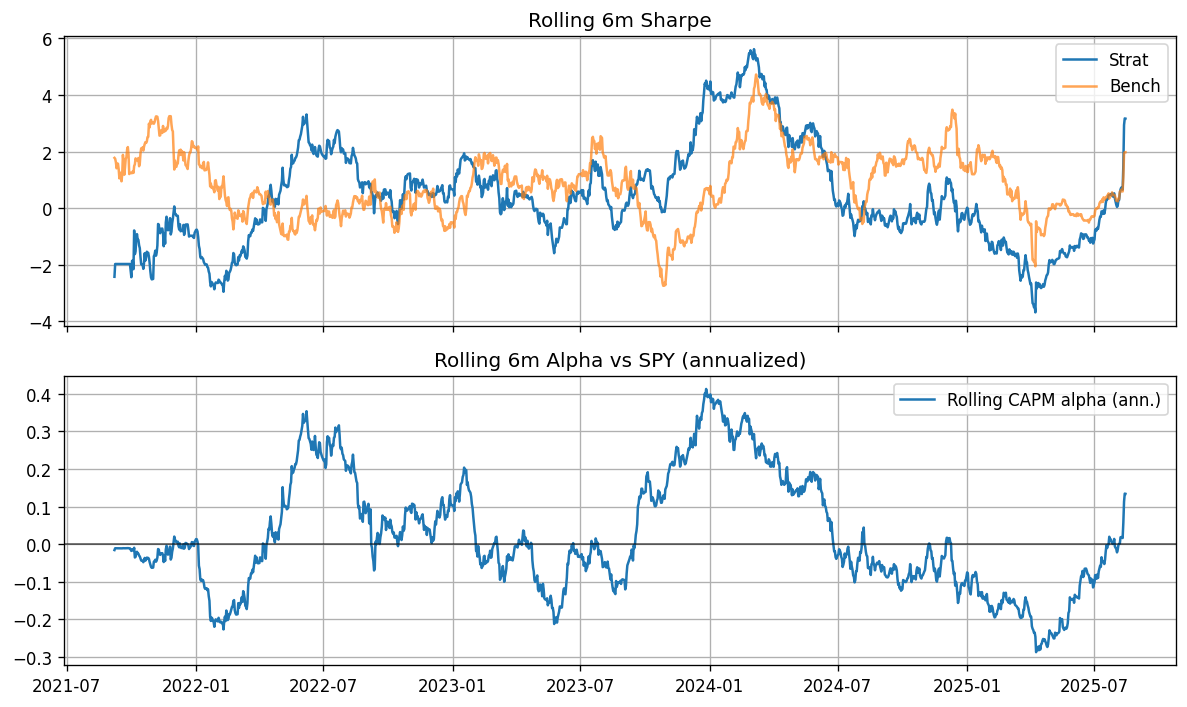

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import linregress

strat = (port_rets_ra if 'port_rets_ra' in globals() else strategy_returns).dropna()
bench = (bench_ra    if 'bench_ra'    in globals() else bench).reindex(strat.index).fillna(0.0)

win = 126
def roll_sharpe(x):
    s = x.std(ddof=0)
    return 0.0 if s==0 else np.sqrt(252)*x.mean()/s

rs_strat = strat.rolling(win).apply(roll_sharpe, raw=False)
rs_bench = bench.rolling(win).apply(roll_sharpe, raw=False)

def roll_alpha(y, x):
    yv, xv = y.values, x.values
    if np.isfinite(yv).sum()<40 or np.isfinite(xv).sum()<40: return np.nan
    slope, intercept, *_ = linregress(xv, yv)
    return intercept*252

ra = pd.Series(index=strat.index, dtype=float)
for i in range(win, len(strat)+1):
    seg = strat.iloc[i-win:i]
    mkt = bench.iloc[i-win:i]
    ra.iloc[i-1] = roll_alpha(seg, mkt)

fig, ax = plt.subplots(2,1, figsize=(10,6), dpi=120, sharex=True)
ax[0].plot(rs_strat.index, rs_strat, label='Strat')
ax[0].plot(rs_bench.index, rs_bench, label='Bench', alpha=0.7)
ax[0].set_title('Rolling 6m Sharpe'); ax[0].grid(True); ax[0].legend()

ax[1].plot(ra.index, ra, label='Rolling CAPM alpha (ann.)')
ax[1].axhline(0, color='k', lw=1, alpha=0.6)
ax[1].set_title('Rolling 6m Alpha vs SPY (annualized)'); ax[1].grid(True); ax[1].legend()
plt.tight_layout(); plt.show()


In [ ]:
REGIME_PARAMS = {
    0: dict(kappa=3.5, tau=8.0,  target_vol=0.10, cap_equity=0.08, cap_def=0.22, mix=0.65),
    1: dict(kappa=3.0, tau=7.0,  target_vol=0.10, cap_equity=0.08, cap_def=0.22, mix=0.65),
    2: dict(kappa=4.0, tau=8.0,  target_vol=0.09, cap_equity=0.06, cap_def=0.25, mix=0.70),
    3: dict(kappa=1.8, tau=4.0,  target_vol=0.13, cap_equity=0.15, cap_def=0.18, mix=0.60),
    4: dict(kappa=1.5, tau=3.0,  target_vol=0.14, cap_equity=0.15, cap_def=0.18, mix=0.60),
    5: dict(kappa=1.2, tau=2.5,  target_vol=0.15, cap_equity=0.17, cap_def=0.18, mix=0.55),
}

_DEFAULT_REGIME = dict(kappa=RISK_AVERSION, tau=TURNOVER_PENALTY, target_vol=TARGET_ANN_VOL,
                       cap_equity=MAX_WEIGHT_PER_ASSET, cap_def=MAX_WEIGHT_PER_ASSET, mix=TURNOVER_MIX)


def get_regime_params(date: pd.Timestamp):
    if not REGIME_USE or 'regime_df' not in globals() or regime_df.empty:
        return _DEFAULT_REGIME.copy()
    if date in regime_df.index:
        code = int(regime_df.loc[date, 'regime_code'])
    else:
        i = regime_df.index.searchsorted(date) - 1
        code = int(regime_df['regime_code'].iloc[i]) if i >= 0 else 4
    p = REGIME_PARAMS.get(code, _DEFAULT_REGIME)
    out = _DEFAULT_REGIME.copy(); out.update(p)
    out['code'] = code
    return out


def _cap_for_asset(t: str, cap_e: float, cap_d: float) -> float:
    if t in DEFENSIVE_LIKE: return cap_d
    if t in EQUITY_LIKE or t in CRYPTO_LIKE or t in COMMODITY_RISKY: return cap_e
    return MAX_WEIGHT_PER_ASSET


def apply_caps_by_type(w: pd.Series, cap_equity: float, cap_def: float) -> pd.Series:
    if w.empty: return w
    capped = w.copy()
    for t in capped.index:
        cap = _cap_for_asset(t, cap_equity, cap_def)
        lo = -cap if ALLOW_SHORT else 0.0
        hi = cap
        capped[t] = float(np.clip(capped[t], lo, hi))
    gross = capped.abs().sum()
    if gross > 0:
        capped = capped / gross
    return capped


def apply_vol_target_series(port_ret: pd.Series, target_series: pd.Series, window: int = 60,
                            max_gross_leverage: float = MAX_GROSS_LEVERAGE) -> pd.Series:
    rvol = port_ret.rolling(window).std(ddof=0) * np.sqrt(TRADING_DAYS)
    scale = (target_series / rvol).clip(upper=max_gross_leverage).replace([np.inf, -np.inf], np.nan).fillna(1.0)
    return port_ret * scale

/tmp/ipython-input-4024299816.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)


Rebalance 12/58 @ 2021-09-30 | Regime=5 kappa=1.2 tau=2.5 TV=15%
Rebalance 24/58 @ 2022-09-30 | Regime=2 kappa=4.0 tau=8.0 TV=9%
Rebalance 36/58 @ 2023-09-30 | Regime=4 kappa=1.5 tau=3.0 TV=14%
Rebalance 48/58 @ 2024-09-30 | Regime=3 kappa=1.8 tau=4.0 TV=13%

Enhanced Regime-Params Backtest
Strategy (RA-params): CAGR 11.04%, Vol 11.34%, Sharpe 0.98, MaxDD -14.50%
Benchmark (SPY): CAGR 8.03%, Vol 13.55%, Sharpe 0.64, MaxDD -18.70%


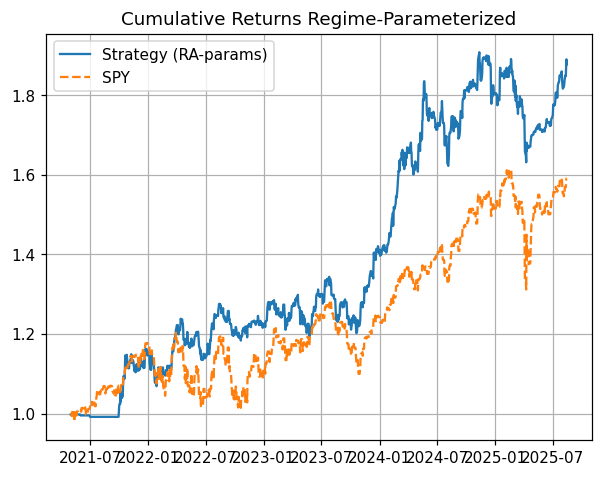

In [ ]:
import inspect

def _opt_qp_with_params(scores, hr, w_prev, kappa, tau):
    if 'optimize_weights_qp' not in globals() or not _HAS_CVXPY:
        return weight_from_scores(scores, hr)
    sig = inspect.signature(optimize_weights_qp)
    if 'kappa' in sig.parameters or 'tau' in sig.parameters:
        return optimize_weights_qp(scores, hr, w_prev, kappa=kappa, tau=tau)
    old_k = globals().get('RISK_AVERSION', 2.0)
    old_t = globals().get('TURNOVER_PENALTY', 0.0)
    try:
        globals()['RISK_AVERSION'] = kappa
        globals()['TURNOVER_PENALTY'] = tau
        return optimize_weights_qp(scores, hr, w_prev)
    finally:
        globals()['RISK_AVERSION'] = old_k
        globals()['TURNOVER_PENALTY'] = old_t

def _target_series_for(idxs: pd.DatetimeIndex) -> pd.Series:
    if ('regime_df' not in globals()) or regime_df.empty:
        return pd.Series(TARGET_ANN_VOL, index=idxs, dtype=float)
    codes = regime_df.reindex(idxs)['regime_code'].ffill().bfill()
    codes = codes.fillna(4).astype(int)
    tv_map = {k: v.get('target_vol', TARGET_ANN_VOL) for k, v in REGIME_PARAMS.items()}
    return codes.map(tv_map).fillna(TARGET_ANN_VOL).astype(float).reindex(idxs)

def _get_scores(date, model_or_models):
    if 'compute_signal_scores_v2' in globals():
        s = compute_signal_scores_v2(date, model_or_models)
        if s is None or len(s) == 0:
            s = compute_signal_scores_fast(date, model_or_models)
    else:
        s = compute_signal_scores_fast(date, model_or_models)
    return s

def backtest_with_regime_params(model_or_models, freq: str = 'M'):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)

    rets = prices.pct_change(fill_method=None).fillna(0.0)
    fees = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
            for t in TRADEABLE_ACTIVE}

    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        p = get_regime_params(d)
        kappa, tau = float(p['kappa']), float(p['tau'])
        cap_e, cap_d, mix = float(p['cap_equity']), float(p['cap_def']), float(p['mix'])

        s = _get_scores(d, model_or_models)
        available = s.index.intersection(rets.columns)
        if available.empty:
            continue

        hr = rets[available].loc[:d]

        if globals().get('USE_QP', False) and _HAS_CVXPY:
            w_target = _opt_qp_with_params(s.loc[available], hr, current_w.reindex(available).fillna(0.0),
                                           kappa=kappa, tau=tau)
        else:
            adj_scores = s.loc[available] / max(kappa, 1e-6)
            w_target = weight_from_scores(adj_scores, hr)

        w_target = apply_caps_by_type(w_target, cap_equity=cap_e, cap_def=cap_d)
        if 'regime_adjust_weights' in globals():
            w_target = regime_adjust_weights(d, w_target)

        w_target = (mix * w_target + (1.0 - mix) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        txn_cost = float((w_target - current_w.reindex(available).fillna(0.0))
                         .abs().reindex(available)
                         .mul(pd.Series(fees)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns); current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        i0 = rets.index.get_loc(d)
        if i < len(rebal_dates) - 1:
            next_d = rebal_dates[i+1]
            gi = rets.index.searchsorted(next_d, side='left')
            gi = max(gi, i0 + 1)
            next_cut = rets.index[min(gi, len(rets.index) - 1)]
        else:
            next_cut = rets.index[-1]

        rng = rets.index[(i0 + 1): rets.index.get_loc(next_cut)]
        if len(rng) == 0:
            continue
        slice_port = (rets.loc[rng, available] * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= txn_cost
        port_rets.append(slice_port)

        if (i % 12) == 0:
            print(f"Rebalance {i}/{len(rebal_dates)-1} @ {d.date()} | Regime={p.get('code', '?')} "
                  f"kappa={kappa} tau={tau} TV={p['target_vol']:.0%}")

    if not port_rets:
        raise RuntimeError("No returns computed; check dates/universe/lookback")
    port_rets = pd.concat(port_rets).sort_index()

    target_series = _target_series_for(port_rets.index)
    port_rets_vt = apply_vol_target_series(port_rets, target_series)

    bench_ret = price_wide[BENCHMARK].reindex(port_rets_vt.index).pct_change(fill_method=None).fillna(0.0)
    weights_df = pd.DataFrame(weights_hist)
    return port_rets_vt.rename('STRAT_RA'), weights_df, bench_ret.rename('BENCH')

port_rets_ra2, weights_df_ra2, bench_ra2 = backtest_with_regime_params(final_model, freq='M')

def _report(perf, name):
    cagr = (1+perf).prod()**(TRADING_DAYS/len(perf)) - 1
    vol  = perf.std(ddof=0)*np.sqrt(TRADING_DAYS)
    shrp = 0 if perf.std(ddof=0)==0 else np.sqrt(TRADING_DAYS)*perf.mean()/perf.std(ddof=0)
    dd   = ((1+perf).cumprod()/(1+perf).cumprod().cummax() - 1).min()
    print(f"{name}: CAGR {cagr:.2%}, Vol {vol:.2%}, Sharpe {shrp:.2f}, MaxDD {dd:.2%}")

print("\nEnhanced Regime-Params Backtest")
_report(port_rets_ra2, "Strategy (RA-params)")
_report(bench_ra2.reindex_like(port_rets_ra2).fillna(0.0), f"Benchmark ({BENCHMARK})")

plt.figure(dpi=110)
plt.plot((1+port_rets_ra2).cumprod(), label='Strategy (RA-params)')
plt.plot((1+bench_ra2).cumprod(), label=BENCHMARK, linestyle='--')
plt.title('Cumulative Returns Regime-Parameterized')
plt.grid(True); plt.legend(); plt.show()



Strategy (port_rets_ra2)
  Period   : 2021-05-01 → 2025-08-14
  CAGR     :  11.04%
  Ann.Vol  :  11.34%
  Sharpe   :  0.98
  MaxDD    : -14.50%
  Turnover(mean/reb): 0.466

Benchmark (bench_ra2)
  Period   : 2021-05-01 → 2025-08-14
  CAGR     :  8.03%
  Ann.Vol  :  13.55%
  Sharpe   :  0.64
  MaxDD    : -18.70%
  Turnover(mean/reb): 0.466


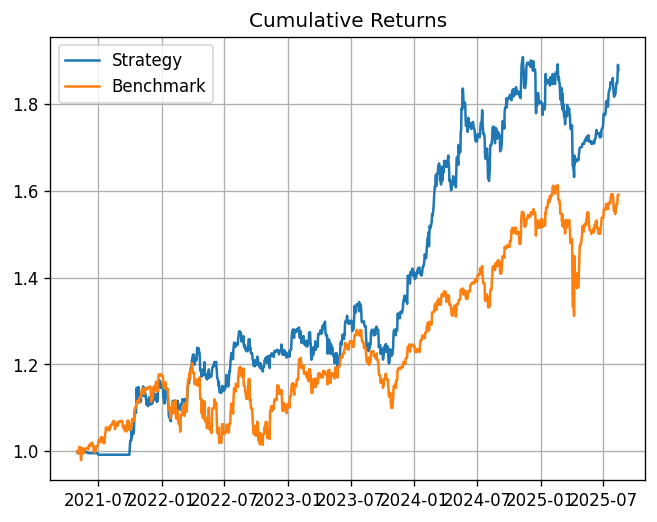

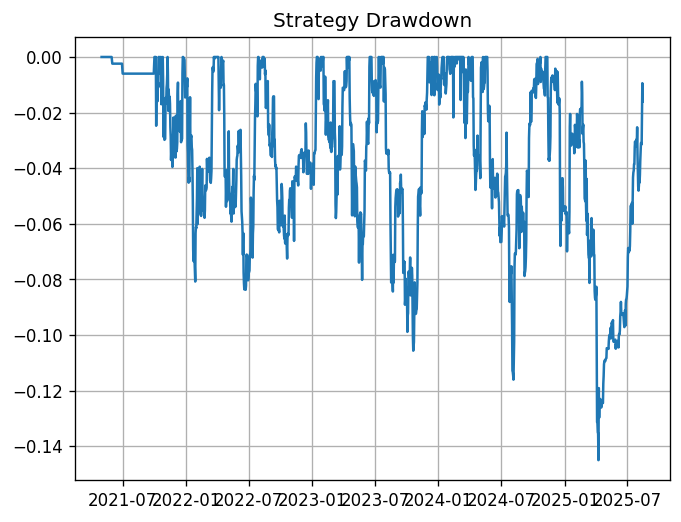

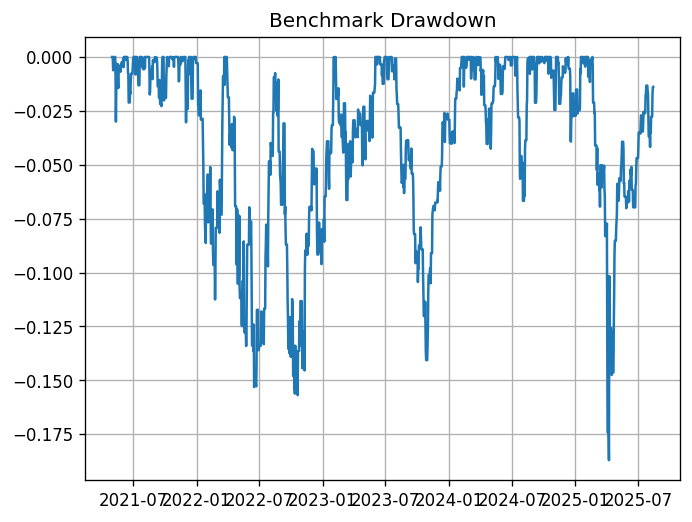

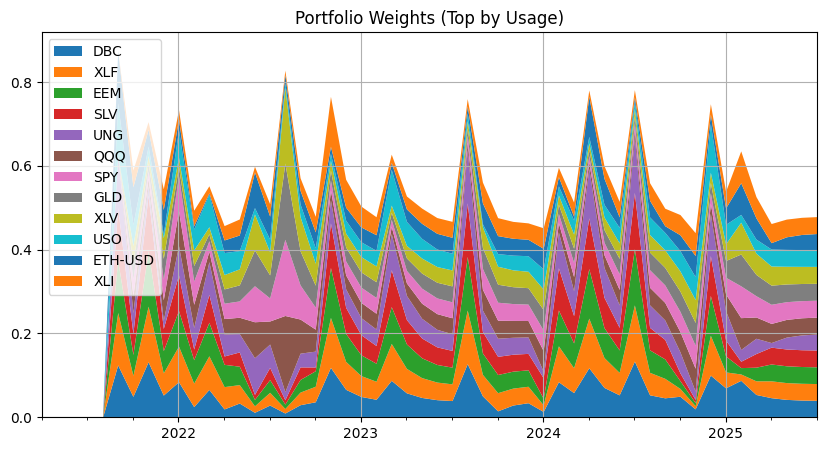

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _pick(cands):
    for n in cands:
        if n in globals() and globals()[n] is not None:
            return n, globals()[n]
    raise NameError(f"No available variable among {cands}")

sname, strat = _pick([
    'port_rets_ra2','port_rets_ra','port_rets_qp','port_rets2',
    'port_rets_fast','port_rets','strategy_returns'
])
bname, benchX = _pick([
    'bench_ra2','bench_ra','bench_qp','bench2','bench_fast','bench'
])
wname, wdf = (None, pd.DataFrame())
for n in ['weights_df_ra2','weights_df_ra','weights_df_qp','weights_df2','weights_df_fast','weights_df']:
    if n in globals() and globals()[n] is not None:
        wname, wdf = n, globals()[n]; break

strat = pd.to_numeric(pd.Series(strat).dropna(), errors='coerce').dropna()
bench_ser = benchX.squeeze() if isinstance(benchX, (pd.DataFrame,)) else pd.Series(benchX)
bench_ser = pd.to_numeric(bench_ser, errors='coerce')

bench_ret = bench_ser.copy()
if bench_ret.abs().max() > 5:
    bench_ret = bench_ret.pct_change(fill_method=None)
bench_ret = bench_ret.reindex(strat.index).fillna(0.0)

TRADING_DAYS = 252

def ann_vol(returns): return returns.std(ddof=0) * np.sqrt(TRADING_DAYS)
def sharpe(returns, rf=0.0):
    ex = returns - rf/TRADING_DAYS
    v  = returns.std(ddof=0)
    return 0.0 if v==0 else np.sqrt(TRADING_DAYS)*ex.mean()/v
def max_drawdown(cum):
    peak = cum.cummax()
    dd = cum/peak - 1.0
    return dd.min()

def report(perf: pd.Series, name: str):
    perf = pd.to_numeric(perf, errors='coerce').dropna()
    cagr = (1+perf).prod()**(TRADING_DAYS/len(perf)) - 1
    md = max_drawdown((1+perf).cumprod())
    print(f"\n{name}")
    print(f"  Period   : {perf.index.min().date()} → {perf.index.max().date()}")
    print(f"  CAGR     : {cagr: .2%}")
    print(f"  Ann.Vol  : {ann_vol(perf): .2%}")
    print(f"  Sharpe   : {sharpe(perf): .2f}")
    print(f"  MaxDD    : {md: .2%}")
    if isinstance(wdf, pd.DataFrame) and not wdf.empty:
        to = wdf.diff().abs().sum(axis=1).mean()
        print(f"  Turnover(mean/reb): {float(to):.3f}")

report(strat, f"Strategy ({sname})")
report(bench_ret, f"Benchmark ({bname})")

cum_strat = (1+strat).cumprod(); cum_bench = (1+bench_ret).cumprod()
plt.figure(dpi=120); plt.plot(cum_strat, label='Strategy'); plt.plot(cum_bench, label='Benchmark')
plt.title('Cumulative Returns'); plt.legend(); plt.grid(True); plt.show()

for name, series in [('Strategy', cum_strat), ('Benchmark', cum_bench)]:
    dd = series/series.cummax()-1
    plt.figure(dpi=120); plt.plot(dd, label=f'{name} Drawdown')
    plt.title(f'{name} Drawdown'); plt.grid(True); plt.show()

if isinstance(wdf, pd.DataFrame) and not wdf.empty:
    top = wdf.abs().mean().sort_values(ascending=False).head(12).index
    w_plot = wdf[top].fillna(0.0)
    ax = w_plot.plot(kind='area', figsize=(10,5), linewidth=0)
    ax.set_title('Portfolio Weights (Top by Usage)')
    plt.grid(True); plt.show()



Monte Carlo (block bootstrap) port_rets_ra2
  Median CAGR  : 10.93%
  5–95% CAGR   : 2.59% .. 19.61%
  Median Sharpe: 0.97


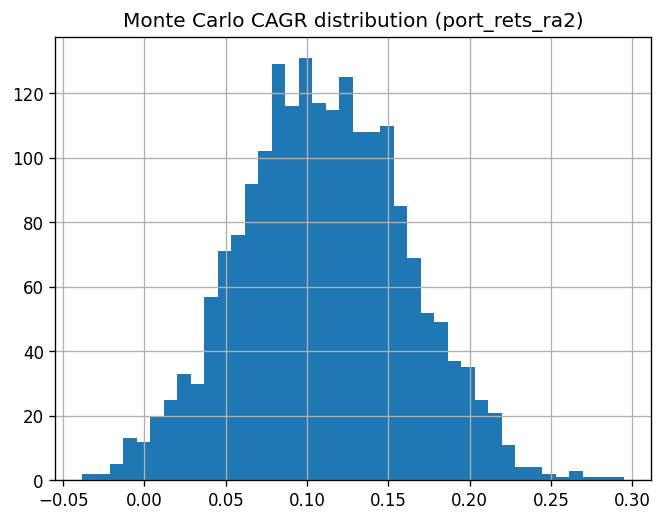

In [ ]:
import numpy as np, pandas as pd, numpy.random as npr, matplotlib.pyplot as plt

def _pick_series(cands):
    for n in cands:
        if n in globals() and globals()[n] is not None:
            s = pd.Series(globals()[n]).dropna()
            if len(s) > 10:
                return n, s
    raise NameError("No usable strategy return series found")

sname, strat = _pick_series([
    'port_rets_ra2','port_rets_ra','port_rets_qp','port_rets2',
    'port_rets_fast','port_rets','strategy_returns'
])

TRADING_DAYS = globals().get('TRADING_DAYS', 252)
PLOT_DPI = globals().get('PLOT_DPI', 110)

def block_bootstrap(series: pd.Series, block_len: int = 5, n_paths: int = 2000, seed: int = 123):
    x = pd.to_numeric(series, errors='coerce').dropna().values
    T = len(x)
    if T < 8:
        raise ValueError(f"Series too short for bootstrap (len={T})")
    block_len = int(np.clip(block_len, 2, max(2, min(21, T//4))))
    blocks = [x[i:i+block_len] for i in range(0, T - block_len + 1)]
    B = len(blocks)
    rng = npr.default_rng(seed)
    out = np.zeros((n_paths, T), dtype=float)
    for s in range(n_paths):
        k = 0
        while k < T:
            b = blocks[rng.integers(low=0, high=B)]
            m = min(block_len, T - k)
            out[s, k:k+m] = b[:m]
            k += m
    return out

mc_paths = block_bootstrap(strat, block_len=5, n_paths=2000, seed=123)
mc_cum   = (1.0 + mc_paths).cumprod(axis=1)
mc_end   = mc_cum[:, -1]
mc_cagr  = np.power(mc_end, TRADING_DAYS / len(strat)) - 1.0
mc_sharpe= (mc_paths.mean(axis=1) * np.sqrt(TRADING_DAYS)) / (mc_paths.std(axis=1) + 1e-12)

print(f"\nMonte Carlo (block bootstrap) {sname}")
print(f"  Median CAGR  : {np.median(mc_cagr):.2%}")
print(f"  5–95% CAGR   : {np.percentile(mc_cagr,5):.2%} .. {np.percentile(mc_cagr,95):.2%}")
print(f"  Median Sharpe: {np.median(mc_sharpe):.2f}")

plt.figure(dpi=PLOT_DPI)
plt.hist(mc_cagr, bins=40)
plt.title(f'Monte Carlo CAGR distribution ({sname})')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np, pandas as pd

strat = globals().get('port_rets_ra', globals().get('strategy_returns'))
bench = globals().get('bench_ra',    globals().get('bench'))

assert strat is not None and bench is not None, "Need strategy (port_rets_ra/strategy_returns) and benchmark (bench_ra/bench)"

# Ensure 1D Series
if isinstance(strat, pd.DataFrame): strat = strat.squeeze()
if isinstance(bench, pd.DataFrame): bench = bench.squeeze()

bench = bench.copy()
if bench.abs().max() > 5:
    bench = bench.pct_change(fill_method=None)

df = pd.concat([pd.to_numeric(strat, errors='coerce'),
                pd.to_numeric(bench, errors='coerce').reindex_like(strat)],
               axis=1, keys=['s','b']).dropna()
assert len(df) > 5, "Not enough overlapping observations after alignment"

X = df['b'].values.reshape(-1,1)
y = df['s'].values

if X.std() == 0:
    raise ValueError("Benchmark variance is zero; beta/alpha undefined")

lr = LinearRegression(fit_intercept=True).fit(X, y)
beta = float(lr.coef_[0])
alpha_ann = float(lr.intercept_) * 252.0
resid = y - lr.predict(X)
te = resid.std(ddof=0) * np.sqrt(252.0)
ir = alpha_ann / (te + 1e-12)

print(f"Obs {len(df)} | Beta {beta:.2f} | Alpha {alpha_ann:.2%} | TE {te:.2%} | IR {ir:.2f}")


Obs 1516 | Beta 0.36 | Alpha 2.65% | TE 8.31% | IR 0.32


In [ ]:
import numpy as np, pandas as pd

TRADING_DAYS        = globals().get('TRADING_DAYS', 252)
GROSS_TARGET        = globals().get('GROSS_TARGET', 1.0)
MAX_WEIGHT_PER_ASSET= globals().get('MAX_WEIGHT_PER_ASSET', 0.15)
RISK_AVERSION       = globals().get('RISK_AVERSION', 2.0)
TURNOVER_PENALTY    = globals().get('TURNOVER_PENALTY', 0.0)
TURNOVER_MIX        = globals().get('TURNOVER_MIX', 1.0)
MAX_GROSS_LEVERAGE  = globals().get('MAX_GROSS_LEVERAGE', 1.0)
BENCHMARK           = globals().get('BENCHMARK', 'SPY')
ALLOW_SHORT         = globals().get('ALLOW_SHORT', False)
ETF_FEE_BPS         = globals().get('ETF_FEE_BPS', 0.0001)
FUTURES_FEE_BPS     = globals().get('FUTURES_FEE_BPS', 0.00005)
CRYPTO_FEE_BPS      = globals().get('CRYPTO_FEE_BPS', 0.0005)
REBALANCE_FREQ      = globals().get('REBALANCE_FREQ', 'M')
LOOKBACK            = globals().get('LOOKBACK', 32)

if 'to_returns' not in globals():
    def to_returns(x): return x.pct_change(fill_method=None).fillna(0.0)

if 'apply_vol_target' not in globals():
    def apply_vol_target(port_ret: pd.Series,
                         target_ann_vol: float = globals().get('TARGET_ANN_VOL', 0.10),
                         max_gross_leverage: float = MAX_GROSS_LEVERAGE) -> pd.Series:
        rv = port_ret.rolling(60).std(ddof=0) * np.sqrt(TRADING_DAYS)
        scale = (target_ann_vol / rv.replace(0, np.nan)).clip(upper=max_gross_leverage).fillna(1.0)
        return port_ret * scale

from sklearn.covariance import LedoitWolf
def _shrunk_cov(hr: pd.DataFrame, min_rows: int = 30, jitter: float = 1e-6) -> np.ndarray:
    R = hr.tail(60).fillna(0.0).values
    if R.shape[0] >= min_rows and R.shape[1] >= 1:
        try:
            C = LedoitWolf().fit(R).covariance_
        except Exception:
            C = np.cov(R, rowvar=False)
    else:
        std = hr.tail(60).std(ddof=0).fillna(0.0).values
        C = np.diag((std + 1e-8)**2)
    return C + jitter * np.eye(C.shape[0])

def _beta_vector_for_date(d: pd.Timestamp, assets: pd.Index, rets: pd.DataFrame,
                          bench_col: str = BENCHMARK, lookback: int = 252) -> pd.Series:
    if bench_col not in rets.columns:
        return pd.Series(0.0, index=assets)
    rb = rets[bench_col].loc[:d].tail(lookback).dropna()
    varb = rb.var(ddof=0)
    if varb <= 0 or len(rb) < 20:
        return pd.Series(0.0, index=assets)
    out = {}
    for a in assets:
        ra = rets[a].loc[:d].tail(lookback).dropna()
        common = ra.index.intersection(rb.index)
        out[a] = 0.0 if len(common) < 20 else ra.loc[common].cov(rb.loc[common]) / (rb.loc[common].var(ddof=0) + 1e-12)
    return pd.Series(out).reindex(assets).fillna(0.0)

if 'weight_from_scores' not in globals():
    def weight_from_scores(scores: pd.Series, hist_returns: pd.DataFrame,
                           allow_short: bool = ALLOW_SHORT,
                           max_abs: float = MAX_WEIGHT_PER_ASSET) -> pd.Series:
        if scores is None or len(scores) == 0: return pd.Series(dtype=float)
        vol = hist_returns.loc[:, scores.index].rolling(20).std(ddof=0).iloc[-1].replace(0, np.nan)
        adj = (scores / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        raw = np.tanh(adj) if allow_short else np.clip(adj, 0, None)
        w = raw.clip(lower=(-max_abs if allow_short else 0.0), upper=max_abs)
        g = w.abs().sum()
        if g > 0: w = w / g
        return w.sort_index()

if 'regime_adjust_weights' not in globals():
    def regime_adjust_weights(d, w): return w

def _get_scores(date, model_or_models):
    if 'compute_signal_scores_v2' in globals():
        s = compute_signal_scores_v2(date, model_or_models)
        if s is None or len(s) == 0:
            s = compute_signal_scores_fast(date, model_or_models)
    else:
        s = compute_signal_scores_fast(date, model_or_models)
    return s

try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception:
    _HAS_CVXPY = False

def optimize_weights_qp_te(scores: pd.Series,
                           hist_returns: pd.DataFrame,
                           w_prev: pd.Series,
                           lambda_te: float = 0.0,
                           b_target: pd.Series | None = None,
                           beta_target: float | None = None,
                           beta_band: tuple[float, float] | None = None,
                           asset_beta: pd.Series | None = None) -> pd.Series:
    if (scores is None) or (len(scores) == 0) or (not _HAS_CVXPY):
        return weight_from_scores(scores, hist_returns)

    assets = scores.index.tolist()
    hr = hist_returns.loc[:, assets].copy()
    w_prev = w_prev.reindex(assets).fillna(0.0)
    n = len(assets)
    mu = scores.values.astype(float)
    C  = _shrunk_cov(hr)

    if ALLOW_SHORT:
        w_plus  = cp.Variable(n, nonneg=True)
        w_minus = cp.Variable(n, nonneg=True)
        w       = w_plus - w_minus
    else:
        w = cp.Variable(n)

    obj = (RISK_AVERSION * cp.quad_form(w, C)
           - mu @ w
           + TURNOVER_PENALTY * cp.sum_squares(w - w_prev.values))

    if lambda_te > 0.0 and b_target is not None:
        b = b_target.reindex(assets).fillna(0.0).values
        obj = obj + lambda_te * cp.quad_form(w - b, C)

    cons = []
    if ALLOW_SHORT:
        cons += [cp.sum(cp.abs(w)) <= GROSS_TARGET + 1e-12]
        cons += [cp.abs(w) <= MAX_WEIGHT_PER_ASSET]
    else:
        cons += [cp.sum(w) == GROSS_TARGET, w >= 0, w <= MAX_WEIGHT_PER_ASSET]

    if asset_beta is not None:
        bet = asset_beta.reindex(assets).fillna(0.0).values
        if beta_band is not None:
            lo, hi = beta_band
            cons += [bet @ w >= lo, bet @ w <= hi]
        elif beta_target is not None:
            cons += [bet @ w == beta_target]

    prob = cp.Problem(cp.Minimize(obj), cons)

    solvers = []
    if 'SOLVER_PREF_ORDER' in globals():
        solvers += [s for s in SOLVER_PREF_ORDER]
    for s in [getattr(cp, 'OSQP', None), getattr(cp, 'CLARABEL', None), cp.SCS, cp.ECOS]:
        if s and s not in solvers: solvers.append(s)

    solved, w_val = False, None
    for s in solvers:
        try:
            kw = dict(warm_start=True, verbose=False)
            if getattr(s, '__name__', '') == 'OSQP': kw.update(polish=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=10000)
            if getattr(s, '__name__', '') == 'SCS':  kw.update(max_iters=20000, eps=1e-5)
            prob.solve(solver=s, **kw)
            if prob.status in ('optimal', 'optimal_inaccurate'):
                w_val = np.array(w.value).ravel() if not ALLOW_SHORT else (w_plus.value - w_minus.value).ravel()
                if np.all(np.isfinite(w_val)):
                    solved = True
                    break
        except Exception:
            continue

    if not solved:
        return weight_from_scores(scores, hr)

    w_ser = pd.Series(w_val, index=assets)
    gross = w_ser.abs().sum()
    if gross > 0: w_ser *= (GROSS_TARGET / gross)
    lo = (-MAX_WEIGHT_PER_ASSET if ALLOW_SHORT else 0.0)
    w_ser = w_ser.clip(lower=lo, upper=MAX_WEIGHT_PER_ASSET)
    if w_ser.abs().sum() > 0:
        w_ser = w_ser / w_ser.abs().sum() * GROSS_TARGET
    return w_ser

def backtest_te(model_or_models,
                lambda_te: float = 2.0,
                b_target_series: pd.Series | None = None,
                beta_target: float | None = None,
                beta_band: tuple[float, float] | None = (0.5, 0.8),
                freq: str = REBALANCE_FREQ):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)
    rets = prices.pct_change(fill_method=None).fillna(0.0)
    bench_ret = to_returns(price_wide[BENCHMARK])

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        scores = _get_scores(d, model_or_models)
        available = scores.index.intersection(rets.columns)
        if available.empty:
            continue

        if b_target_series is not None:
            b_vec = b_target_series.reindex(available).fillna(0.0)
            if b_vec.abs().sum() > 0:
                b_vec = b_vec / b_vec.abs().sum() * GROSS_TARGET
        else:
            b_vec = pd.Series(0.0, index=available)

        betas_vec = _beta_vector_for_date(d, available, rets.join(bench_ret, how='outer'), bench_col=BENCHMARK, lookback=252)

        if _HAS_CVXPY:
            w_target = optimize_weights_qp_te(scores.loc[available], rets[available].loc[:d],
                                              w_prev=current_w.reindex(available).fillna(0.0),
                                              lambda_te=lambda_te, b_target=b_vec,
                                              beta_target=beta_target, beta_band=beta_band,
                                              asset_beta=betas_vec)
        else:
            w_target = weight_from_scores(scores.loc[available], rets[available].loc[:d])

        w_target = regime_adjust_weights(d, w_target)
        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        txn_cost = float((w_target - current_w.reindex(available).fillna(0.0))
                         .abs().reindex(available)
                         .mul(pd.Series(fee)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns)
        current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        next_cut = rebal_dates[i + 1] if d != rebal_dates[-1] else rets.index[-1]
        if next_cut not in rets.index:
            gi = rets.index.searchsorted(next_cut, side='left')
            gi = max(gi, idx_pos + 1)
            next_cut = rets.index[min(gi, len(rets.index) - 1)]

        rng = rets.index[(idx_pos + 1): rets.index.get_loc(next_cut)]
        if len(rng) == 0:
            continue
        slice_port = (rets.loc[rng, available] * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= txn_cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed; check data window/LOOKBACK/features")
    port_rets = pd.concat(port_rets).sort_index()
    port_rets_vt = apply_vol_target(port_rets)

    bench_series = to_returns(price_wide[BENCHMARK].loc[port_rets_vt.index]).rename('BENCH')
    weights_df = pd.DataFrame(weights_hist)
    return port_rets_vt.rename('STRAT_TE'), weights_df, bench_series


In [ ]:
def _beta_vector_for_date(d: pd.Timestamp,
                          assets: pd.Index,
                          rets_assets: pd.DataFrame,
                          bench_series: pd.Series,
                          lookback: int = 252) -> pd.Series:
    rb = bench_series.loc[:d].tail(lookback).dropna()
    varb = float(rb.var(ddof=0))
    if (varb <= 0) or (len(rb) < 20):
        return pd.Series(0.0, index=assets)
    out = {}
    for a in assets:
        ra = rets_assets[a].loc[:d].tail(lookback).dropna()
        common = ra.index.intersection(rb.index)
        if len(common) < 20:
            out[a] = 0.0
        else:
            out[a] = float(ra.loc[common].cov(rb.loc[common]) / (rb.loc[common].var(ddof=0) + 1e-12))
    return pd.Series(out).reindex(assets).fillna(0.0)

def backtest_te(model_or_models,
                lambda_te: float = 2.0,
                b_target_series: pd.Series | None = None,
                beta_target: float | None = None,
                beta_band: tuple[float, float] | None = (0.5, 0.8),
                freq: str = REBALANCE_FREQ):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)
    rets = prices.pct_change(fill_method=None).fillna(0.0)
    bench_ret = to_returns(price_wide[BENCHMARK])

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    weights_hist, port_rets = [], []
    current_w = pd.Series(0.0, index=prices.columns)

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        scores = _get_scores(d, model_or_models)
        available = scores.index.intersection(rets.columns)
        if available.empty:
            continue

        if b_target_series is not None:
            b_vec = b_target_series.reindex(available).fillna(0.0)
            if b_vec.abs().sum() > 0:
                b_vec = b_vec / b_vec.abs().sum() * GROSS_TARGET
        else:
            b_vec = pd.Series(0.0, index=available)

        betas_vec = _beta_vector_for_date(d, available, rets, bench_ret, lookback=252)

        if _HAS_CVXPY:
            w_target = optimize_weights_qp_te(scores.loc[available], rets[available].loc[:d],
                                              w_prev=current_w.reindex(available).fillna(0.0),
                                              lambda_te=lambda_te, b_target=b_vec,
                                              beta_target=beta_target, beta_band=beta_band,
                                              asset_beta=betas_vec)
        else:
            w_target = weight_from_scores(scores.loc[available], rets[available].loc[:d])

        w_target = regime_adjust_weights(d, w_target)
        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        txn_cost = float((w_target - current_w.reindex(available).fillna(0.0))
                         .abs().reindex(available)
                         .mul(pd.Series(fee)).fillna(ETF_FEE_BPS).sum())

        current_w = pd.Series(0.0, index=prices.columns)
        current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        next_cut = rebal_dates[i + 1] if d != rebal_dates[-1] else rets.index[-1]
        if next_cut not in rets.index:
            gi = rets.index.searchsorted(next_cut, side='left')
            gi = max(gi, idx_pos + 1)
            next_cut = rets.index[min(gi, len(rets.index) - 1)]
        rng = rets.index[(idx_pos + 1): rets.index.get_loc(next_cut)]
        if len(rng) == 0:
            continue
        slice_port = (rets.loc[rng, available] * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= txn_cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed; check data window/LOOKBACK/features")

    port_rets = pd.concat(port_rets).sort_index()
    port_rets_vt = apply_vol_target(port_rets)

    bench_series = to_returns(price_wide[BENCHMARK].loc[port_rets_vt.index]).rename('BENCH')
    weights_df = pd.DataFrame(weights_hist)
    return port_rets_vt.rename('STRAT_TE'), weights_df, bench_series


In [ ]:
b_ref = pd.Series(0.0, index=pd.Index(TRADEABLE_ACTIVE, dtype='object'))
if 'SPY' in b_ref.index:
    b_ref.loc['SPY'] = 1.0
elif 'QQQ' in b_ref.index:
    b_ref.loc['QQQ'] = 1.0
else:
    eqs = [t for t in b_ref.index if 'SPY' in t or 'QQQ' in t or 'IWM' in t]
    if eqs:
        b_ref.loc[eqs] = 1.0/len(eqs)

LAMBDA_TE  = 2.0
BETA_BAND  = (0.5, 0.8)
FREQ       = 'M'

port_rets_te, weights_te, bench_te = backtest_te(final_model,
                                                 lambda_te=LAMBDA_TE,
                                                 b_target_series=b_ref,
                                                 beta_target=None,
                                                 beta_band=BETA_BAND,
                                                 freq=FREQ)

def _rep(x, name):
    TR = 252
    cagr = (1+x).prod()**(TR/len(x)) - 1
    vol  = x.std(ddof=0)*np.sqrt(TR)
    dd   = ((1+x).cumprod()/ (1+x).cumprod().cummax()-1).min()
    shrp = 0 if x.std(ddof=0)==0 else np.sqrt(TR)*x.mean()/x.std(ddof=0)
    print(f"{name}: Period {x.index.min().date()}→{x.index.max().date()} | "
          f"CAGR {cagr:.2%}, Vol {vol:.2%}, Sharpe {shrp:.2f}, MaxDD {dd:.2%}")

print("TE/Beta-controlled backtest complete")
_rep(port_rets_te, "Strategy TE/Beta")
_rep(bench_te.reindex_like(port_rets_te).fillna(0.0), f"Benchmark ({BENCHMARK})")


/tmp/ipython-input-3572516622.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)
/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate.

TE/Beta-controlled backtest complete
Strategy TE/Beta: Period 2021-05-01→2025-08-14 | CAGR 4.49%, Vol 10.72%, Sharpe 0.46, MaxDD -20.77%
Benchmark (SPY): Period 2021-05-01→2025-08-14 | CAGR 8.03%, Vol 13.55%, Sharpe 0.64, MaxDD -18.70%


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
def make_b_ref(mode='EW_equity'):
    assets = pd.Index(TRADEABLE_ACTIVE).intersection(price_wide.columns)
    w = pd.Series(0.0, index=assets)

    if mode == 'SPY':
        if 'SPY' in assets: w['SPY'] = 1.0

    elif mode == 'EW_equity':
        eq = [t for t in assets if t in EQUITY_LIKE]
        w[eq] = 1.0 / max(1, len(eq))

    elif mode == '6040':
        if 'SPY' in assets and 'IEF' in assets:
            w[['SPY','IEF']] = [0.60, 0.40]
        elif 'SPY' in assets and 'TLT' in assets:
            w[['SPY','TLT']] = [0.60, 0.40]
        else:
            w[assets] = 1.0 / len(assets)

    else:
        w[assets] = 1.0 / len(assets)

    return w

b_ref = make_b_ref('EW_equity')


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cvxpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

import numpy as np, pandas as pd

TRADING_DAYS = globals().get('TRADING_DAYS', 252)
FREQ = 'ME'

_cov_cache = {}
def _cov_key(hr_cols, end_idx):
    return (tuple(hr_cols), pd.Timestamp(end_idx))

from sklearn.covariance import LedoitWolf
def _shrunk_cov_cached(hr: pd.DataFrame, jitter=5e-5):
    if hr.empty:
        n = 1
        return np.eye(n)
    key = _cov_key(hr.columns, hr.index[-1])
    if key in _cov_cache:
        return _cov_cache[key]
    R = hr.tail(60).fillna(0.0).values
    try:
        C = LedoitWolf().fit(R).covariance_
    except Exception:
        C = np.cov(R, rowvar=False)
    C = C + jitter*np.eye(C.shape[0])
    _cov_cache[key] = C
    return C

def _cov_with_bench(hr: pd.DataFrame, bench: pd.Series):
    H = min(60, len(hr))
    if H < 10:
        n = hr.shape[1]
        return np.zeros(n), 1e-6
    A = hr.tail(H).values
    b = bench.reindex(hr.tail(H).index).fillna(0.0).values
    A_c = A - A.mean(axis=0, keepdims=True)
    b_c = b - b.mean()
    denom = max(H-1, 1)
    cov_ab = (A_c * b_c[:, None]).sum(axis=0) / denom
    var_b  = float((b_c @ b_c) / denom)
    return cov_ab, max(var_b, 1e-8)

def _get_scores(date, model_or_models):
    if 'compute_signal_scores_v2' in globals():
        s = compute_signal_scores_v2(date, model_or_models)
        if s is None or len(s)==0:
            s = compute_signal_scores_fast(date, model_or_models)
    else:
        s = compute_signal_scores_fast(date, model_or_models)
    return s

_HAS_CVXPY = False
try:
    import cvxpy as cp
    _HAS_CVXPY = True
    SOLVER_PREF = []
    try: import osqp;     SOLVER_PREF.append(cp.OSQP)
    except: pass
    SOLVER_PREF += [cp.SCS, cp.ECOS]
    OSQP_KW = dict(warm_start=True, polish=True, eps_abs=1e-5, eps_rel=1e-5, max_iter=4000, verbose=False)
    SCS_KW  = dict(warm_start=True, max_iters=6000, eps=5e-5, verbose=False)
except Exception:
    pass

def backtest_te(model_or_models,
                lambda_te: float,
                b_target_series: pd.Series,
                beta_target: float|None = None,
                beta_band: tuple[float,float] | None = None,
                freq: str = FREQ):

    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    if start_pos >= len(idx):
        raise RuntimeError("Not enough history")
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)

    rets = prices.pct_change(fill_method=None).fillna(0.0)
    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    w_hist, port_rets = [], []
    w_cur = pd.Series(0.0, index=prices.columns)

    for d in rebal_dates:
        if d not in rets.index:
            continue

        scores = _get_scores(d, model_or_models)
        avail = scores.index.intersection(rets.columns)
        if avail.empty:
            continue

        mu = scores.loc[avail].copy()
        rcode = compute_current_regime(d) if 'compute_current_regime' in globals() else 4
        if 'calibrators' in globals() and isinstance(calibrators, dict) and calibrators.get(rcode) is not None:
            mu = pd.Series(calibrators[rcode].predict(mu.values), index=mu.index)

        hist = rets[avail].loc[:d]
        if 'beta_neutralize' in globals():
            mu = beta_neutralize(mu, hist)

        C = _shrunk_cov_cached(hist)
        rb = b_target_series.reindex(hist.index).fillna(0.0)
        cov_ab, var_b = _cov_with_bench(hist, rb)

        kappa = globals().get('RISK_AVERSION', 2.0)
        tau   = globals().get('TURNOVER_PENALTY', 1.0)
        gross = globals().get('GROSS_TARGET', 1.0)
        cap   = globals().get('MAX_WEIGHT_PER_ASSET', 0.15)
        allow_short = globals().get('ALLOW_SHORT', False)

        solved = False
        n = len(avail); w_var = None

        if _HAS_CVXPY:
            w = cp.Variable(n)
            quad_term = (kappa + lambda_te) * cp.quad_form(w, C)
            lin_term  = - mu.values @ w - 2*lambda_te * (cov_ab @ w)
            turn_term = tau * cp.sum_squares(w - w_cur.reindex(avail).fillna(0.0).values)
            obj = cp.Minimize(quad_term + lin_term + turn_term)

            cons = [cp.norm1(w) <= gross]
            lo = -cap if allow_short else 0.0
            cons += [w <= cap, w >= lo]

            if beta_band is not None and var_b > 0:
                beta_vec = cov_ab / var_b
                cons += [ beta_vec @ w >= beta_band[0], beta_vec @ w <= beta_band[1] ]
            elif beta_target is not None and var_b > 0:
                beta_vec = cov_ab / var_b
                cons += [ beta_vec @ w == beta_target ]

            prob = cp.Problem(obj, cons)
            for s in SOLVER_PREF:
                try:
                    kw = OSQP_KW if s is cp.OSQP else (SCS_KW if s is cp.SCS else dict(verbose=False))
                    prob.solve(solver=s, **kw)
                    if prob.status in ("optimal","optimal_inaccurate"):
                        w_val = np.array(w.value).ravel()
                        if np.all(np.isfinite(w_val)):
                            w_var = pd.Series(w_val, index=avail)
                            solved = True
                            break
                except Exception:
                    continue

        if not solved:
            vol = hist.rolling(20).std(ddof=0).iloc[-1].replace(0, np.nan)
            adj = (mu / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
            w_var = np.tanh(adj) if allow_short else adj.clip(lower=0.0)

        if 'regime_adjust_weights' in globals():
            w_var = regime_adjust_weights(d, pd.Series(w_var, index=avail))
        mix = globals().get('TURNOVER_MIX', 1.0)
        w_var = (mix * w_var + (1.0 - mix) * w_cur.reindex(avail).fillna(0.0))
        if w_var.abs().sum() > 0:
            w_var = w_var / w_var.abs().sum() * gross

        cost = float((w_var - w_cur.reindex(avail).fillna(0.0)).abs()
                     .mul(pd.Series({t: fee.get(t, ETF_FEE_BPS) for t in avail})).sum())
        w_cur = pd.Series(0.0, index=prices.columns); w_cur.loc[avail] = w_var
        w_hist.append(w_cur.rename(d))

        idx_pos = rets.index.get_loc(d)
        if d != rebal_dates[-1]:
            nxt = rebal_dates[rebal_dates.get_loc(d)+1]
            gi  = rets.index.searchsorted(nxt)
            nxt = rets.index[min(gi, len(rets.index)-1)]
        else:
            nxt = rets.index[-1]
        rng = rets.index[(idx_pos+1): rets.index.get_loc(nxt)]
        if len(rng)==0:
            continue
        slice_port = (rets.loc[rng, avail] * w_cur.loc[avail]).sum(axis=1)
        if len(slice_port)>0:
            slice_port.iloc[0] -= cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed")
    pr = pd.concat(port_rets).sort_index()

    pr = apply_vol_target(pr).rename('STRAT_TE')

    bench = to_returns(price_wide[BENCHMARK].loc[pr.index]).rename('BENCH')
    wdf = pd.DataFrame(w_hist)
    return pr, wdf, bench


In [ ]:
from time import time
b_ref = to_returns(price_wide[BENCHMARK]).dropna()

grid = [(1.0, None), (0.8, (0.2, 1.2)), (1.5, (0.4, 1.0))]
rows = []
t0 = time()
for gi, (lam, band) in enumerate(grid, 1):
    print(f"[{gi}/{len(grid)}] lambda_te={lam}, beta_band={band}")
    pr, _, _ = backtest_te(final_model, lambda_te=lam, b_target_series=b_ref, beta_target=None, beta_band=band, freq='ME')
    vol = pr.std(ddof=0)*np.sqrt(252); shr = 0 if pr.std(ddof=0)==0 else np.sqrt(252)*pr.mean()/pr.std(ddof=0)
    cagr = (1+pr).prod()**(252/len(pr)) - 1
    mdd = ((1+pr).cumprod()/(1+pr).cumprod().cummax()-1).min()
    rows.append(dict(lambda_te=lam, beta_band=band, CAGR=cagr, Vol=vol, Sharpe=shr, MaxDD=mdd, Obs=len(pr)))
pd.DataFrame(rows).sort_values('Sharpe', ascending=False)
print(f"Done in {time()-t0:.1f}s")


[1/3] lambda_te=1.0, beta_band=None
[2/3] lambda_te=0.8, beta_band=(0.2, 1.2)
[3/3] lambda_te=1.5, beta_band=(0.4, 1.0)
Done in 978.0s


In [ ]:
LAM_BY_REG = {0:2.0, 1:1.8, 2:2.0, 3:0.8, 4:0.6, 5:0.6}

def backtest_te_regime_lambda(model_or_models,
                              b_target_series=None,
                              beta_band=(0.3, 1.1),
                              freq='ME'):

    import numpy as np, pandas as pd

    if b_target_series is None:
        b_target_series = to_returns(price_wide[BENCHMARK]).dropna()

    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    if start_pos >= len(idx):
        raise RuntimeError("Not enough history for backtest")
    start_date = idx[start_pos]
    rebal_dates = pd.date_range(start_date, idx[-1], freq=freq)

    rets = prices.pct_change(fill_method=None).fillna(0.0)

    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    w_hist, port_rets = [], []
    w_cur = pd.Series(0.0, index=prices.columns)

    for d in rebal_dates:
        if d not in rets.index:
            continue

        scores = _get_scores(d, model_or_models)
        avail = scores.index.intersection(rets.columns)
        if avail.empty:
            continue

        rc = compute_current_regime(d) if 'compute_current_regime' in globals() else 4
        lambda_te = LAM_BY_REG.get(int(rc), 1.0)

        mu = scores.loc[avail].copy()
        if 'calibrators' in globals() and isinstance(calibrators, dict) and calibrators.get(int(rc)) is not None:
            mu = pd.Series(calibrators[int(rc)].predict(mu.values), index=mu.index)

        hist = rets[avail].loc[:d]
        if 'beta_neutralize' in globals():
            mu = beta_neutralize(mu, hist)

        C = _shrunk_cov_cached(hist)
        rb = b_target_series.reindex(hist.index).fillna(0.0)
        cov_ab, var_b = _cov_with_bench(hist, rb)

        kappa = globals().get('RISK_AVERSION', 2.0)
        tau   = globals().get('TURNOVER_PENALTY', 1.0)
        gross = globals().get('GROSS_TARGET', 1.0)
        cap   = globals().get('MAX_WEIGHT_PER_ASSET', 0.15)
        allow_short = globals().get('ALLOW_SHORT', False)

        solved = False
        n = len(avail); w_var = None

        if '_HAS_CVXPY' in globals() and _HAS_CVXPY:
            import cvxpy as cp
            w = cp.Variable(n)
            quad_term = (kappa + lambda_te) * cp.quad_form(w, C)
            lin_term  = - mu.values @ w - 2*lambda_te * (cov_ab @ w)
            turn_term = tau * cp.sum_squares(w - w_cur.reindex(avail).fillna(0.0).values)
            obj = cp.Minimize(quad_term + lin_term + turn_term)

            lo = -cap if allow_short else 0.0
            cons = [cp.norm1(w) <= gross, w <= cap, w >= lo]

            if (beta_band is not None) and (var_b > 0):
                beta_vec = cov_ab / var_b
                cons += [ beta_vec @ w >= beta_band[0], beta_vec @ w <= beta_band[1] ]

            prob = cp.Problem(obj, cons)
            for s in SOLVER_PREF:
                try:
                    kw = OSQP_KW if getattr(s, "__name__", "") == "OSQP" else (SCS_KW if getattr(s, "__name__", "") == "SCS" else dict(verbose=False))
                    prob.solve(solver=s, **kw)
                    if prob.status in ("optimal","optimal_inaccurate"):
                        w_val = np.array(w.value).ravel()
                        if np.all(np.isfinite(w_val)):
                            w_var = pd.Series(w_val, index=avail); solved = True
                            break
                except Exception:
                    continue

        if not solved:
            vol = hist.rolling(20).std(ddof=0).iloc[-1].replace(0, np.nan)
            adj = (mu / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
            w_var = np.tanh(adj) if allow_short else adj.clip(lower=0.0)
            w_var = pd.Series(w_var, index=avail)

        if 'regime_adjust_weights' in globals():
            w_var = regime_adjust_weights(d, w_var)
        mix = globals().get('TURNOVER_MIX', 1.0)
        w_var = (mix * w_var + (1.0 - mix) * w_cur.reindex(avail).fillna(0.0))
        if w_var.abs().sum() > 0:
            w_var = w_var / w_var.abs().sum() * gross

        cost = float((w_var - w_cur.reindex(avail).fillna(0.0)).abs()
                     .mul(pd.Series({t: fee.get(t, ETF_FEE_BPS) for t in avail})).sum())
        w_cur = pd.Series(0.0, index=prices.columns); w_cur.loc[avail] = w_var
        w_hist.append(w_cur.rename(d))

        idx_pos = rets.index.get_loc(d)
        if d != rebal_dates[-1]:
            nxt = rebal_dates[rebal_dates.get_loc(d)+1]
            gi  = rets.index.searchsorted(nxt)
            nxt = rets.index[min(gi, len(rets.index)-1)]
        else:
            nxt = rets.index[-1]
        rng = rets.index[(idx_pos+1): rets.index.get_loc(nxt)]
        if len(rng)==0:
            continue
        slice_port = (rets.loc[rng, avail] * w_cur.loc[avail]).sum(axis=1)
        if len(slice_port)>0:
            slice_port.iloc[0] -= cost
        port_rets.append(slice_port)

    if not port_rets:
        raise RuntimeError("No returns computed")
    pr = pd.concat(port_rets).sort_index()
    pr_vt = apply_vol_target(pr).rename('STRAT_TE_RA')
    bench = to_returns(price_wide[BENCHMARK].loc[pr_vt.index]).rename('BENCH')
    return pr_vt, pd.DataFrame(w_hist), bench

try:
    b_ref
except NameError:
    b_ref = to_returns(price_wide[BENCHMARK]).dropna()

port_rets_te_ra, weights_te_ra, bench_te_ra = backtest_te_regime_lambda(
    final_model, b_target_series=b_ref, beta_band=(0.3, 1.1), freq='ME'
)


In [ ]:
def _rep(x, name):
    cagr = (1+x).prod()**(252/len(x)) - 1
    vol  = x.std(ddof=0)*np.sqrt(252)
    dd   = ((1+x).cumprod()/(1+x).cumprod().cummax()-1).min()
    shrp = 0 if x.std(ddof=0)==0 else np.sqrt(252)*x.mean()/x.std(ddof=0)
    print(f"{name}: CAGR {cagr:.2%}, Vol {vol:.2%}, Sharpe {shrp:.2f}, MaxDD {dd:.2%}")

_rep(port_rets_te_ra, "Strategy TE/Beta (RA-λ)")
_rep(bench_te_ra.reindex_like(port_rets_te_ra).fillna(0.0), f"Benchmark ({BENCHMARK})")


Strategy TE/Beta (RA-λ): CAGR 8.41%, Vol 11.25%, Sharpe 0.77, MaxDD -15.17%
Benchmark (SPY): CAGR 8.03%, Vol 13.55%, Sharpe 0.64, MaxDD -18.70%


In [ ]:
import numpy as np, pandas as pd
from scipy.stats import linregress

TRADING_DAYS = 252

def realized_beta_te(port: pd.Series, bench: pd.Series, ref: pd.Series | None = None):
    df = pd.DataFrame({
        "p": pd.to_numeric(port,  errors="coerce"),
        "b": pd.to_numeric(bench, errors="coerce"),
    }).dropna()
    out = {}

    if df.empty:
        out.update(beta=np.nan, TE=np.nan, alpha_ann=np.nan, IR=np.nan, n=0)
    else:
        lr = linregress(df["b"].values, df["p"].values)
        beta = float(lr.slope)

        te = float((df["p"] - df["b"]).std(ddof=0) * np.sqrt(TRADING_DAYS))

        alpha_ann = float((df["p"] - beta*df["b"]).mean() * TRADING_DAYS)
        ir = float(alpha_ann / (te + 1e-12))

        out.update(beta=beta, TE=te, alpha_ann=alpha_ann, IR=ir, n=int(len(df)))

    if ref is not None and isinstance(ref, pd.Series) and not ref.empty:
        out["ref_sum"] = float(ref.abs().sum())
    return out

port = globals().get("port_rets_te_ra", globals().get("port_rets_te"))
bench = globals().get("bench_te_ra",    globals().get("bench_te"))
assert port is not None and bench is not None, "No TE backtest series found"

try:
    print(realized_beta_te(port, bench, b_ref))
except NameError:
    print(realized_beta_te(port, bench))


{'beta': 0.5723995958954647, 'TE': 0.10000011647417167, 'alpha_ann': 0.037639006960047426, 'IR': 0.3763896312000051, 'n': 1516, 'ref_sum': 7.9216851651391735}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 114.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


/tmp/ipython-input-729026744.py:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(prices.index.min()+pd.Timedelta(days=LOOKBACK+1),
/tmp/ipython-input-729026744.py:154: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = pd.date_range(start_date, idx[-1], freq=REBALANCE_FREQ)


Rebalance 0/58 @ 2020-09-30 | Regime=1 kappa=3.0 tau=7.0 TV=10%
Rebalance 12/58 @ 2021-09-30 | Regime=5 kappa=1.2 tau=2.5 TV=15%
Rebalance 24/58 @ 2022-09-30 | Regime=2 kappa=4.0 tau=8.0 TV=9%
Rebalance 36/58 @ 2023-09-30 | Regime=4 kappa=1.8 tau=3.0 TV=13%
Rebalance 48/58 @ 2024-09-30 | Regime=3 kappa=1.5 tau=2.5 TV=14%

Enhanced Backtest (Regime-Calibrated + Uncertainty + Shrunk Cov + RA-QP)
Period   : 2021-10-01 → 2025-08-14
CAGR     :  8.27%
Ann.Vol  :  10.58%
Sharpe   :  0.80
MaxDD    : -12.57%
Turnover(mean/reb): 1.378


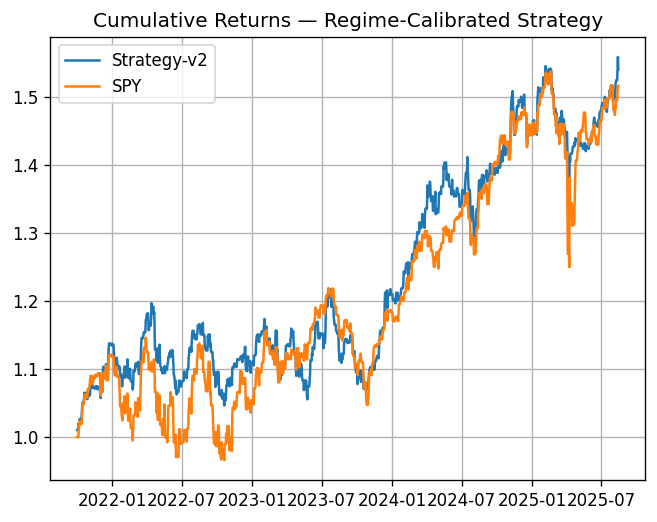

In [ ]:
!pip -q install scikit-learn==1.5.1
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.covariance import LedoitWolf

PLOT_DPI = globals().get('PLOT_DPI', 120)
REBALANCE_FREQ = globals().get('REBALANCE_FREQ', 'M')
REGIME_USE = globals().get('REGIME_USE', True)

CALIB_LOOKBACK_DAYS = 252
USE_BETA_NEUTRAL     = True
CLIP_Q_LOW, CLIP_Q_HIGH = 0.05, 0.95
MC_DROPOUT_PASSES    = 20
UNCERT_K             = 5.0

RA_PARAMS = {
    0: dict(kappa=3.0, tau=6.0,  tv=0.10),
    1: dict(kappa=3.0, tau=7.0,  tv=0.10),
    2: dict(kappa=4.0, tau=8.0,  tv=0.09),
    3: dict(kappa=1.5, tau=2.5,  tv=0.14),
    4: dict(kappa=1.8, tau=3.0,  tv=0.13),
    5: dict(kappa=1.2, tau=2.5,  tv=0.15),
}

try:
    INFER_FEATURES
except NameError:
    INFER_FEATURES = feature_names[:]

def _shrunk_cov(hist_returns: pd.DataFrame, jitter: float = 1e-6) -> np.ndarray:
    hr = hist_returns.tail(60).fillna(0.0).values
    if hr.size == 0:
        n = len(hist_returns.columns)
        return np.eye(n) * 1e-4
    try:
        lw = LedoitWolf().fit(hr)
        C = lw.covariance_
    except Exception:
        C = np.cov(hr, rowvar=False)
    n = C.shape[0]
    return C + jitter*np.eye(n)

def _choose_solver():
    import cvxpy as cp
    sols = []
    try:
        import osqp; sols.append(cp.OSQP)
    except Exception: pass
    try:
        import clarabel; sols.append(cp.CLARABEL)
    except Exception: pass
    sols += [cp.SCS, cp.ECOS]
    return sols

def compute_signal_scores_v2(date: pd.Timestamp, model_or_models) -> pd.Series:
    preds = {}
    for t in TRADEABLE_ACTIVE:
        if t not in tech_by_ticker:
            continue
        asset_df = tech_by_ticker[t].join(macro_df, how='left').ffill().bfill(limit=5).dropna()
        if len(asset_df) <= LOOKBACK:
            continue
        end_loc = asset_df.index.get_loc(date) if date in asset_df.index else asset_df.index.searchsorted(date) - 1
        if end_loc < LOOKBACK:
            continue
        window = asset_df.iloc[end_loc-LOOKBACK:end_loc]
        cols = [c for c in INFER_FEATURES if c in window.columns]
        if len(cols) != len(INFER_FEATURES):
            continue
        X = window[cols].values[np.newaxis, :, :]

        def mc_predict(models_list, X, n=MC_DROPOUT_PASSES):
            vals = []
            for _ in range(n):
                vals.append(np.mean([m(X, training=True).numpy().ravel()[0] for m in models_list]))
            arr = np.array(vals)
            return float(arr.mean()), float(arr.std())

        if isinstance(model_or_models, list):
            mean, std = mc_predict(model_or_models, X)
        elif REGIME_USE and isinstance(model_or_models, dict):
            code = compute_current_regime(asset_df.index[end_loc])
            mdl_list = model_or_models.get(code, next(iter(model_or_models.values())))
            mdl_list = mdl_list if isinstance(mdl_list, list) else [mdl_list]
            mean, std = mc_predict(mdl_list, X)
        else:
            yhat = model_or_models.predict(X, verbose=0).ravel()[0]
            mean, std = float(yhat), 0.0

        preds[t] = mean / (1.0 + UNCERT_K*std)

    s = pd.Series(preds).sort_index()
    if s.empty or s.std() == 0:
        return s
    s = (s - s.mean()) / (s.std() + 1e-9)
    lo, hi = s.quantile(CLIP_Q_LOW), s.quantile(CLIP_Q_HIGH)
    return s.clip(lo, hi)

def beta_neutralize(scores: pd.Series, rets_slice: pd.DataFrame) -> pd.Series:
    if not USE_BETA_NEUTRAL or 'SPY' not in rets_slice.columns or len(rets_slice) < 60:
        return scores
    spy = rets_slice['SPY']
    denom = (spy.rolling(60).var().iloc[-1] + 1e-12)
    betas = {}
    for c in scores.index:
        if c in rets_slice.columns:
            betas[c] = rets_slice[c].rolling(60).cov(spy).iloc[-1] / denom
    betas = pd.Series(betas).reindex(scores.index).fillna(0.0)
    return scores - betas * scores.get('SPY', 0.0)

def fit_calibrators(model_or_models):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    rebal_dates = pd.date_range(prices.index.min()+pd.Timedelta(days=LOOKBACK+1),
                                prices.index.max(), freq=REBALANCE_FREQ)
    if len(rebal_dates) == 0:
        return {}
    mask = rebal_dates >= (rebal_dates.max() - pd.Timedelta(days=CALIB_LOOKBACK_DAYS))
    cal_dates = rebal_dates[mask]
    pairs_by_regime = {r: {'x': [], 'y': []} for r in range(6)}
    for d in cal_dates:
        if d not in prices.index:
            continue
        s = compute_signal_scores_v2(d, model_or_models)
        if s.empty:
            continue
        fwd = (prices.shift(-HORIZON_DAYS).loc[d] / prices.loc[d] - 1.0).reindex(s.index)
        code = compute_current_regime(d) if REGIME_USE else 4
        good = s.index.intersection(fwd.dropna().index)
        if len(good) == 0:
            continue
        pairs_by_regime[code]['x'].extend(s.loc[good].values.tolist())
        pairs_by_regime[code]['y'].extend(fwd.loc[good].values.tolist())
    calibrators = {}
    for r in range(6):
        x, y = np.array(pairs_by_regime[r]['x']), np.array(pairs_by_regime[r]['y'])
        if len(x) >= 100 and np.std(x) > 0:
            iso = IsotonicRegression(out_of_bounds='clip')
            iso.fit(x, y)
            calibrators[r] = iso
        else:
            calibrators[r] = None
    return calibrators

calibrators = fit_calibrators(final_model)

def backtest_v2(model_or_models, verbose_every=12):
    prices = price_wide[TRADEABLE_ACTIVE].dropna(how='all')
    idx = prices.index
    start_pos = LOOKBACK + 1
    if start_pos >= len(idx):
        raise RuntimeError("Not enough history; reduce LOOKBACK or extend data")
    start_date = idx[start_pos]

    rebal_dates = pd.date_range(start_date, idx[-1], freq=REBALANCE_FREQ)
    rets = prices.pct_change(fill_method=None).fillna(0.0)
    fee = {t: (CRYPTO_FEE_BPS if t in CRYPTO_UNIVERSE else FUTURES_FEE_BPS if t in FUTURES_UNIVERSE else ETF_FEE_BPS)
           for t in TRADEABLE_ACTIVE}

    weights_hist, port_rets_raw, tv_series = [], [], []
    current_w = pd.Series(0.0, index=prices.columns)

    try:
        import cvxpy as cp
        SOLVERS = _choose_solver()
        _HAS_CVXPY = True
    except Exception:
        SOLVERS = []
        _HAS_CVXPY = False

    for i, d in enumerate(rebal_dates):
        if d not in rets.index:
            continue

        rcode = compute_current_regime(d) if REGIME_USE else 4
        pars  = RA_PARAMS.get(int(rcode), RA_PARAMS[4])
        kappa = pars['kappa']; tau = pars['tau']; tv = pars['tv']
        if (i % verbose_every) == 0:
            print(f"Rebalance {i}/{len(rebal_dates)-1} @ {d.date()} | Regime={rcode} kappa={kappa} tau={tau} TV={int(tv*100)}%")

        raw_scores = compute_signal_scores_v2(d, model_or_models)
        if raw_scores.empty:
            continue

        if calibrators.get(int(rcode)) is not None:
            mu = pd.Series(calibrators[int(rcode)].predict(raw_scores.values), index=raw_scores.index)
        else:
            mu = raw_scores

        available = mu.index
        hist = rets[available].loc[:d]
        mu = beta_neutralize(mu, hist)

        if _HAS_CVXPY and globals().get('USE_QP', True) and len(available) > 0:
            C = _shrunk_cov(hist)
            n = len(available)
            w = cp.Variable(n)
            obj = (kappa * cp.quad_form(w, C)
                   - mu.values @ w
                   + tau * cp.sum_squares(w - current_w.reindex(available).fillna(0.0).values))
            cons = [cp.norm1(w) <= GROSS_TARGET,
                    w <=  MAX_WEIGHT_PER_ASSET,
                    w >= (-MAX_WEIGHT_PER_ASSET if ALLOW_SHORT else 0)]
            prob = cp.Problem(cp.Minimize(obj), cons)

            w_val, solved = None, False
            for s in SOLVERS:
                try:
                    kw = dict(verbose=False, warm_start=True)
                    if s.__name__ == "OSQP":     kw.update(polish=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=8000)
                    if s.__name__ == "CLARABEL": kw.update(max_iter=10000, tol_gap_abs=1e-7, tol_gap_rel=1e-7)
                    if s.__name__ == "SCS":      kw.update(max_iters=20000, eps=1e-5)
                    prob.solve(solver=s, **kw)
                    if prob.status in ("optimal","optimal_inaccurate"):
                        w_val = np.array(w.value).ravel()
                        if np.all(np.isfinite(w_val)):
                            solved = True
                            break
                except Exception:
                    continue

            if solved and w_val is not None:
                w_target = pd.Series(w_val, index=available)
            else:
                vol = hist.rolling(20).std(ddof=0).iloc[-1].replace(0,np.nan)
                adj = (mu / vol).replace([np.inf,-np.inf], np.nan).fillna(0.0)
                w_target = np.tanh(adj) if ALLOW_SHORT else adj.clip(lower=0)
        else:
            vol = hist.rolling(20).std(ddof=0).iloc[-1].replace(0,np.nan)
            adj = (mu / vol).replace([np.inf,-np.inf], np.nan).fillna(0.0)
            w_target = np.tanh(adj) if ALLOW_SHORT else adj.clip(lower=0)

        w_target = regime_adjust_weights(d, pd.Series(w_target, index=available))
        w_target = (TURNOVER_MIX * w_target + (1.0 - TURNOVER_MIX) * current_w.reindex(available).fillna(0.0))
        if w_target.abs().sum() > 0:
            w_target = w_target / w_target.abs().sum()

        cost = (w_target - current_w.reindex(available).fillna(0.0)).abs()
        cost = float((cost * pd.Series({t: fee.get(t, ETF_FEE_BPS) for t in available})).sum())

        current_w = pd.Series(0.0, index=prices.columns)
        current_w.loc[available] = w_target
        weights_hist.append(current_w.rename(d))

        idx_pos = rets.index.get_loc(d)
        if d != rebal_dates[-1]:
            gi = rets.index.searchsorted(rebal_dates[i+1])
            next_cut = rets.index[min(gi, len(rets.index)-1)]
        else:
            next_cut = rets.index[-1]
        daily_slice = rets.index[(idx_pos + 1): rets.index.get_loc(next_cut)]
        if len(daily_slice) == 0:
            continue
        slice_rets = rets.loc[daily_slice, available]
        slice_port = (slice_rets * current_w.loc[available]).sum(axis=1)
        if len(slice_port) > 0:
            slice_port.iloc[0] -= cost
        port_rets_raw.append(slice_port)
        tv_series.append(pd.Series(tv, index=daily_slice))

    if not port_rets_raw:
        raise RuntimeError("No returns computed; check data window/LOOKBACK/features")

    port_rets_raw = pd.concat(port_rets_raw).sort_index()
    tv_series = pd.concat(tv_series).reindex(port_rets_raw.index).ffill()

    TRADING_DAYS = globals().get('TRADING_DAYS', 252)
    roll_vol = port_rets_raw.rolling(60).std(ddof=0) * np.sqrt(TRADING_DAYS)
    scale = (tv_series / roll_vol.replace(0,np.nan)).clip(upper=MAX_GROSS_LEVERAGE).fillna(1.0)
    port_rets_vt = (port_rets_raw * scale).rename('STRAT')

    bench2 = to_returns(price_wide[BENCHMARK].loc[port_rets_vt.index]).rename('BENCH')
    weights_df2 = pd.DataFrame(weights_hist)
    return port_rets_vt, weights_df2, bench2

port_rets2, weights_df2, bench2 = backtest_v2(final_model, verbose_every=12)

TRADING_DAYS = globals().get('TRADING_DAYS', 252)
def _ann_vol(x): return x.std(ddof=0)*np.sqrt(TRADING_DAYS)
def _shp(x): v=x.std(ddof=0); return 0.0 if v==0 else np.sqrt(TRADING_DAYS)*x.mean()/v
def _mdd(x): c=(1+x).cumprod(); return (c/c.cummax()-1).min()
cagr = (1+port_rets2).prod()**(TRADING_DAYS/len(port_rets2)) - 1

print("\nEnhanced Backtest (Regime-Calibrated + Uncertainty + Shrunk Cov + RA-QP)")
print(f"Period   : {port_rets2.index.min().date()} → {port_rets2.index.max().date()}")
print(f"CAGR     : {cagr: .2%}")
print(f"Ann.Vol  : {_ann_vol(port_rets2): .2%}")
print(f"Sharpe   : {_shp(port_rets2): .2f}")
print(f"MaxDD    : {_mdd(port_rets2): .2%}")
if not weights_df2.empty:
    print(f"Turnover(mean/reb): {weights_df2.diff().abs().sum(axis=1).mean():.3f}")

plt.figure(dpi=PLOT_DPI)
plt.plot((1+port_rets2).cumprod(), label='Strategy-v2')
plt.plot((1+bench2).cumprod(), label=BENCHMARK)
plt.title('Cumulative Returns — Regime-Calibrated Strategy')
plt.legend(); plt.grid(True); plt.show()


Regime-conditional MC Benchmark
  Median CAGR  : 7.57%
  5–95% CAGR   : -1.43% .. 17.21%
  Median Sharpe: 0.61


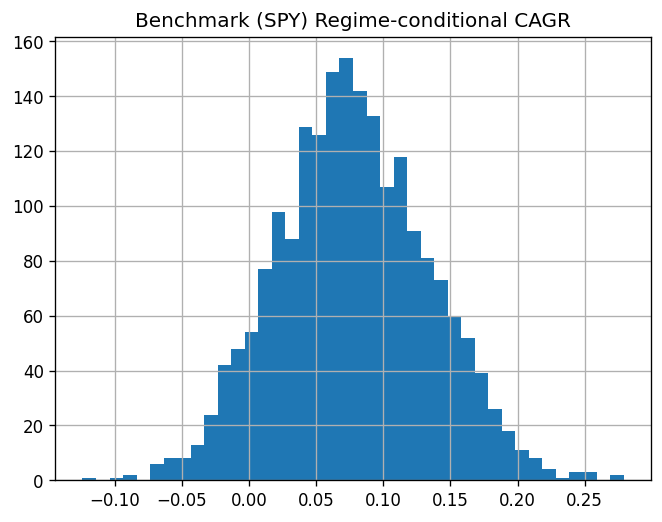

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

if 'bench' in globals() and isinstance(bench, pd.Series) and not bench.empty:
    bn = bench.copy()
else:
    bn = price_wide[BENCHMARK].pct_change(fill_method=None).dropna()

sr = (globals().get('port_rets_ra') if 'port_rets_ra' in globals() else
      globals().get('strategy_returns', port_rets2)).dropna()
bn = bn.reindex(sr.index).dropna()
sr = sr.reindex(bn.index).dropna()

reg_ser = (regime_df['regime_code']
           .reindex(sr.index).ffill().bfill().fillna(4)).round().clip(0,5).astype(int)

def block_bootstrap_regime(y: pd.Series, r: pd.Series, block=10, paths=2000, seed=321):
    rng = np.random.default_rng(seed)
    yv, rv = y.values, r.values
    T = len(yv)
    max_start = max(T - block + 1, 1)
    base_choices = np.arange(max_start, dtype=int)
    starts = {k: np.where(rv[:max_start]==k)[0] for k in np.unique(rv)}

    out = np.zeros((paths, T))
    for p in range(paths):
        t = 0
        while t < T:
            kreg = rv[t]
            choices = starts.get(kreg, np.array([], dtype=int))
            s = int(rng.choice(base_choices)) if choices.size == 0 else int(rng.choice(choices))
            m = min(block, T - t)
            out[p, t:t+m] = yv[s:s+m]
            t += m
    return out

paths_bench = block_bootstrap_regime(bn, reg_ser, block=10, paths=2000, seed=321)

cum_b = (1 + paths_bench).cumprod(axis=1)
end_b = cum_b[:, -1]
cagr_b = end_b ** (252/len(bn)) - 1
shp_b  = (paths_bench.mean(axis=1) * np.sqrt(252)) / (paths_bench.std(axis=1) + 1e-12)

print("Regime-conditional MC Benchmark")
print(f"  Median CAGR  : {np.median(cagr_b):.2%}")
print(f"  5–95% CAGR   : {np.percentile(cagr_b,5):.2%} .. {np.percentile(cagr_b,95):.2%}")
print(f"  Median Sharpe: {np.median(shp_b):.2f}")

plt.figure(dpi=120)
plt.hist(cagr_b, bins=40)
plt.title(f'Benchmark ({BENCHMARK}) Regime-conditional CAGR')
plt.grid(True)
plt.show()


,Name,Start,End,Obs,CAGR,Vol,Sharpe,MaxDD,Turnover(mean/reb)
0,port_rets_ra2,2021-05-01,2025-08-14,1516,0.110435,0.113361,0.980850,-0.144988,0.466080
1,port_rets2,2021-10-01,2025-08-14,1368,0.082745,0.105835,0.804194,-0.125652,1.378289
2,port_rets_te_ra,2021-05-01,2025-08-14,1516,0.084096,0.112517,0.773942,-0.151653,NaN
3,port_rets_qp,2021-05-01,2025-08-14,1516,0.060894,0.101221,0.634683,-0.218725,0.833580
4,port_rets_ra,2021-05-01,2025-08-14,1516,0.054041,0.096164,0.595454,-0.207980,0.855090
5,port_rets_te,2021-05-01,2025-08-14,1516,0.044909,0.107216,0.463419,-0.207650,NaN
6,port_rets_fast,2021-04-17,2025-08-14,1469,-0.031693,0.106106,-0.250295,-0.276810,0.646940
7,strategy_returns,2021-04-17,2025-08-14,1469,-0.031693,0.106106,-0.250295,-0.276810,NaN


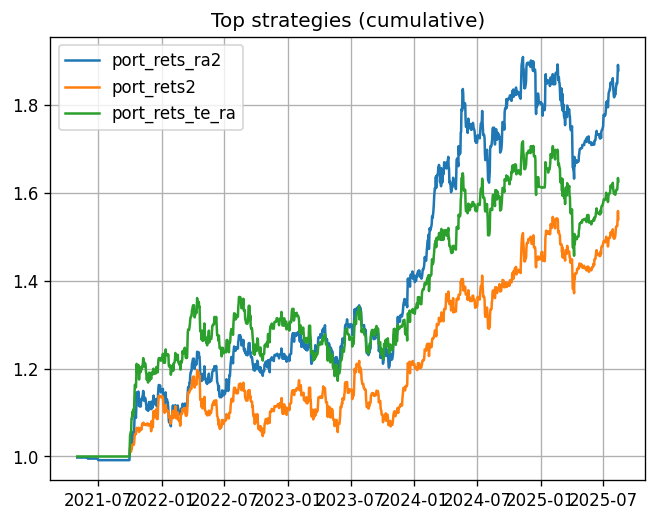

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

TRADING_DAYS   = globals().get('TRADING_DAYS', 252)
COMMON_PERIOD  = False
MIN_OBS        = 120

def _clean_series(s):
    s = pd.Series(s).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if s.abs().median() > 1.0:
        s = s.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan).dropna()
    return s

def _ann_vol(x):
    x = _clean_series(x)
    return x.std(ddof=0) * np.sqrt(TRADING_DAYS)

def _sharpe(x):
    x = _clean_series(x)
    s = x.std(ddof=0)
    return 0.0 if s == 0 else np.sqrt(TRADING_DAYS) * x.mean() / s

def _mdd(x):
    x = _clean_series(x)
    if x.empty: return np.nan
    c = (1 + x).cumprod()
    return (c / c.cummax() - 1).min()

def _cagr(x):
    x = _clean_series(x)
    n = len(x)
    return (1 + x).prod() ** (TRADING_DAYS / max(n, 1)) - 1 if n > 0 else np.nan

candidates = []
for name, obj in list(globals().items()):
    if not isinstance(obj, (pd.Series, pd.DataFrame)):
        continue
    if isinstance(obj, pd.DataFrame) and obj.shape[1] != 1:
        continue
    if name.startswith("port_rets") or name in ("strategy_returns",):
        s = obj.squeeze()
        try:
            s = _clean_series(s)
        except Exception:
            continue
        if len(s) >= MIN_OBS:
            candidates.append((name, s.sort_index()))

if not candidates:
    raise RuntimeError("No candidate strategies found (need one of: port_rets*, strategy_returns)")

if COMMON_PERIOD and len(candidates) > 1:
    common_idx = candidates[0][1].index
    for _, s in candidates[1:]:
        common_idx = common_idx.intersection(s.index)
    common_idx = common_idx.unique().sort_values()
    aligned = []
    for name, s in candidates:
        ss = s.reindex(common_idx).dropna()
        if len(ss) >= MIN_OBS:
            aligned.append((name, ss))
    candidates = aligned if aligned else candidates

rows = []
for name, s in candidates:
    suffix = name.replace("port_rets", "")
    wname = f"weights_df{suffix}".replace("__", "_")
    wdf = globals().get(wname, None)
    turnover = np.nan
    if isinstance(wdf, pd.DataFrame) and not wdf.empty:
        try:
            turnover = float(wdf.diff().abs().sum(axis=1).mean())
        except Exception:
            turnover = np.nan

    rows.append({
        "Name": name,
        "Start": s.index.min().date() if len(s) else None,
        "End":   s.index.max().date() if len(s) else None,
        "Obs":   int(len(s)),
        "CAGR":  _cagr(s),
        "Vol":   _ann_vol(s),
        "Sharpe":_sharpe(s),
        "MaxDD": _mdd(s),
        "Turnover(mean/reb)": turnover
    })

scoreboard = pd.DataFrame(rows)
scoreboard = scoreboard.sort_values(["Sharpe", "CAGR", "MaxDD"], ascending=[False, False, False]).reset_index(drop=True)

display(scoreboard)

try:
    topN = min(3, len(scoreboard))
    plt.figure(dpi=120)
    for i in range(topN):
        nm = scoreboard.loc[i, "Name"]
        s = dict(candidates)[nm]
        plt.plot((1+s).cumprod(), label=nm)
    plt.title("Top strategies (cumulative)"); plt.grid(True); plt.legend(); plt.show()
except Exception:
    pass


Blend of port_rets_ra2 & port_rets2: alpha=1.00  Sharpe=1.05  CAGR=12.48%  MaxDD=-14.50%

Champion Selected
Name: blend(port_rets_ra2,port_rets2,1.00)
Period: 2021-10-01 → 2025-08-14
CAGR=12.48% | Vol=11.93% | Sharpe=1.05 | MaxDD=-14.50%


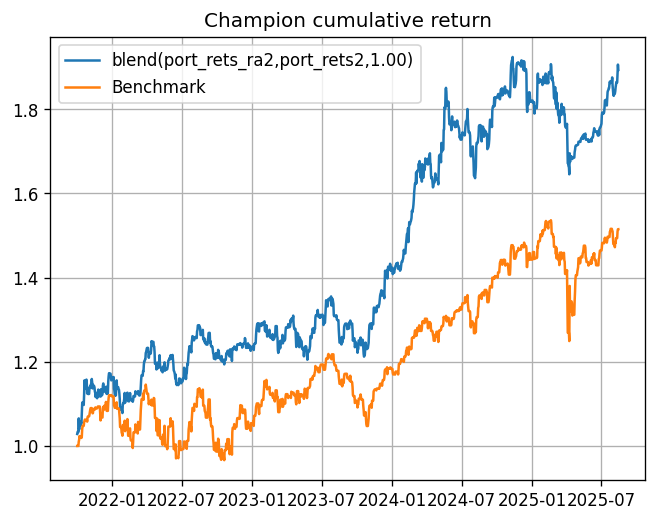


Champion latest saved weights (sum |w|): 1.0


,2025-07-31
DBC,0.040433
XLI,0.040363
XLV,0.040363
GLD,0.040363
SPY,0.040363
QQQ,0.040363
XLY,0.040363
IWM,0.040363
XLK,0.040363
USO,0.040033


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

TRADING_DAYS = globals().get('TRADING_DAYS', 252)

def _ann_vol(x: pd.Series) -> float:
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    return x.std(ddof=0) * np.sqrt(TRADING_DAYS)

def _sharpe(x: pd.Series) -> float:
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    s = x.std(ddof=0)
    return 0.0 if s == 0 else np.sqrt(TRADING_DAYS) * x.mean() / s

def _mdd(x: pd.Series) -> float:
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    if x.empty: return np.nan
    c = (1 + x).cumprod()
    return (c / c.cummax() - 1).min()

def _cagr(x: pd.Series) -> float:
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna()
    n = max(len(x), 1)
    return (1 + x).prod() ** (TRADING_DAYS / n) - 1

def _get_by_name(name: str):
    assert name in globals(), f"{name} not found in globals()"
    r = pd.Series(globals()[name]).dropna()
    suffix = name.replace("port_rets", "")
    suffix = suffix if suffix else ""
    wname = f"weights_df{suffix}".replace("__", "_")
    bname = f"bench{suffix}" if f"bench{suffix}" in globals() else "bench"

    w = globals().get(wname, pd.DataFrame())
    b = globals().get(bname, None)

    if (b is None) and ('price_wide' in globals()) and ('BENCHMARK' in globals()):
        bw = price_wide[BENCHMARK].reindex(r.index)
        b = bw.pct_change(fill_method=None).fillna(0.0)

    if isinstance(w, pd.DataFrame):
        w = w.copy()
    if isinstance(b, pd.Series):
        b = pd.to_numeric(b, errors='coerce').fillna(0.0)

    return r, w, b

def _normalize_weights(w: pd.Series) -> pd.Series:
    if w is None or w.empty: return w
    allow_short = bool(globals().get('ALLOW_SHORT', False))
    lo = -1.0 if allow_short else 0.0
    w = w.clip(lo, 1.0).fillna(0.0)
    s = w.abs().sum()
    return (w / s) if s > 0 else w

assert 'scoreboard' in globals(), "Run your scoreboard cell first (needs a DataFrame with a 'Name' column)"
assert isinstance(scoreboard, pd.DataFrame) and ('Name' in scoreboard.columns), "scoreboard must have a 'Name' column"

top2 = [str(n) for n in scoreboard['Name'].head(2).tolist() if isinstance(n, str) and n.strip()]
if len(top2) == 0:
    raise RuntimeError("No strategies to blend (scoreboard is empty)")

if len(top2) == 1:
    print(f"Only one strategy; using it as champion: {top2[0]}")
    champion_name = top2[0]
    champion_returns, champion_weights, bench_series = _get_by_name(champion_name)
    champion_returns = champion_returns.dropna()
    champion_weights_latest = (
        champion_weights.dropna(how='all').iloc[-1].fillna(0.0)
        if isinstance(champion_weights, pd.DataFrame) and not champion_weights.empty else None
    )
else:
    n1, n2 = top2
    r1, w1, b1 = _get_by_name(n1)
    r2, w2, b2 = _get_by_name(n2)

    common = r1.index.intersection(r2.index)
    r1, r2 = r1.reindex(common).dropna(), r2.reindex(common).dropna()

    if (len(r1) < 30) or (len(r2) < 30):
        s1, s2 = _sharpe(r1), _sharpe(r2)
        champion_name = n1 if s1 >= s2 else n2
        champion_returns, champion_weights, bench_series = _get_by_name(champion_name)
        champion_returns = champion_returns.dropna()
        champion_weights_latest = (
            champion_weights.dropna(how='all').iloc[-1].fillna(0.0)
            if isinstance(champion_weights, pd.DataFrame) and not champion_weights.empty else None
        )
    else:
        best = {"alpha": None, "score": -1e18, "sharpe": None, "cagr": None, "dd": None}
        champion_returns = None
        for a in np.linspace(0, 1, 101):
            mix = a * r1 + (1 - a) * r2
            sr  = _sharpe(mix); dd = _mdd(mix); cgr = _cagr(mix)
            if not (np.isfinite(sr) and np.isfinite(dd) and np.isfinite(cgr)):
                continue
            scr = sr - 0.5 * abs(dd)
            if scr > best["score"]:
                best.update(alpha=a, score=scr, sharpe=sr, cagr=cgr, dd=dd)
                champion_returns = mix

        print(f"Blend of {n1} & {n2}: alpha={best['alpha']:.2f}  "
              f"Sharpe={best['sharpe']:.2f}  CAGR={best['cagr']:.2%}  MaxDD={best['dd']:.2%}")
        champion_name = f"blend({n1},{n2},{best['alpha']:.2f})"

        champion_weights_latest = None
        if isinstance(w1, pd.DataFrame) and not w1.empty and isinstance(w2, pd.DataFrame) and not w2.empty:
            w1_last = w1.dropna(how='all').iloc[-1].fillna(0.0)
            w2_last = w2.dropna(how='all').iloc[-1].fillna(0.0)
            all_idx = w1_last.index.union(w2_last.index)
            w1_last = w1_last.reindex(all_idx).fillna(0.0)
            w2_last = w2_last.reindex(all_idx).fillna(0.0)
            ww = best['alpha'] * w1_last + (1 - best['alpha']) * w2_last
            champion_weights_latest = _normalize_weights(ww)

        bench_series = b1 if isinstance(b1, pd.Series) and not b1.empty else b2

CHAMPION_NAME = champion_name
CHAMPION_RETURNS = pd.Series(champion_returns).dropna()
CHAMPION_WEIGHTS_LATEST = (_normalize_weights(champion_weights_latest)
                           if 'champion_weights_latest' in locals() and champion_weights_latest is not None else None)

print("\nChampion Selected")
print("Name:", CHAMPION_NAME)
print("Period:", str(CHAMPION_RETURNS.index.min().date()), "→", str(CHAMPION_RETURNS.index.max().date()))
print(f"CAGR={_cagr(CHAMPION_RETURNS):.2%} | Vol={_ann_vol(CHAMPION_RETURNS):.2%} "
      f"| Sharpe={_sharpe(CHAMPION_RETURNS):.2f} | MaxDD={_mdd(CHAMPION_RETURNS):.2%}")

bench_plot = None
if isinstance(bench_series := locals().get('bench_series', None), pd.Series) and not bench_series.empty:
    bench_plot = bench_series.reindex(CHAMPION_RETURNS.index).fillna(0.0)
elif ('price_wide' in globals()) and ('BENCHMARK' in globals()):
    bench_plot = price_wide[BENCHMARK].reindex(CHAMPION_RETURNS.index).pct_change(fill_method=None).fillna(0.0)
elif 'bench' in globals() and isinstance(bench, pd.Series):
    bench_plot = bench.reindex(CHAMPION_RETURNS.index).fillna(0.0)

plt.figure(dpi=120)
plt.plot((1 + CHAMPION_RETURNS).cumprod(), label=CHAMPION_NAME)
if isinstance(bench_plot, pd.Series) and not bench_plot.empty:
    plt.plot((1 + bench_plot).cumprod(), label='Benchmark')
plt.title("Champion cumulative return"); plt.grid(True); plt.legend(); plt.show()

if CHAMPION_WEIGHTS_LATEST is not None and not CHAMPION_WEIGHTS_LATEST.empty:
    print("\nChampion latest saved weights (sum |w|):", float(CHAMPION_WEIGHTS_LATEST.abs().sum()))
    try:
        display(CHAMPION_WEIGHTS_LATEST.sort_values(ascending=False).head(15))
    except NameError:
        print(CHAMPION_WEIGHTS_LATEST.sort_values(ascending=False).head(15))
else:
    print("\nNo saved weights to show for the champion")


In [ ]:
import numpy as np, pandas as pd
from sklearn.covariance import LedoitWolf

ALLOW_SHORT          = globals().get('ALLOW_SHORT', False)
GROSS_TARGET         = globals().get('GROSS_TARGET', 1.0)
MAX_WEIGHT_PER_ASSET = globals().get('MAX_WEIGHT_PER_ASSET', 0.15)
TURNOVER_MIX         = globals().get('TURNOVER_MIX', 1.0)
RISK_AVERSION        = globals().get('RISK_AVERSION', 2.0)
TURNOVER_PENALTY     = globals().get('TURNOVER_PENALTY', 0.0)
TRADING_DAYS         = globals().get('TRADING_DAYS', 252)
USE_QP               = globals().get('USE_QP', True)

try:
    import cvxpy as cp
    _HAS_CP = True
except Exception:
    _HAS_CP = False

def _shrunk_cov(hist_returns: pd.DataFrame) -> np.ndarray:
    hr = hist_returns.tail(60).fillna(0.0).values
    if hr.size == 0 or hr.shape[0] < 10:
        std = hist_returns.tail(60).std(ddof=0).fillna(0.0).values
        C = np.diag((std + 1e-8)**2)
    else:
        try:
            C = LedoitWolf().fit(hr).covariance_
        except Exception:
            C = np.cov(hr, rowvar=False)
    n = C.shape[0]
    return C + 1e-6*np.eye(n)

def _safe_regime_adjust(date: pd.Timestamp, w: pd.Series) -> pd.Series:
    if 'regime_adjust_weights' in globals():
        try:
            return regime_adjust_weights(date, w)
        except Exception:
            return w
    return w

def _try_regime_aware_weights(d, prev_w=None):
    if 'compute_signal_scores_v2' not in globals() or 'final_model' not in globals():
        return None
    if 'price_wide' not in globals() or not isinstance(price_wide, pd.DataFrame):
        return None

    raw_scores = compute_signal_scores_v2(d, final_model)
    if raw_scores is None or len(raw_scores) == 0:
        return None

    mu = pd.Series(raw_scores).copy()

    rcode = 4
    if 'compute_current_regime' in globals():
        try:
            rcode = int(compute_current_regime(d))
        except Exception:
            rcode = 4
    if 'calibrators' in globals() and isinstance(calibrators, dict) and calibrators.get(rcode) is not None:
        try:
            mu = pd.Series(calibrators[rcode].predict(mu.values), index=mu.index)
        except Exception:
            pass

    if 'beta_neutralize' in globals():
        try:
            px = price_wide[mu.index].dropna(how='all')
            rets_slice = px.pct_change(fill_method=None).loc[:d]
            mu = beta_neutralize(mu, rets_slice)
        except Exception:
            pass

    px = price_wide[mu.index].dropna(how='all')
    rets = px.pct_change(fill_method=None).fillna(0.0).loc[:d]
    if rets.empty:
        return None
    C = _shrunk_cov(rets)

    idx_assets = list(mu.index)
    n = len(idx_assets)
    prev_w = (prev_w.reindex(idx_assets).fillna(0.0)
              if isinstance(prev_w, pd.Series) else pd.Series(0.0, index=idx_assets))

    w = None
    if _HAS_CP and USE_QP:
        try:
            w_var = cp.Variable(n)
            obj = (RISK_AVERSION * cp.quad_form(w_var, C)
                   - mu.values @ w_var
                   + TURNOVER_PENALTY * cp.sum_squares(w_var - prev_w.values))
            cons = [cp.norm1(w_var) <= GROSS_TARGET,
                    w_var <=  MAX_WEIGHT_PER_ASSET,
                    w_var >= (-MAX_WEIGHT_PER_ASSET if ALLOW_SHORT else 0)]
            prob = cp.Problem(cp.Minimize(obj), cons)
            for solver in [getattr(cp, 'OSQP', None),
                           getattr(cp, 'CLARABEL', None),
                           getattr(cp, 'SCS', None),
                           getattr(cp, 'ECOS', None)]:
                if solver is None:
                    continue
                try:
                    kw = dict(warm_start=True, verbose=False)
                    if getattr(solver, '__name__', '') == 'OSQP':
                        kw.update(polish=True, eps_abs=1e-6, eps_rel=1e-6, max_iter=10000)
                    prob.solve(solver=solver, **kw)
                    if prob.status in ("optimal","optimal_inaccurate"):
                        w = pd.Series(np.array(w_var.value).ravel(), index=idx_assets)
                        break
                except Exception:
                    continue
        except Exception:
            w = None

    if w is None:
        vol = rets.rolling(20).std(ddof=0).iloc[-1].replace(0, np.nan)
        adj = (mu / vol).replace([np.inf,-np.inf], np.nan).fillna(0.0)
        w = np.tanh(adj) if ALLOW_SHORT else adj.clip(lower=0.0)
        w = pd.Series(w, index=idx_assets)

    w = _safe_regime_adjust(d, w)
    if w.abs().sum() > 0:
        w = w / w.abs().sum()
    if isinstance(prev_w, pd.Series) and not prev_w.empty and TURNOVER_MIX < 1.0:
        w = TURNOVER_MIX * w + (1.0 - TURNOVER_MIX) * prev_w.reindex(w.index).fillna(0.0)
        if w.abs().sum() > 0:
            w = w / w.abs().sum()
    return w

assert 'price_wide' in globals() and isinstance(price_wide, pd.DataFrame), \
       "price_wide DataFrame is required"

go_live_date = pd.to_datetime(price_wide.index[-1])
print("Go-live date:", str(go_live_date.date()))

prev_w = globals().get("champion_weights_latest", pd.Series(dtype=float))
champion_weights_live = _try_regime_aware_weights(go_live_date, prev_w=prev_w)
if champion_weights_live is None:
    print("Fresh compute not available; falling back to last saved champion weights (if any)")
    champion_weights_live = prev_w.copy()

assert champion_weights_live is not None and not champion_weights_live.empty, "No live weights could be produced"
champion_weights_live = champion_weights_live.fillna(0.0)
if champion_weights_live.abs().sum() > 0:
    champion_weights_live = champion_weights_live / champion_weights_live.abs().sum()

print("\nLive weights suggestion (today)")
display(champion_weights_live.sort_values(ascending=False).head(20))

rets_for_cov = price_wide[champion_weights_live.index].pct_change(fill_method=None).dropna().tail(60)
if rets_for_cov.empty or len(rets_for_cov) < 5:
    print("Not enough recent data to compute implied vol.")
else:
    C = _shrunk_cov(rets_for_cov)
    wvec = champion_weights_live.reindex(rets_for_cov.columns).fillna(0.0).values.reshape(-1,1)
    imp_var = float(wvec.T @ C @ wvec)
    imp_vol = float(np.sqrt(max(0.0, imp_var)) * np.sqrt(TRADING_DAYS))
    print(f"Implied annualized vol (last 60d cov): {imp_vol:.2%}")

def _bucketed(weights: pd.Series):
    eq = set(globals().get("EQUITY_LIKE", []))
    df = set(globals().get("DEFENSIVE_LIKE", []))
    cr = set(globals().get("CRYPTO_LIKE", []))
    cm = set(globals().get("COMMODITY_RISKY", []))
    buckets = {
        "Equity-like": [x for x in weights.index if x in eq],
        "Defensive":   [x for x in weights.index if x in df],
        "Crypto":      [x for x in weights.index if x in cr],
        "Commod-Risky":[x for x in weights.index if x in cm],
    }
    used = set(sum(buckets.values(), []))
    buckets["Other"] = [x for x in weights.index if x not in used]
    return {k: float(weights[v].abs().sum()) for k,v in buckets.items() if len(v)>0}

print("\nExposure by bucket (|w| sums):")
print(_bucketed(champion_weights_live))


Go-live date: 2025-08-15

Live weights suggestion (today)


,0
LQD,0.140801
EFA,0.122271
GLD,0.103520
XLV,0.100327
IWM,0.069730
XLI,0.056158
VNQ,0.052801
XLU,0.051327
XLP,0.046894
QQQ,0.037778


Implied annualized vol (last 60d cov): 7.26%

Exposure by bucket (|w| sums):
{'Equity-like': 0.6392270005487297, 'Defensive': 0.28033440453811886, 'Crypto': 0.03287891023514126, 'Commod-Risky': 0.035581506740919235, 'Other': 0.011978177937090913}


/tmp/ipython-input-3007060119.py:154: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imp_var = float(wvec.T @ C @ wvec)


In [ ]:
CHAMPION_NAME = "port_rets_ra2"
CHAMPION_RETURNS = port_rets_ra2.dropna().copy()
CHAMPION_WEIGHTS_LATEST = (
    weights_df_ra2.dropna(how='all').iloc[-1].fillna(0.0)
    if 'weights_df_ra2' in globals() and not weights_df_ra2.empty else None
)
CHAMPION_BENCH = price_wide[BENCHMARK].reindex(CHAMPION_RETURNS.index).pct_change(fill_method=None).fillna(0.0)

from sklearn.linear_model import LinearRegression
import numpy as np, pandas as pd
sr = pd.to_numeric(CHAMPION_RETURNS, errors='coerce').dropna()
br = pd.to_numeric(CHAMPION_BENCH.reindex(sr.index), errors='coerce').fillna(0.0)
beta = LinearRegression().fit(br.values.reshape(-1,1), sr.values).coef_[0]
alpha_ann = (sr - beta*br.values.ravel()).mean()*252
te = np.std(sr - beta*br.values.ravel())*np.sqrt(252)
ir = alpha_ann/(te+1e-12)
print(f"[Champion] beta={beta:.2f}, TE={te:.2%}, alpha={alpha_ann:.2%}, IR={ir:.2f}, n={len(sr)}")


[Champion] beta=0.57, TE=8.33%, alpha=6.22%, IR=0.75, n=1516


In [ ]:
(1+CHAMPION_RETURNS).cumprod().to_frame("cum").to_csv("champion_equity_curve.csv")
champion_weights_live.to_csv("champion_weights_live.csv")
pd.Series({"beta":float(beta),"TE":float(te),"alpha_ann":float(alpha_ann),"IR":float(ir)}).to_csv("champion_risk_stats.csv")
print("Saved: champion_equity_curve.csv, champion_weights_live.csv, champion_risk_stats.csv")


Saved: champion_equity_curve.csv, champion_weights_live.csv, champion_risk_stats.csv


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
def round_to_lot(x, lot=1):
    return int(np.floor(x/lot))*lot

def build_orders(target_w, prices, curr_shares, V, allow_short=False, lot_size=1):
    tickers = target_w.index.intersection(prices.index)
    px = prices.loc[tickers].astype(float)
    w = target_w.loc[tickers].astype(float)
    if w.abs().sum() > 0: w = w / w.abs().sum()
    tgt_shares = (w * V / px).apply(lambda q: round_to_lot(q, lot_size))
    if not allow_short:
        tgt_shares = tgt_shares.clip(lower=0)
    curr = curr_shares.reindex(tickers).fillna(0).astype(int)
    delta = (tgt_shares - curr).astype(int)
    buys_cost = (delta.clip(lower=0) * px).sum()
    orders = delta[delta != 0].sort_index()
    return orders


In [ ]:
import pandas as pd, numpy as np, plotly.express as px, streamlit as st
st.set_page_config(page_title="Strategy Monitor", layout="wide")

@st.cache_data
def load_csv(path, **kw):
    try: return pd.read_csv(path, **kw)
    except: return None

ret = load_csv("results/champion_returns.csv")
bench = load_csv("results/bench.csv")
w = load_csv("results/live_weights.csv")
reg = load_csv("results/regime.csv")

def to_series(df, col="value"):
    if df is None or df.empty: return pd.Series(dtype=float)
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
    s = pd.Series(df.iloc[:,1].values, index=df.iloc[:,0].values).sort_index()
    return pd.to_numeric(s, errors="coerce").dropna()

sr = to_series(ret)
bn = to_series(bench)
if not bn.empty: bn = bn.reindex(sr.index).fillna(0.0)
cum = (1+sr).cumprod()
cum_b = (1+bn).cumprod() if not bn.empty else None

def ann_vol(x): return x.std(ddof=0)*np.sqrt(252)
def sharpe(x):
    s = x.std(ddof=0); return 0.0 if s==0 else np.sqrt(252)*x.mean()/s
def maxdd(x):
    c=(1+x).cumprod(); return (c/c.cummax()-1).min()

st.title("Strategy Monitor")

c1, c2, c3, c4 = st.columns(4)
if not sr.empty:
    cagr = (1+sr).prod()**(252/len(sr))-1
    c1.metric("CAGR", f"{cagr: .2%}")
    c2.metric("Vol", f"{ann_vol(sr): .2%}")
    c3.metric("Sharpe", f"{sharpe(sr): .2f}")
    c4.metric("MaxDD", f"{maxdd(sr): .2%}")

st.subheader("Cumulative Return")
df_plot = pd.DataFrame({"Strategy": cum})
if cum_b is not None and not cum_b.empty: df_plot["Benchmark"] = cum_b
st.plotly_chart(px.line(df_plot), use_container_width=True)

st.subheader("Drawdown")
dd = cum/cum.cummax()-1
st.plotly_chart(px.line(pd.DataFrame({"Drawdown": dd})), use_container_width=True)

if reg is not None and not reg.empty:
    reg_ser = to_series(reg).astype(int).reindex(sr.index).ffill()
    st.subheader("Regime")
    st.plotly_chart(px.area(reg_ser.rename("Regime")), use_container_width=True)

if w is not None and not w.empty:
    wdf = w.copy()
    if "weight" not in wdf.columns:
        wdf.columns = ["ticker","weight"]
    wdf = wdf.sort_values("weight", ascending=False)
    st.subheader("Live Weights")
    c1, c2 = st.columns([2,1])
    c1.plotly_chart(px.bar(wdf.head(20), x="ticker", y="weight"), use_container_width=True)
    c2.dataframe(wdf.head(30), use_container_width=True)


2025-08-15 20:07:03.728 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 20:07:03.729 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-15 20:07:03.730 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-15 20:07:03.731 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 20:07:03.833 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-15 20:07:03.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-15 20:07:03.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running 

KPIs
Strategy: champion_returns | Period 2021-10-01 → 2025-08-14
  CAGR  12.48% | Vol 11.93% | Sharpe 1.05 | MaxDD -14.50%
Benchmark
  CAGR  7.95% | Vol 14.01% | Sharpe 0.62 | MaxDD -18.70%


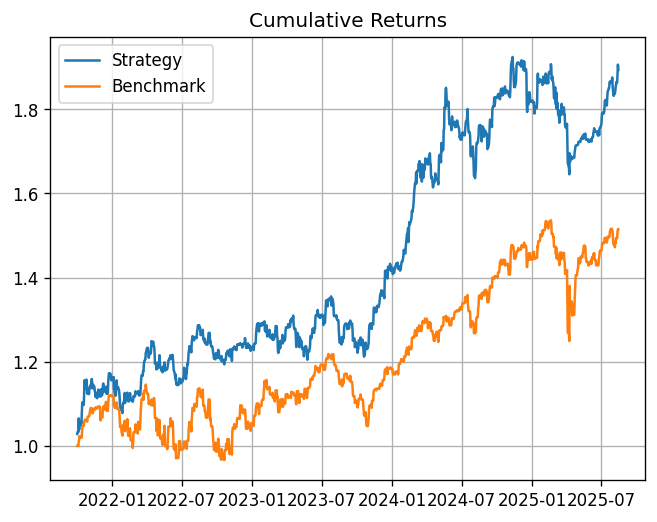

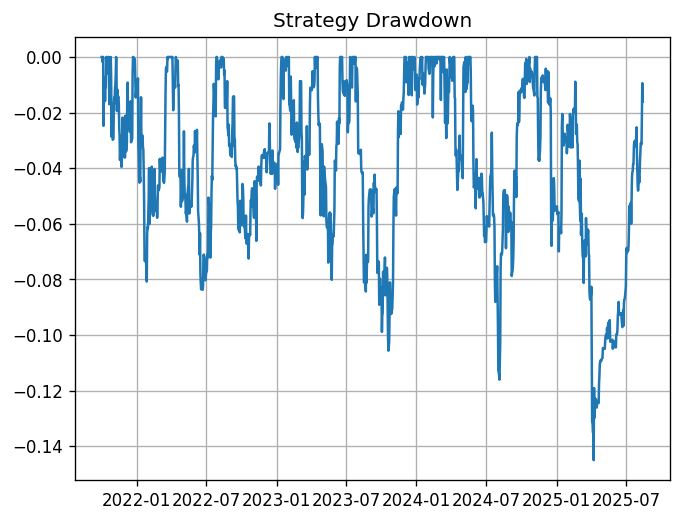

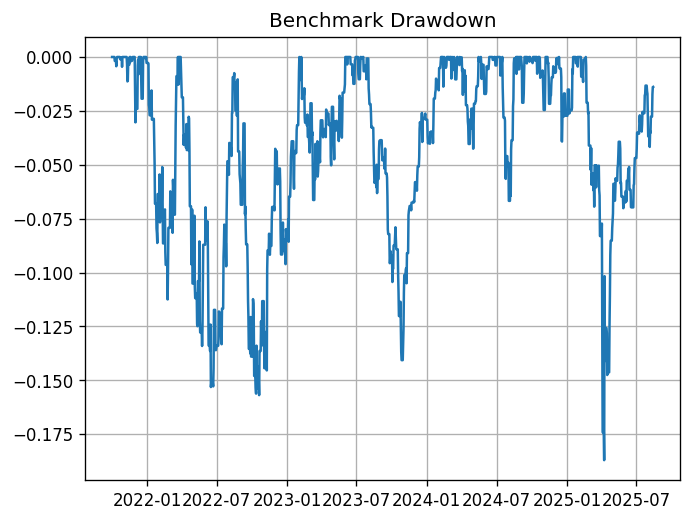

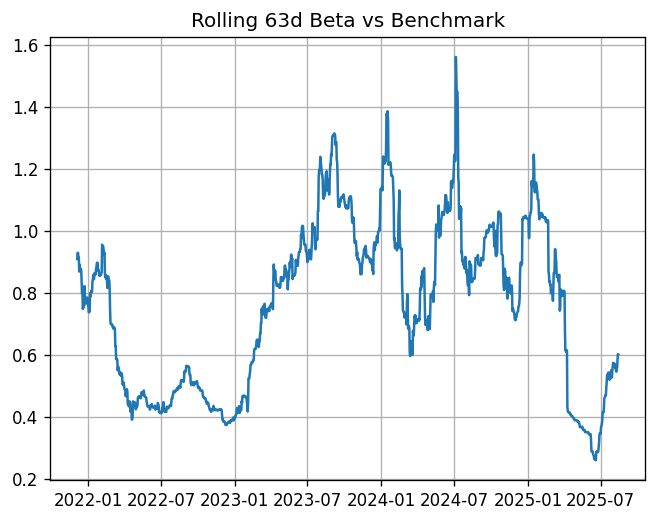

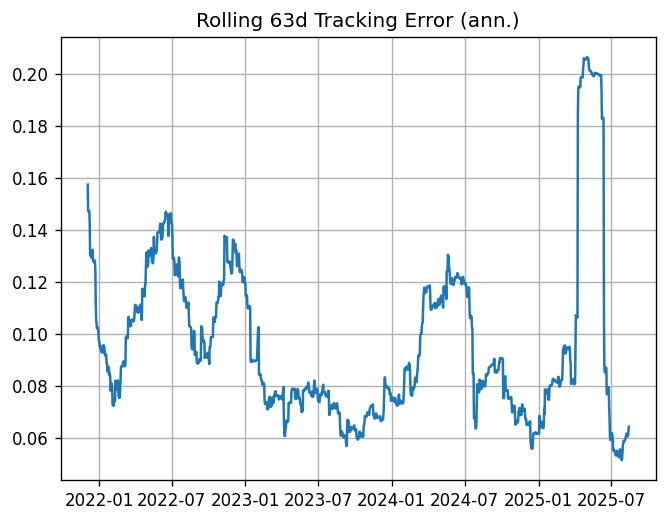

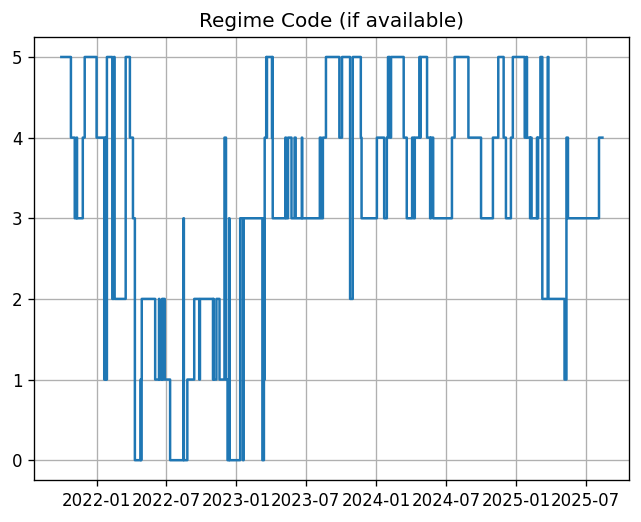


== Latest weights (top 20) ==


,2025-07-31
DBC,0.040433
XLI,0.040363
XLV,0.040363
GLD,0.040363
SPY,0.040363
QQQ,0.040363
XLY,0.040363
IWM,0.040363
XLK,0.040363
USO,0.040033


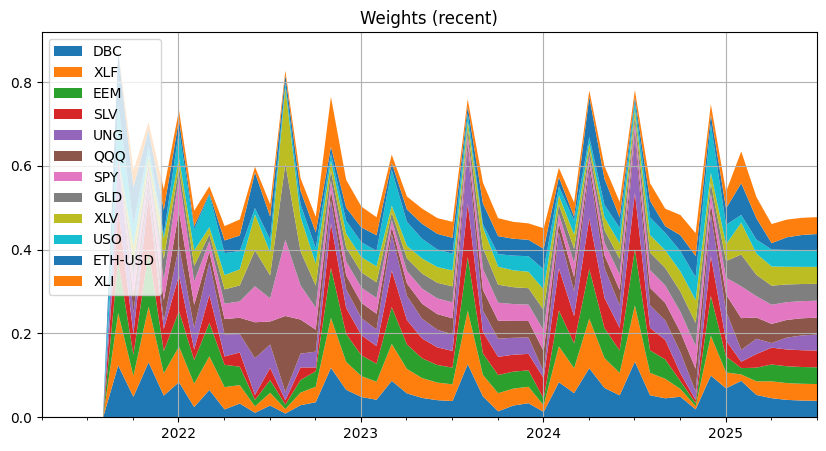


Dashboard ready


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

PLOT_DPI = 120
TRADING_DAYS = globals().get('TRADING_DAYS', 252)

def _is_series(x): return isinstance(x, pd.Series)
def _is_frame(x):  return isinstance(x, pd.DataFrame)

def _pick_first(names):
    for n in names:
        if n in globals():
            obj = globals()[n]
            if _is_series(obj): return n, obj.dropna()
            if _is_frame(obj) and obj.shape[1] == 1:
                return n, obj.iloc[:,0].dropna()
    return None, None

def _perf(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").replace([np.inf,-np.inf], np.nan).dropna()
    if len(x) == 0:
        return dict(CAGR=np.nan, Vol=np.nan, Sharpe=np.nan, MaxDD=np.nan)
    cagr = (1+x).prod()**(TRADING_DAYS/len(x)) - 1
    vol  = x.std(ddof=0)*np.sqrt(TRADING_DAYS)
    shrp = 0.0 if x.std(ddof=0)==0 else np.sqrt(TRADING_DAYS)*x.mean()/x.std(ddof=0)
    dd   = ((1+x).cumprod() / (1+x).cumprod().cummax() - 1).min()
    return dict(CAGR=cagr, Vol=vol, Sharpe=shrp, MaxDD=dd)

def _rolling_beta_te(r: pd.Series, m: pd.Series, win=63):
    r, m = r.align(m, join='inner')
    beta = r.rolling(win).cov(m) / (m.rolling(win).var() + 1e-12)
    te   = (r - m).rolling(win).std(ddof=0) * np.sqrt(TRADING_DAYS)
    return beta.dropna(), te.dropna()

def _latest_weights():
    for wn in ['champion_weights_latest',
               'weights_df_ra2','weights_df2','weights_df_ra','weights_df_fast',
               'weights_df_qp','weights_df']:
        if wn in globals():
            obj = globals()[wn]
            if _is_series(obj) and not obj.empty:
                return wn, obj.dropna()
            if _is_frame(obj) and not obj.empty:
                return wn, obj.dropna(how='all').iloc[-1].fillna(0.0)
    return None, pd.Series(dtype=float)

def _get_benchmark_like(strat_idx: pd.DatetimeIndex):
    for bn in ['bench_ra','bench2','bench_fast','bench_qp','bench']:
        if bn in globals():
            b = globals()[bn]
            if _is_series(b):
                return b.reindex(strat_idx).fillna(0.0)
            if _is_frame(b) and b.shape[1]==1:
                return b.iloc[:,0].reindex(strat_idx).fillna(0.0)
    if 'price_wide' in globals() and 'BENCHMARK' in globals():
        try:
            return price_wide[BENCHMARK].reindex(strat_idx).pct_change(fill_method=None).fillna(0.0)
        except Exception:
            pass
    return pd.Series(0.0, index=strat_idx, name='BENCH')

strat_name, strat = _pick_first([
    'champion_returns',
    'port_rets_ra2','port_rets2','port_rets_ra',
    'strategy_returns','port_rets_fast','port_rets_qp'
])
assert strat_name is not None and strat is not None and not strat.empty, "No strategy returns found"

bench = _get_benchmark_like(strat.index)

sp = _perf(strat)
bp = _perf(bench)
print("KPIs")
print(f"Strategy: {strat_name} | Period {strat.index.min().date()} → {strat.index.max().date()}")
print(f"  CAGR  {sp['CAGR']:.2%} | Vol {sp['Vol']:.2%} | Sharpe {sp['Sharpe']:.2f} | MaxDD {sp['MaxDD']:.2%}")
print(f"Benchmark")
print(f"  CAGR  {bp['CAGR']:.2%} | Vol {bp['Vol']:.2%} | Sharpe {bp['Sharpe']:.2f} | MaxDD {bp['MaxDD']:.2%}")

cum_s = (1+strat).cumprod()
cum_b = (1+bench.reindex(strat.index)).cumprod()
plt.figure(dpi=PLOT_DPI); plt.plot(cum_s, label='Strategy'); plt.plot(cum_b, label='Benchmark')
plt.grid(True); plt.legend(); plt.title('Cumulative Returns'); plt.show()

for name, series in [('Strategy', cum_s), ('Benchmark', cum_b)]:
    dd = series / series.cummax() - 1
    plt.figure(dpi=PLOT_DPI); plt.plot(dd); plt.grid(True); plt.title(f'{name} Drawdown'); plt.show()

beta, te = _rolling_beta_te(strat, bench, win=63)
if not beta.empty:
    plt.figure(dpi=PLOT_DPI); plt.plot(beta); plt.grid(True); plt.title('Rolling 63d Beta vs Benchmark'); plt.show()
if not te.empty:
    plt.figure(dpi=PLOT_DPI); plt.plot(te); plt.grid(True); plt.title('Rolling 63d Tracking Error (ann.)'); plt.show()

if 'regime_df' in globals() and isinstance(regime_df, pd.DataFrame) and 'regime_code' in regime_df.columns:
    r = regime_df['regime_code'].reindex(strat.index).ffill().bfill()
    if r.notna().any():
        plt.figure(dpi=PLOT_DPI); plt.step(r.index, r.values, where='post')
        plt.grid(True); plt.title('Regime Code (if available)'); plt.show()

wname, w_last = _latest_weights()
if not w_last.empty:
    print("\n== Latest weights (top 20) ==")
    display(w_last.sort_values(ascending=False).head(20))

    w_hist = None
    for wn in ['weights_df_ra2','weights_df2','weights_df_ra','weights_df_fast','weights_df_qp','weights_df']:
        if wn in globals():
            obj = globals()[wn]
            if _is_frame(obj) and not obj.empty:
                w_hist = obj.copy()
                break
    if isinstance(w_hist, pd.DataFrame) and not w_hist.empty:
        w_hist = w_hist.tail(200).fillna(0.0)
        top_cols = w_hist.abs().mean().sort_values(ascending=False).head(12).index
        ax = w_hist[top_cols].plot(kind='area', stacked=True, figsize=(10,5), linewidth=0)
        ax.set_title('Weights (recent)'); plt.grid(True); plt.show()
else:
    print("\n(no weights found to display)")

print("\nDashboard ready")


,beta,TE
date,,
2025-08-10,0.566617,0.061894
2025-08-11,0.567318,0.061893
2025-08-12,0.561552,0.061909
2025-08-13,0.597272,0.061372
2025-08-14,0.614125,0.063414


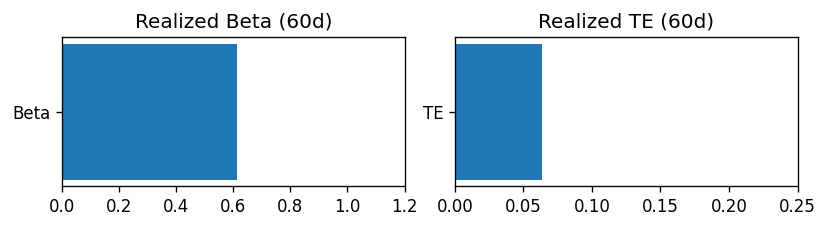

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def rolling_beta_te(port_ret: pd.Series, bench_ret: pd.Series, win=60):
    idx = port_ret.index.intersection(bench_ret.index)
    p = port_ret.reindex(idx).fillna(0.0); b = bench_ret.reindex(idx).fillna(0.0)
    betas, tes = [], []
    for i in range(win, len(idx)):
        s = slice(i-win, i)
        cov = np.cov(p.iloc[s], b.iloc[s])[0,1]
        var = np.var(b.iloc[s])
        beta = cov/(var+1e-12)
        te = np.std(p.iloc[s] - b.iloc[s]) * np.sqrt(252)
        betas.append(beta); tes.append(te)
    out = pd.DataFrame({"beta": betas, "TE": tes}, index=idx[win:])
    return out

port = globals().get('port_rets_ra2', globals().get('strategy_returns')).dropna()
bench= globals().get('bench_ra', globals().get('bench')).reindex(port.index).fillna(0.0)
roll = rolling_beta_te(port, bench, win=60)
display(roll.tail())

fig, ax = plt.subplots(1,2, figsize=(7,2), dpi=120)
ax[0].barh(['Beta'], [roll['beta'].iloc[-1]])
ax[0].set_xlim(0, 1.2); ax[0].set_title('Realized Beta (60d)')
ax[1].barh(['TE'], [roll['TE'].iloc[-1]])
ax[1].set_xlim(0, 0.25); ax[1].set_title('Realized TE (60d)')
plt.tight_layout(); plt.show()


In [ ]:
!pip -q install "dash>=2.11" plotly>=5.20

import numpy as np, pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, jupyter_dash

jupyter_dash.infer_jupyter_proxy_config()

sr = pd.Series(champion_returns).dropna()
bn = price_wide[BENCHMARK].reindex(sr.index).pct_change(fill_method=None).fillna(0.0)

cum_df = pd.DataFrame({
    "Date": sr.index,
    "Strategy": (1+sr).cumprod().values,
    BENCHMARK: (1+bn).cumprod().values
}).set_index("Date")

dd_strat = cum_df["Strategy"]/cum_df["Strategy"].cummax() - 1.0
dd_bench = cum_df[BENCHMARK]/cum_df[BENCHMARK].cummax() - 1.0

w = None
for cand in ["champion_weights_live", "champion_weights_latest"]:
    if cand in globals() and isinstance(globals()[cand], pd.Series) and not globals()[cand].empty:
        w = globals()[cand].sort_values(ascending=False)
        break
if w is None:
    w = pd.Series(dtype=float)

def exposures_from_buckets(weights: pd.Series) -> pd.DataFrame:
    eq = set(globals().get("EQUITY_LIKE", []))
    df = set(globals().get("DEFENSIVE_LIKE", []))
    cr = set(globals().get("CRYPTO_LIKE", []))
    cm = set(globals().get("COMMODITY_RISKY", []))
    buckets = {
        "Equity-like": [x for x in weights.index if x in eq],
        "Defensive":   [x for x in weights.index if x in df],
        "Crypto":      [x for x in weights.index if x in cr],
        "Commod-Risky":[x for x in weights.index if x in cm],
    }
    used = set(sum(buckets.values(), []))
    buckets["Other"] = [x for x in weights.index if x not in used]
    expo = {k: float(weights[v].abs().sum()) for k, v in buckets.items() if len(v) > 0}
    return pd.DataFrame({"Bucket": list(expo.keys()), "AbsWeight": list(expo.values())})

expo_df = exposures_from_buckets(w) if not w.empty else pd.DataFrame({"Bucket": [], "AbsWeight": []})

app = Dash(__name__)
app.layout = html.Div([
    html.H3("Strategy Dashboard"),
    dcc.Dropdown(
        id="view",
        options=[
            {"label": "Cumulative Returns", "value": "cum"},
            {"label": "Drawdowns", "value": "dd"},
            {"label": "Top Weights", "value": "w"},
            {"label": "Exposure Buckets", "value": "expo"},
        ],
        value="cum", clearable=False, style={"width": "320px"}
    ),
    dcc.Graph(id="graph", style={"height": "540px"})
])

@app.callback(Output("graph","figure"), Input("view","value"))
def _update(v):
    if v == "cum":
        fig = px.line(cum_df, labels={"value":"Growth of $1", "Date": ""})
        fig.update_layout(legend_title_text="")
        return fig
    if v == "dd":
        dd_df = pd.DataFrame({"Strategy": dd_strat, BENCHMARK: dd_bench})
        fig = px.line(dd_df, labels={"value":"Drawdown", "index": ""})
        fig.update_yaxes(tickformat=".0%")
        return fig
    if v == "w":
        top = w.head(20).sort_values(ascending=True)
        fig = px.bar(x=top.values, y=top.index, orientation="h", labels={"x":"Weight","y":""})
        fig.update_xaxes(tickformat=".1%")
        return fig
    if v == "expo":
        fig = px.bar(expo_df, x="Bucket", y="AbsWeight", labels={"AbsWeight":"|w| sum"})
        fig.update_yaxes(tickformat=".1%")
        return fig

app.run(jupyter_mode="inline", port=8051, debug=False, jupyter_height=650)


<IPython.core.display.Javascript object>

In [ ]:
import plotly.express as px, pandas as pd
w = pd.Series(champion_weights_live).abs()
cats = {}
for t in w.index:
    if t in globals().get('EQUITY_LIKE', []): cats[t] = 'Equity-like'
    elif t in globals().get('DEFENSIVE_LIKE', []): cats[t] = 'Defensive'
    elif t in globals().get('CRYPTO_LIKE', []): cats[t] = 'Crypto'
    elif t in globals().get('COMMODITY_RISKY', []): cats[t] = 'Commod-Risky'
    else: cats[t] = 'Other'
dfw = pd.DataFrame({'Weight':w, 'Bucket':[cats[t] for t in w.index]})
px.treemap(dfw.reset_index().rename(columns={'index':'Ticker'}),
           path=['Bucket','Ticker'], values='Weight', title='Weight Treemap').show()
